# HEROES Pointing

In this notebook we determine the telescope pointing during the HEROES flight.

In [220]:
import re
import csv
import copy

import numpy as np
import scipy.interpolate
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, SphericalRepresentation, Angle
from astropy.io import ascii, fits
from astropy.table import QTable
from astropy.time import Time
import astropy.units as u
from astropy.wcs import WCS
from astropy.utils.console import ProgressBar
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.transforms import Bbox
from matplotlib.patches import Circle
from sunpy.coordinates import sun, get_body_heliographic_stonyhurst, Helioprojective, HeliographicStonyhurst
import sunpy.coordinates.sun
import sunpy.map
import sunpy.data.sample

In [2]:
rcParams['figure.dpi'] = 150

In [3]:
# Helper function to rotate a 2D coordinate
def rotate(x, y, angle):
    return ( x * np.cos(angle) + y * np.sin(angle),
            -x * np.sin(angle) + y * np.cos(angle))

In [4]:
def convert_altaz_offsets_to_solar_coords(alt_offset, az_offset, times, observatory_locations, SolarFrame,
                                          cosine_correct_az=True, verbose=False):
    """
    Convert azimuth and elevation of a target measured by an observatory to a solar coordinate system.
    
    Parameters
    ----------
    alt_offset: `astropy.units.Quantity`
        Offset in the target's elevation as measured from the observatory.
        
    az_offset: `astropy.units.Quantity`
        Offset in the target's azimuth as measured from the observatory.
    
    times: `astropy.time.Time`
        The times at which each target location was measured.

    observatory_locations: `astropy.coordinates.EarthLocation`
        The location of the observatory at each time supplied above.
        
    SolarFrame: `astropy.coordinates.baseframe.FrameMeta`
        The solar coordinate system into which the target coordinates are to be transfered.
        E.g. sunpy.cordinates.Helioprojective
        
    cosine_correct_az: `bool`
        If True, apply cosine correction to the target azimuth based in the target elevation.
        If this correction is already accounted for in the supplied azimuth values, set to False.
        Default=True
        
    Returns
    -------
    target_solar: `astropy.coordinates.sky_coordinate.SkyCoord`
        The target coordinates in the supplied solar coordinate system
        
    """

    n = len(times)
    if len(alt_offset) != len(az_offset) != len(observatory_locations) != n:
        raise ValueError("target_alt, target_az, times and observatory_locations must have same length.")

    # Generate a Spherical Representation of the origin of a generic coordinate frame
    # with the same number of coordinates as target measurements.  Use below.
    origin = SphericalRepresentation([0]*n*u.deg, [0]*n*u.deg, [0]*n*u.m)
    
    if verbose:
        print("Generating Sun center coordinates.")
    # Generate coordinates of the Sun center from a well-understood solar coordinate frame.
    sun_center = SkyCoord(origin, frame=HeliographicStonyhurst, obstime=times)
    
    if verbose:
        print("Generating observatory frames.")
    # Generate AltAz coordinate frames based on the balloon locations.
    observatory_frames = AltAz(obstime=times, location=observatory_locations)

    if verbose:
        print("Generating observatory coordinates.")
    # Generate a SkyCoord object for the observatory locations.
    observatory_coords = SkyCoord(observatory_frames.realize_frame(origin))

    if verbose:
        print("Transforming Sun center to observatory frames.")
    # Calculate the position of the Sun's center in the observatory frame.
    sun_from_observatory = sun_center.transform_to(observatory_frames)

    if verbose:
        print("Converting target alt/az to observatory frames.")
    # Convert the measured target alt and az to the observatory frame.
    target_alt = sun_from_observatory.alt + alt_offset
    if cosine_correct_az:
        target_az = sun_from_observatory.az + az_offset / np.cos(target_alt.rad)  # here's the cosine factor
    else:
        target_az = sun_from_observatory.az + az_offset

    # Transform target locations to desired solar coordinate system.
    target_from_observatory = sun_from_observatory.realize_frame(
        SphericalRepresentation(target_az, target_alt, sun_from_observatory.distance))
    if verbose:
        print("Transforming target alt/az to Solar Frame.")
    target_solar = SkyCoord(target_from_observatory).transform_to(SolarFrame(observer=observatory_coords))
    
    return target_solar
    #except:
    #    return target_az, target_alt, sun_from_observatory.distance

In [5]:
def plot_hist(data):
    unit = data.unit
    data = data.value
    # Derive bins
    lims = np.floor(data.min()), np.ceil(data.max())
    # Construct histogram
    hist, bins = np.histogram(data, bins=np.arange(*lims))
    plt.step(bins[:-1], hist)
    plt.ylabel("No. Events")

## Read & Prep Data

### PYAS-F header data

In [6]:
# Pointing target in HPC

HPC_X = -794*u.arcsec
HPC_Y = 102*u.arcsec

# Calibrated constants

#define CLOCKING_ANGLE_PYASF -32.425 //model is -33.26
#define CENTER_X_PYASF    124.68 //mils
#define CENTER_Y_PYASF    -74.64 //mils

theta0 = -32.425*u.deg
x0 = 124.68*u.imperial.mil
y0 = -74.64*u.imperial.mil

focal_length = 3*u.m

In [7]:
# Read in PYAS-F header data and add units to all columns
pyasf = QTable(ascii.read("pyasf_headers.csv", format="csv"))
pyasf['RT_SEC'] *= u.s
pyasf['RT_NSEC'] *= u.ns
pyasf['SUNCENT1'] *= u.pix
pyasf['SLOPE1'] *= u.imperial.mil / u.pix
pyasf['INTRCPT1'] *= u.imperial.mil
pyasf['SUNCENT2'] *= u.pix
pyasf['SLOPE2'] *= u.imperial.mil / u.pix
pyasf['INTRCPT2'] *= u.imperial.mil
pyasf['GPS_LAT'] *= u.deg
pyasf['GPS_LON'] *= u.deg
pyasf['NORTHANG'] *= u.deg

In [8]:
# Convert time columns to Astropy Time
pyasf['obstime'] = Time(pyasf['RT_SEC'] + pyasf['RT_NSEC'], format='unix', scale='utc')
pyasf['obstime'].format = 'fits'

del pyasf['RT_SEC'], pyasf['RT_NSEC']

In [9]:
# Convert pixel offsets to angular offsets in the azimuth/elevation directions
# The azimuth offset must be scaled by 1/cos(elevation) before being added to the azimuth
dx = pyasf['SUNCENT1'] * pyasf['SLOPE1'] + pyasf['INTRCPT1'] - x0
dy = pyasf['SUNCENT2'] * pyasf['SLOPE2'] + pyasf['INTRCPT2'] - y0

d_az, d_el = rotate(dx, dy, theta0)  # confirm direction
pyasf['offset_az'] = -np.arctan2(d_az, focal_length).to('arcsec')  # confirm negative sign
pyasf['offset_el'] = np.arctan2(d_el, focal_length).to('arcsec')

del pyasf['SUNCENT1'], pyasf['SLOPE1'], pyasf['INTRCPT1']
del pyasf['SUNCENT2'], pyasf['SLOPE2'], pyasf['INTRCPT2']

In [10]:
n_pyasf = len(pyasf)

### PYAS-R header data

In [11]:
# Pointing target in HPC for PYAS-R

HPC_X_pyasr = 0*u.arcsec
HPC_Y_pyasr = 0*u.arcsec

# Calibrated constants

#define CLOCKING_ANGLE_PYASR -52.175 //model is -53.26
#define CENTER_X_PYASR -105.59 //mils
#define CENTER_Y_PYASR   -48.64 //mils

theta0_pyasr = -52.175*u.deg
x0_pyasr = -105.59*u.imperial.mil
y0_pyasr = -48.64*u.imperial.mil

focal_length_pyasr = 3*u.m

In [12]:
# Read in PYAS-F header data and add units to all columns
pyasr = QTable(ascii.read("pyasr_headers.csv", format="csv"))
pyasr['RT_SEC'] *= u.s
pyasr['RT_NSEC'] *= u.ns
pyasr['SUNCENT1'] *= u.pix
pyasr['SLOPE1'] *= u.imperial.mil / u.pix
pyasr['INTRCPT1'] *= u.imperial.mil
pyasr['SUNCENT2'] *= u.pix
pyasr['SLOPE2'] *= u.imperial.mil / u.pix
pyasr['INTRCPT2'] *= u.imperial.mil
pyasr['GPS_LAT'] *= u.deg
pyasr['GPS_LON'] *= u.deg
pyasr['NORTHANG'] *= u.deg

In [13]:
# Convert time columns to Astropy Time
pyasr['obstime'] = Time(pyasr['RT_SEC'] + pyasr['RT_NSEC'], format='unix', scale='utc')
pyasr['obstime'].format = 'fits'

del pyasr['RT_SEC'], pyasr['RT_NSEC']

In [14]:
# Convert pixel offsets to angular offsets in the azimuth/elevation directions
# The azimuth offset must be scaled by 1/cos(elevation) before being added to the azimuth
dx = pyasr['SUNCENT1'] * pyasr['SLOPE1'] + pyasr['INTRCPT1'] - x0_pyasr
dy = pyasr['SUNCENT2'] * pyasr['SLOPE2'] + pyasr['INTRCPT2'] - y0_pyasr

d_az, d_el = rotate(dx, dy, theta0_pyasr)  # confirm direction
pyasr['offset_az'] = -np.arctan2(d_az, focal_length_pyasr).to('arcsec')  # confirm negative sign
pyasr['offset_el'] = np.arctan2(d_el, focal_length_pyasr).to('arcsec')

del pyasr['SUNCENT1'], pyasr['SLOPE1'], pyasr['INTRCPT1']
del pyasr['SUNCENT2'], pyasr['SLOPE2'], pyasr['INTRCPT2']

In [15]:
n_pyasr = len(pyasr)

### GPS Data

In [16]:
# Read GPS data
n_time_cols = 2
n_quantity_cols = 5
n_other_cols = 4
time_cols = [None] * n_time_cols
time_col_names = [None] * n_time_cols
quantity_cols = [None] * n_quantity_cols
quantity_col_names = [None] * n_quantity_cols
other_cols = [None] * n_other_cols
other_col_names = [None] * n_other_cols

with fits.open("f13_gps.fits") as hdulist:

    # Read out time data
    mjdref = Time(hdulist[1].header["MJDREF"], format="mjd")
    for i in range(n_time_cols):
        j = i+1
        time_col_names[i] = hdulist[1].header["TTYPE{0}".format(j)]
        time_cols[i] = mjdref + u.Quantity(hdulist[1].data[time_col_names[i]],
                                           re.sub("sec", "s", hdulist[1].header["TUNIT{0}".format(j)]))
    # Read out data with units
    for i in range(n_quantity_cols):
        j = i + 1 + n_time_cols
        quantity_col_names[i] = hdulist[1].header["TTYPE{0}".format(j)]
        quantity_cols[i] = u.Quantity(hdulist[1].data[quantity_col_names[i]],
                                      re.sub("sec", "s", hdulist[1].header["TUNIT{0}".format(j)]))
    # Read out data without units
    for i in range(n_other_cols):
        j = i + 1 + n_time_cols + n_quantity_cols
        other_col_names[i] = hdulist[1].header["TTYPE{0}".format(j)]
        other_cols[i] = hdulist[1].data[quantity_col_names[i]]
        
# Combine cols
col_names = tuple(time_col_names + quantity_col_names + other_col_names)
cols = time_cols + quantity_cols + other_cols
    
    
# Read into Table
gps = QTable(cols, names=col_names)

In [17]:
# Define functions to interpolate GPS data to new time grid.
interp_gps_lat = scipy.interpolate.interp1d(gps["TIME"].value, gps["Latitude"].data)
interp_gps_lon = scipy.interpolate.interp1d(gps["TIME"].value, gps["Longitude"].data)
interp_gps_height = scipy.interpolate.interp1d(gps["TIME"].value, gps["Height"].data)

## Determine HPC pointing

### PYAS-F - Determine Approximate HPC pointing from incorrect header Sun Orientation Info

In [18]:
# Obtain approximate HPC pointing by rotating the azimuth/elevation offsets
# Use the incorrect Sun orientation stored in the headers
bad_Tx_pyasf, bad_Ty_pyasf = rotate(pyasf['offset_az'], pyasf['offset_el'], -pyasf['NORTHANG'])

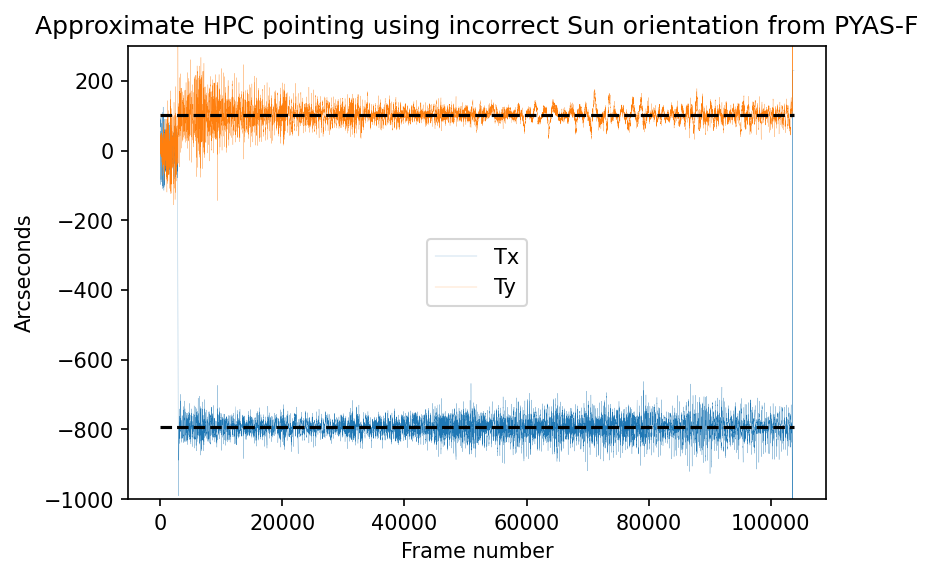

In [19]:
# Plot the approximate HPC pointing by rotating the azimuth/elevation offsets
plt.plot(bad_Tx_pyasf, label='Tx', linewidth=0.1)
plt.plot(bad_Ty_pyasf, label='Ty', linewidth=0.1)
plt.legend()

plt.title('Approximate HPC pointing using incorrect Sun orientation from PYAS-F')
plt.xlabel('Frame number')
plt.ylabel('Arcseconds')
plt.ylim(-1000, 300)

plt.plot([0, len(bad_Tx_pyasf)], HPC_X * [1, 1], 'k', linestyle='dashed')
plt.plot([0, len(bad_Ty_pyasf)], HPC_Y * [1, 1], 'k', linestyle='dashed')
plt.show()

#### Convert Approximate PYAS-F pointing to PYAS-R Time Grid

In [19]:
# Define functions to interpolate approximate PYAS-F pointing to new time grid.
interp_bad_Tx_pyasf = scipy.interpolate.interp1d(pyasf['obstime'].replicate(format="mjd").value, bad_Tx_pyasf.value)
interp_bad_Ty_pyasf = scipy.interpolate.interp1d(pyasf['obstime'].replicate(format="mjd").value, bad_Ty_pyasf.value)

In [20]:
bad_Tx_pyasf_pyasrtime = interp_bad_Tx_pyasf(pyasr['obstime'].replicate(format="mjd").value) * bad_Tx_pyasf.unit
bad_Ty_pyasf_pyasrtime = interp_bad_Ty_pyasf(pyasr['obstime'].replicate(format="mjd").value) * bad_Ty_pyasf.unit

### PYAS-F - Determine Accurate HPC pointing from GPS info

In [21]:
# Interpolate GPS data to PYASF times
gps_lat_pyasf = interp_gps_lat(pyasf['obstime'].replicate(format="mjd").value) * gps["Latitude"].unit
gps_lon_pyasf = interp_gps_lon(pyasf['obstime'].replicate(format="mjd").value) * gps["Longitude"].unit
gps_height_pyasf = interp_gps_height(pyasf['obstime'].replicate(format="mjd").value) * gps["Height"].unit

In [22]:
#"""
# Define balloon locations relative to Earth over the course of the campaign.
balloon_locations_pyasf = EarthLocation(lat=gps_lat_pyasf, lon=gps_lon_pyasf, height=gps_height_pyasf)

target_hpc_pyasf = convert_altaz_offsets_to_solar_coords(pyasf['offset_el'], pyasf['offset_az'],
                                                         pyasf['obstime'], balloon_locations_pyasf, Helioprojective,
                                                         verbose=True)
#"""

Generating Sun center coordinates.
Generating observatory frames.
Generating observatory coordinates.
Transforming Sun center to observatory frames.
Converting target alt/az to observatory frames.
Transforming target alt/az to Solar Frame.


In [23]:
# Calculate Sun's orientation on PYAS-R's time grid.
sun_orientation_pyasf = sunpy.coordinates.sun.orientation(balloon_locations_pyasf, time=pyasf['obstime'])

In [34]:
"""
with open("sun_heroes_positions_pyasf.csv", "w", buffering=1) as openfile:
    csvwriter = csv.writer(openfile)  
    # Write colnames  
    csvwriter.writerow(["time", "HPC x", "HPC y"])
    # Write col units  
    csvwriter.writerow(["utc", "arcsec", "arcsec"])
    data = target_hpc_pyasf
    for i in range(n_pyasf): 
        #print(i, n_pyasf) 
        csvwriter.writerow([data.obstime[i].value,
                            data.Tx[i].to(u.arcsec).value,
                            data.Ty[i].to(u.arcsec).value])
"""

In [22]:
"""
# Read GPS data derived above.
with open("sun_heroes_positions_pyasf.csv", "r") as openfile:
    csvreader = csv.DictReader(openfile)
    # Read units
    col_units = next(csvreader)
    # Read variable names.
    names = list(col_units.keys())
    quantity_names = copy.deepcopy(names)
    del(quantity_names[0])
    # Read data
    output = next(csvreader)
    for name in names:
        output[name] = [output[name]]
    for row in csvreader:
        #print(row)
        for name in names:
            output[name].append(row[name])
    output["time"] = Time(output["time"])
    for name in quantity_names:
        output[name] = u.Quantity(np.array(output[name]).astype(float), unit=col_units[name])
        
    gps_pointing_pyasf = output
"""

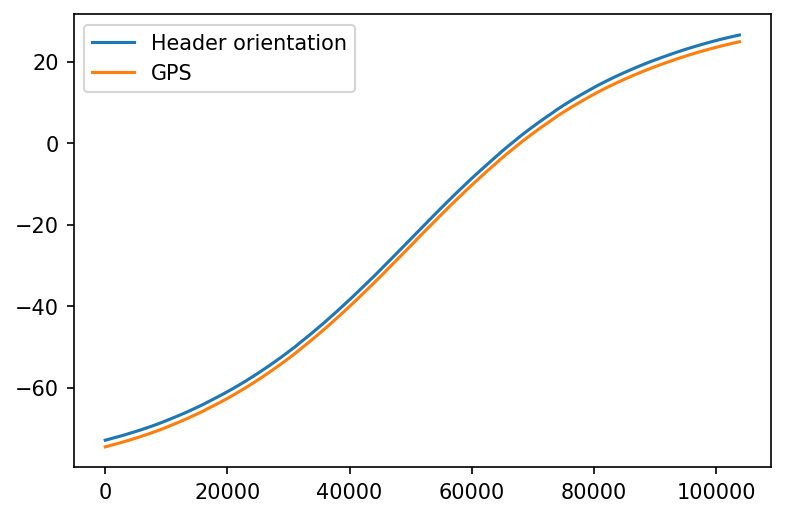

In [25]:
plt.plot(pyasf['NORTHANG'], label='Header orientation')
plt.plot(sun_orientation_pyasf, label="GPS")
plt.legend()

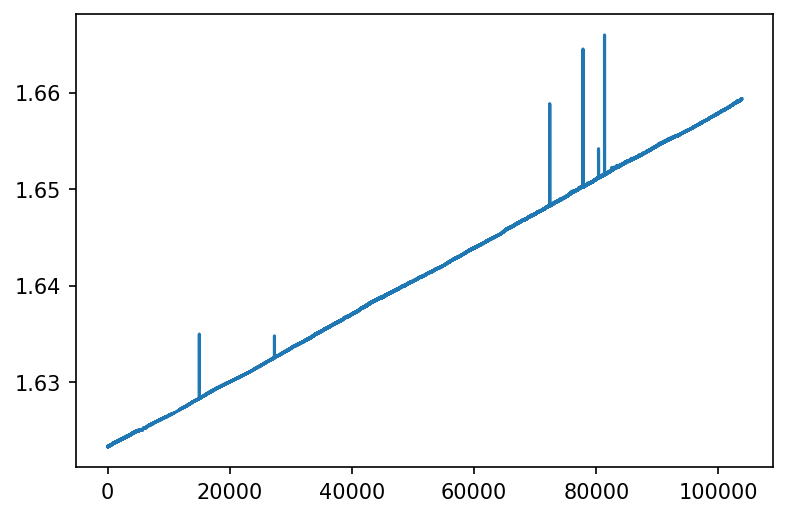

In [26]:
plt.plot(pyasf['NORTHANG'] - sun_orientation_pyasf)#/pyasf['NORTHANG'])
#plt.ylim(-1, 0.1)

### PYAS-R - Determine Approximate HPC pointing from incorrect header Sun Orientation Info

In [24]:
# Obtain approximate HPC pointing by rotating the azimuth/elevation offsets
# Use the incorrect Sun orientation stored in the headers
bad_Tx_pyasr, bad_Ty_pyasr = rotate(pyasr['offset_az'], pyasr['offset_el'], -pyasr['NORTHANG'])

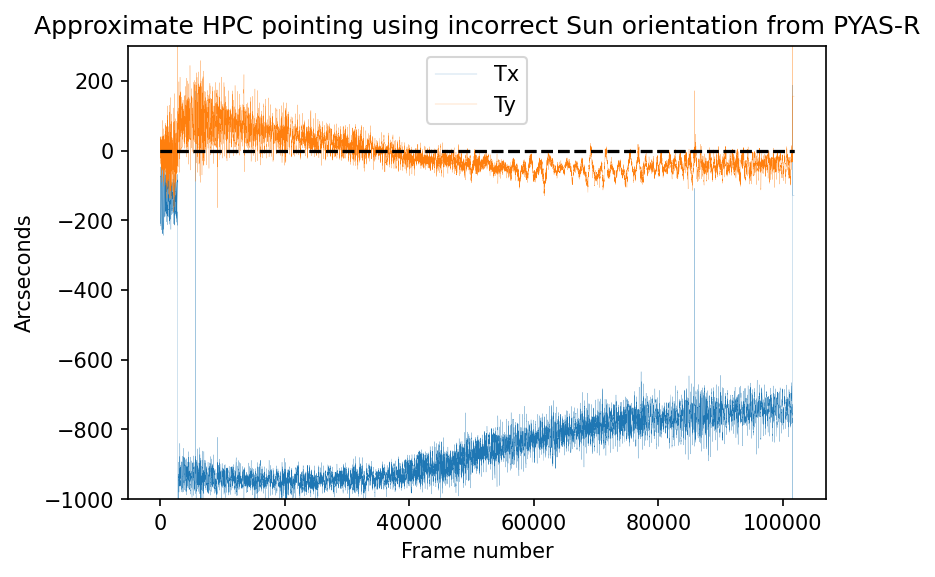

In [28]:
# Plot the approximate HPC pointing by rotating the azimuth/elevation offsets
plt.plot(bad_Tx_pyasr, label='Tx', linewidth=0.1)
plt.plot(bad_Ty_pyasr, label='Ty', linewidth=0.1)
plt.legend()

plt.title('Approximate HPC pointing using incorrect Sun orientation from PYAS-R')
plt.xlabel('Frame number')
plt.ylabel('Arcseconds')
plt.ylim(-1000, 300)

plt.plot([0, len(bad_Tx_pyasr)], HPC_X_pyasr * [1, 1], 'k', linestyle='dashed')
plt.plot([0, len(bad_Ty_pyasr)], HPC_Y_pyasr * [1, 1], 'k', linestyle='dashed')
plt.show()

### PYAS-R - Determine Accurate HPC pointing from GPS info

In [25]:
# Interpolate GPS data to PYASF times
gps_lat_pyasr = interp_gps_lat(pyasr['obstime'].replicate(format="mjd").value) * gps["Latitude"].unit
gps_lon_pyasr = interp_gps_lon(pyasr['obstime'].replicate(format="mjd").value) * gps["Longitude"].unit
gps_height_pyasr = interp_gps_height(pyasr['obstime'].replicate(format="mjd").value) * gps["Height"].unit

In [26]:
# Define balloon locations relative to Earth over the course of the campaign.
balloon_locations_pyasr = EarthLocation(lat=gps_lat_pyasr, lon=gps_lon_pyasr, height=gps_height_pyasr)

target_hpc_pyasr = convert_altaz_offsets_to_solar_coords(pyasr['offset_el'], pyasr['offset_az'],
                                                         pyasr['obstime'], balloon_locations_pyasr, Helioprojective,
                                                         verbose=True)

Generating Sun center coordinates.
Generating observatory frames.
Generating observatory coordinates.
Transforming Sun center to observatory frames.
Converting target alt/az to observatory frames.
Transforming target alt/az to Solar Frame.


In [27]:
# Calculate Sun's orientation on PYAS-R's time grid.
sun_orientation_pyasr = sunpy.coordinates.sun.orientation(balloon_locations_pyasr, time=pyasr['obstime'])

In [35]:
"""
with open("sun_heroes_positions_pyasr.csv", "w", buffering=1) as openfile:
    csvwriter = csv.writer(openfile)  
    # Write colnames  
    csvwriter.writerow(["time", "HPC x", "HPC y"])
    # Write col units  
    csvwriter.writerow(["", "arcsec", "arcsec"])
    for i in range(n_pyasr): 
        #print(i, n_pyasr) 
        csvwriter.writerow([pyasr['obstime'][i].value,
                            target_hpc_pyasr.Tx[i].to(u.arcsec).value,
                            target_hpc_pyasr.Ty[i].to(u.arcsec).value])
"""

0 101813
1 101813
2 101813
3 101813
4 101813
5 101813
6 101813
7 101813
8 101813
9 101813
10 101813
11 101813
12 101813
13 101813
14 101813
15 101813
16 101813
17 101813
18 101813
19 101813
20 101813
21 101813
22 101813
23 101813
24 101813
25 101813
26 101813
27 101813
28 101813
29 101813
30 101813
31 101813
32 101813
33 101813
34 101813
35 101813
36 101813
37 101813
38 101813
39 101813
40 101813
41 101813
42 101813
43 101813
44 101813
45 101813
46 101813
47 101813
48 101813
49 101813
50 101813
51 101813
52 101813
53 101813
54 101813
55 101813
56 101813
57 101813
58 101813
59 101813
60 101813
61 101813
62 101813
63 101813
64 101813
65 101813
66 101813
67 101813
68 101813
69 101813
70 101813
71 101813
72 101813
73 101813
74 101813
75 101813
76 101813
77 101813
78 101813
79 101813
80 101813
81 101813
82 101813
83 101813
84 101813
85 101813
86 101813
87 101813
88 101813
89 101813
90 101813
91 101813
92 101813
93 101813
94 101813
95 101813
96 101813
97 101813
98 101813
99 101813
100 101813

767 101813
768 101813
769 101813
770 101813
771 101813
772 101813
773 101813
774 101813
775 101813
776 101813
777 101813
778 101813
779 101813
780 101813
781 101813
782 101813
783 101813
784 101813
785 101813
786 101813
787 101813
788 101813
789 101813
790 101813
791 101813
792 101813
793 101813
794 101813
795 101813
796 101813
797 101813
798 101813
799 101813
800 101813
801 101813
802 101813
803 101813
804 101813
805 101813
806 101813
807 101813
808 101813
809 101813
810 101813
811 101813
812 101813
813 101813
814 101813
815 101813
816 101813
817 101813
818 101813
819 101813
820 101813
821 101813
822 101813
823 101813
824 101813
825 101813
826 101813
827 101813
828 101813
829 101813
830 101813
831 101813
832 101813
833 101813
834 101813
835 101813
836 101813
837 101813
838 101813
839 101813
840 101813
841 101813
842 101813
843 101813
844 101813
845 101813
846 101813
847 101813
848 101813
849 101813
850 101813
851 101813
852 101813
853 101813
854 101813
855 101813
856 101813
857 101813

1528 101813
1529 101813
1530 101813
1531 101813
1532 101813
1533 101813
1534 101813
1535 101813
1536 101813
1537 101813
1538 101813
1539 101813
1540 101813
1541 101813
1542 101813
1543 101813
1544 101813
1545 101813
1546 101813
1547 101813
1548 101813
1549 101813
1550 101813
1551 101813
1552 101813
1553 101813
1554 101813
1555 101813
1556 101813
1557 101813
1558 101813
1559 101813
1560 101813
1561 101813
1562 101813
1563 101813
1564 101813
1565 101813
1566 101813
1567 101813
1568 101813
1569 101813
1570 101813
1571 101813
1572 101813
1573 101813
1574 101813
1575 101813
1576 101813
1577 101813
1578 101813
1579 101813
1580 101813
1581 101813
1582 101813
1583 101813
1584 101813
1585 101813
1586 101813
1587 101813
1588 101813
1589 101813
1590 101813
1591 101813
1592 101813
1593 101813
1594 101813
1595 101813
1596 101813
1597 101813
1598 101813
1599 101813
1600 101813
1601 101813
1602 101813
1603 101813
1604 101813
1605 101813
1606 101813
1607 101813
1608 101813
1609 101813
1610 101813
1611

2229 101813
2230 101813
2231 101813
2232 101813
2233 101813
2234 101813
2235 101813
2236 101813
2237 101813
2238 101813
2239 101813
2240 101813
2241 101813
2242 101813
2243 101813
2244 101813
2245 101813
2246 101813
2247 101813
2248 101813
2249 101813
2250 101813
2251 101813
2252 101813
2253 101813
2254 101813
2255 101813
2256 101813
2257 101813
2258 101813
2259 101813
2260 101813
2261 101813
2262 101813
2263 101813
2264 101813
2265 101813
2266 101813
2267 101813
2268 101813
2269 101813
2270 101813
2271 101813
2272 101813
2273 101813
2274 101813
2275 101813
2276 101813
2277 101813
2278 101813
2279 101813
2280 101813
2281 101813
2282 101813
2283 101813
2284 101813
2285 101813
2286 101813
2287 101813
2288 101813
2289 101813
2290 101813
2291 101813
2292 101813
2293 101813
2294 101813
2295 101813
2296 101813
2297 101813
2298 101813
2299 101813
2300 101813
2301 101813
2302 101813
2303 101813
2304 101813
2305 101813
2306 101813
2307 101813
2308 101813
2309 101813
2310 101813
2311 101813
2312

2949 101813
2950 101813
2951 101813
2952 101813
2953 101813
2954 101813
2955 101813
2956 101813
2957 101813
2958 101813
2959 101813
2960 101813
2961 101813
2962 101813
2963 101813
2964 101813
2965 101813
2966 101813
2967 101813
2968 101813
2969 101813
2970 101813
2971 101813
2972 101813
2973 101813
2974 101813
2975 101813
2976 101813
2977 101813
2978 101813
2979 101813
2980 101813
2981 101813
2982 101813
2983 101813
2984 101813
2985 101813
2986 101813
2987 101813
2988 101813
2989 101813
2990 101813
2991 101813
2992 101813
2993 101813
2994 101813
2995 101813
2996 101813
2997 101813
2998 101813
2999 101813
3000 101813
3001 101813
3002 101813
3003 101813
3004 101813
3005 101813
3006 101813
3007 101813
3008 101813
3009 101813
3010 101813
3011 101813
3012 101813
3013 101813
3014 101813
3015 101813
3016 101813
3017 101813
3018 101813
3019 101813
3020 101813
3021 101813
3022 101813
3023 101813
3024 101813
3025 101813
3026 101813
3027 101813
3028 101813
3029 101813
3030 101813
3031 101813
3032

3636 101813
3637 101813
3638 101813
3639 101813
3640 101813
3641 101813
3642 101813
3643 101813
3644 101813
3645 101813
3646 101813
3647 101813
3648 101813
3649 101813
3650 101813
3651 101813
3652 101813
3653 101813
3654 101813
3655 101813
3656 101813
3657 101813
3658 101813
3659 101813
3660 101813
3661 101813
3662 101813
3663 101813
3664 101813
3665 101813
3666 101813
3667 101813
3668 101813
3669 101813
3670 101813
3671 101813
3672 101813
3673 101813
3674 101813
3675 101813
3676 101813
3677 101813
3678 101813
3679 101813
3680 101813
3681 101813
3682 101813
3683 101813
3684 101813
3685 101813
3686 101813
3687 101813
3688 101813
3689 101813
3690 101813
3691 101813
3692 101813
3693 101813
3694 101813
3695 101813
3696 101813
3697 101813
3698 101813
3699 101813
3700 101813
3701 101813
3702 101813
3703 101813
3704 101813
3705 101813
3706 101813
3707 101813
3708 101813
3709 101813
3710 101813
3711 101813
3712 101813
3713 101813
3714 101813
3715 101813
3716 101813
3717 101813
3718 101813
3719

4356 101813
4357 101813
4358 101813
4359 101813
4360 101813
4361 101813
4362 101813
4363 101813
4364 101813
4365 101813
4366 101813
4367 101813
4368 101813
4369 101813
4370 101813
4371 101813
4372 101813
4373 101813
4374 101813
4375 101813
4376 101813
4377 101813
4378 101813
4379 101813
4380 101813
4381 101813
4382 101813
4383 101813
4384 101813
4385 101813
4386 101813
4387 101813
4388 101813
4389 101813
4390 101813
4391 101813
4392 101813
4393 101813
4394 101813
4395 101813
4396 101813
4397 101813
4398 101813
4399 101813
4400 101813
4401 101813
4402 101813
4403 101813
4404 101813
4405 101813
4406 101813
4407 101813
4408 101813
4409 101813
4410 101813
4411 101813
4412 101813
4413 101813
4414 101813
4415 101813
4416 101813
4417 101813
4418 101813
4419 101813
4420 101813
4421 101813
4422 101813
4423 101813
4424 101813
4425 101813
4426 101813
4427 101813
4428 101813
4429 101813
4430 101813
4431 101813
4432 101813
4433 101813
4434 101813
4435 101813
4436 101813
4437 101813
4438 101813
4439

5085 101813
5086 101813
5087 101813
5088 101813
5089 101813
5090 101813
5091 101813
5092 101813
5093 101813
5094 101813
5095 101813
5096 101813
5097 101813
5098 101813
5099 101813
5100 101813
5101 101813
5102 101813
5103 101813
5104 101813
5105 101813
5106 101813
5107 101813
5108 101813
5109 101813
5110 101813
5111 101813
5112 101813
5113 101813
5114 101813
5115 101813
5116 101813
5117 101813
5118 101813
5119 101813
5120 101813
5121 101813
5122 101813
5123 101813
5124 101813
5125 101813
5126 101813
5127 101813
5128 101813
5129 101813
5130 101813
5131 101813
5132 101813
5133 101813
5134 101813
5135 101813
5136 101813
5137 101813
5138 101813
5139 101813
5140 101813
5141 101813
5142 101813
5143 101813
5144 101813
5145 101813
5146 101813
5147 101813
5148 101813
5149 101813
5150 101813
5151 101813
5152 101813
5153 101813
5154 101813
5155 101813
5156 101813
5157 101813
5158 101813
5159 101813
5160 101813
5161 101813
5162 101813
5163 101813
5164 101813
5165 101813
5166 101813
5167 101813
5168

5770 101813
5771 101813
5772 101813
5773 101813
5774 101813
5775 101813
5776 101813
5777 101813
5778 101813
5779 101813
5780 101813
5781 101813
5782 101813
5783 101813
5784 101813
5785 101813
5786 101813
5787 101813
5788 101813
5789 101813
5790 101813
5791 101813
5792 101813
5793 101813
5794 101813
5795 101813
5796 101813
5797 101813
5798 101813
5799 101813
5800 101813
5801 101813
5802 101813
5803 101813
5804 101813
5805 101813
5806 101813
5807 101813
5808 101813
5809 101813
5810 101813
5811 101813
5812 101813
5813 101813
5814 101813
5815 101813
5816 101813
5817 101813
5818 101813
5819 101813
5820 101813
5821 101813
5822 101813
5823 101813
5824 101813
5825 101813
5826 101813
5827 101813
5828 101813
5829 101813
5830 101813
5831 101813
5832 101813
5833 101813
5834 101813
5835 101813
5836 101813
5837 101813
5838 101813
5839 101813
5840 101813
5841 101813
5842 101813
5843 101813
5844 101813
5845 101813
5846 101813
5847 101813
5848 101813
5849 101813
5850 101813
5851 101813
5852 101813
5853

6523 101813
6524 101813
6525 101813
6526 101813
6527 101813
6528 101813
6529 101813
6530 101813
6531 101813
6532 101813
6533 101813
6534 101813
6535 101813
6536 101813
6537 101813
6538 101813
6539 101813
6540 101813
6541 101813
6542 101813
6543 101813
6544 101813
6545 101813
6546 101813
6547 101813
6548 101813
6549 101813
6550 101813
6551 101813
6552 101813
6553 101813
6554 101813
6555 101813
6556 101813
6557 101813
6558 101813
6559 101813
6560 101813
6561 101813
6562 101813
6563 101813
6564 101813
6565 101813
6566 101813
6567 101813
6568 101813
6569 101813
6570 101813
6571 101813
6572 101813
6573 101813
6574 101813
6575 101813
6576 101813
6577 101813
6578 101813
6579 101813
6580 101813
6581 101813
6582 101813
6583 101813
6584 101813
6585 101813
6586 101813
6587 101813
6588 101813
6589 101813
6590 101813
6591 101813
6592 101813
6593 101813
6594 101813
6595 101813
6596 101813
6597 101813
6598 101813
6599 101813
6600 101813
6601 101813
6602 101813
6603 101813
6604 101813
6605 101813
6606

7237 101813
7238 101813
7239 101813
7240 101813
7241 101813
7242 101813
7243 101813
7244 101813
7245 101813
7246 101813
7247 101813
7248 101813
7249 101813
7250 101813
7251 101813
7252 101813
7253 101813
7254 101813
7255 101813
7256 101813
7257 101813
7258 101813
7259 101813
7260 101813
7261 101813
7262 101813
7263 101813
7264 101813
7265 101813
7266 101813
7267 101813
7268 101813
7269 101813
7270 101813
7271 101813
7272 101813
7273 101813
7274 101813
7275 101813
7276 101813
7277 101813
7278 101813
7279 101813
7280 101813
7281 101813
7282 101813
7283 101813
7284 101813
7285 101813
7286 101813
7287 101813
7288 101813
7289 101813
7290 101813
7291 101813
7292 101813
7293 101813
7294 101813
7295 101813
7296 101813
7297 101813
7298 101813
7299 101813
7300 101813
7301 101813
7302 101813
7303 101813
7304 101813
7305 101813
7306 101813
7307 101813
7308 101813
7309 101813
7310 101813
7311 101813
7312 101813
7313 101813
7314 101813
7315 101813
7316 101813
7317 101813
7318 101813
7319 101813
7320

7943 101813
7944 101813
7945 101813
7946 101813
7947 101813
7948 101813
7949 101813
7950 101813
7951 101813
7952 101813
7953 101813
7954 101813
7955 101813
7956 101813
7957 101813
7958 101813
7959 101813
7960 101813
7961 101813
7962 101813
7963 101813
7964 101813
7965 101813
7966 101813
7967 101813
7968 101813
7969 101813
7970 101813
7971 101813
7972 101813
7973 101813
7974 101813
7975 101813
7976 101813
7977 101813
7978 101813
7979 101813
7980 101813
7981 101813
7982 101813
7983 101813
7984 101813
7985 101813
7986 101813
7987 101813
7988 101813
7989 101813
7990 101813
7991 101813
7992 101813
7993 101813
7994 101813
7995 101813
7996 101813
7997 101813
7998 101813
7999 101813
8000 101813
8001 101813
8002 101813
8003 101813
8004 101813
8005 101813
8006 101813
8007 101813
8008 101813
8009 101813
8010 101813
8011 101813
8012 101813
8013 101813
8014 101813
8015 101813
8016 101813
8017 101813
8018 101813
8019 101813
8020 101813
8021 101813
8022 101813
8023 101813
8024 101813
8025 101813
8026

8670 101813
8671 101813
8672 101813
8673 101813
8674 101813
8675 101813
8676 101813
8677 101813
8678 101813
8679 101813
8680 101813
8681 101813
8682 101813
8683 101813
8684 101813
8685 101813
8686 101813
8687 101813
8688 101813
8689 101813
8690 101813
8691 101813
8692 101813
8693 101813
8694 101813
8695 101813
8696 101813
8697 101813
8698 101813
8699 101813
8700 101813
8701 101813
8702 101813
8703 101813
8704 101813
8705 101813
8706 101813
8707 101813
8708 101813
8709 101813
8710 101813
8711 101813
8712 101813
8713 101813
8714 101813
8715 101813
8716 101813
8717 101813
8718 101813
8719 101813
8720 101813
8721 101813
8722 101813
8723 101813
8724 101813
8725 101813
8726 101813
8727 101813
8728 101813
8729 101813
8730 101813
8731 101813
8732 101813
8733 101813
8734 101813
8735 101813
8736 101813
8737 101813
8738 101813
8739 101813
8740 101813
8741 101813
8742 101813
8743 101813
8744 101813
8745 101813
8746 101813
8747 101813
8748 101813
8749 101813
8750 101813
8751 101813
8752 101813
8753

9425 101813
9426 101813
9427 101813
9428 101813
9429 101813
9430 101813
9431 101813
9432 101813
9433 101813
9434 101813
9435 101813
9436 101813
9437 101813
9438 101813
9439 101813
9440 101813
9441 101813
9442 101813
9443 101813
9444 101813
9445 101813
9446 101813
9447 101813
9448 101813
9449 101813
9450 101813
9451 101813
9452 101813
9453 101813
9454 101813
9455 101813
9456 101813
9457 101813
9458 101813
9459 101813
9460 101813
9461 101813
9462 101813
9463 101813
9464 101813
9465 101813
9466 101813
9467 101813
9468 101813
9469 101813
9470 101813
9471 101813
9472 101813
9473 101813
9474 101813
9475 101813
9476 101813
9477 101813
9478 101813
9479 101813
9480 101813
9481 101813
9482 101813
9483 101813
9484 101813
9485 101813
9486 101813
9487 101813
9488 101813
9489 101813
9490 101813
9491 101813
9492 101813
9493 101813
9494 101813
9495 101813
9496 101813
9497 101813
9498 101813
9499 101813
9500 101813
9501 101813
9502 101813
9503 101813
9504 101813
9505 101813
9506 101813
9507 101813
9508

10142 101813
10143 101813
10144 101813
10145 101813
10146 101813
10147 101813
10148 101813
10149 101813
10150 101813
10151 101813
10152 101813
10153 101813
10154 101813
10155 101813
10156 101813
10157 101813
10158 101813
10159 101813
10160 101813
10161 101813
10162 101813
10163 101813
10164 101813
10165 101813
10166 101813
10167 101813
10168 101813
10169 101813
10170 101813
10171 101813
10172 101813
10173 101813
10174 101813
10175 101813
10176 101813
10177 101813
10178 101813
10179 101813
10180 101813
10181 101813
10182 101813
10183 101813
10184 101813
10185 101813
10186 101813
10187 101813
10188 101813
10189 101813
10190 101813
10191 101813
10192 101813
10193 101813
10194 101813
10195 101813
10196 101813
10197 101813
10198 101813
10199 101813
10200 101813
10201 101813
10202 101813
10203 101813
10204 101813
10205 101813
10206 101813
10207 101813
10208 101813
10209 101813
10210 101813
10211 101813
10212 101813
10213 101813
10214 101813
10215 101813
10216 101813
10217 101813
10218 101813

10793 101813
10794 101813
10795 101813
10796 101813
10797 101813
10798 101813
10799 101813
10800 101813
10801 101813
10802 101813
10803 101813
10804 101813
10805 101813
10806 101813
10807 101813
10808 101813
10809 101813
10810 101813
10811 101813
10812 101813
10813 101813
10814 101813
10815 101813
10816 101813
10817 101813
10818 101813
10819 101813
10820 101813
10821 101813
10822 101813
10823 101813
10824 101813
10825 101813
10826 101813
10827 101813
10828 101813
10829 101813
10830 101813
10831 101813
10832 101813
10833 101813
10834 101813
10835 101813
10836 101813
10837 101813
10838 101813
10839 101813
10840 101813
10841 101813
10842 101813
10843 101813
10844 101813
10845 101813
10846 101813
10847 101813
10848 101813
10849 101813
10850 101813
10851 101813
10852 101813
10853 101813
10854 101813
10855 101813
10856 101813
10857 101813
10858 101813
10859 101813
10860 101813
10861 101813
10862 101813
10863 101813
10864 101813
10865 101813
10866 101813
10867 101813
10868 101813
10869 101813

11445 101813
11446 101813
11447 101813
11448 101813
11449 101813
11450 101813
11451 101813
11452 101813
11453 101813
11454 101813
11455 101813
11456 101813
11457 101813
11458 101813
11459 101813
11460 101813
11461 101813
11462 101813
11463 101813
11464 101813
11465 101813
11466 101813
11467 101813
11468 101813
11469 101813
11470 101813
11471 101813
11472 101813
11473 101813
11474 101813
11475 101813
11476 101813
11477 101813
11478 101813
11479 101813
11480 101813
11481 101813
11482 101813
11483 101813
11484 101813
11485 101813
11486 101813
11487 101813
11488 101813
11489 101813
11490 101813
11491 101813
11492 101813
11493 101813
11494 101813
11495 101813
11496 101813
11497 101813
11498 101813
11499 101813
11500 101813
11501 101813
11502 101813
11503 101813
11504 101813
11505 101813
11506 101813
11507 101813
11508 101813
11509 101813
11510 101813
11511 101813
11512 101813
11513 101813
11514 101813
11515 101813
11516 101813
11517 101813
11518 101813
11519 101813
11520 101813
11521 101813

12105 101813
12106 101813
12107 101813
12108 101813
12109 101813
12110 101813
12111 101813
12112 101813
12113 101813
12114 101813
12115 101813
12116 101813
12117 101813
12118 101813
12119 101813
12120 101813
12121 101813
12122 101813
12123 101813
12124 101813
12125 101813
12126 101813
12127 101813
12128 101813
12129 101813
12130 101813
12131 101813
12132 101813
12133 101813
12134 101813
12135 101813
12136 101813
12137 101813
12138 101813
12139 101813
12140 101813
12141 101813
12142 101813
12143 101813
12144 101813
12145 101813
12146 101813
12147 101813
12148 101813
12149 101813
12150 101813
12151 101813
12152 101813
12153 101813
12154 101813
12155 101813
12156 101813
12157 101813
12158 101813
12159 101813
12160 101813
12161 101813
12162 101813
12163 101813
12164 101813
12165 101813
12166 101813
12167 101813
12168 101813
12169 101813
12170 101813
12171 101813
12172 101813
12173 101813
12174 101813
12175 101813
12176 101813
12177 101813
12178 101813
12179 101813
12180 101813
12181 101813

12777 101813
12778 101813
12779 101813
12780 101813
12781 101813
12782 101813
12783 101813
12784 101813
12785 101813
12786 101813
12787 101813
12788 101813
12789 101813
12790 101813
12791 101813
12792 101813
12793 101813
12794 101813
12795 101813
12796 101813
12797 101813
12798 101813
12799 101813
12800 101813
12801 101813
12802 101813
12803 101813
12804 101813
12805 101813
12806 101813
12807 101813
12808 101813
12809 101813
12810 101813
12811 101813
12812 101813
12813 101813
12814 101813
12815 101813
12816 101813
12817 101813
12818 101813
12819 101813
12820 101813
12821 101813
12822 101813
12823 101813
12824 101813
12825 101813
12826 101813
12827 101813
12828 101813
12829 101813
12830 101813
12831 101813
12832 101813
12833 101813
12834 101813
12835 101813
12836 101813
12837 101813
12838 101813
12839 101813
12840 101813
12841 101813
12842 101813
12843 101813
12844 101813
12845 101813
12846 101813
12847 101813
12848 101813
12849 101813
12850 101813
12851 101813
12852 101813
12853 101813

13476 101813
13477 101813
13478 101813
13479 101813
13480 101813
13481 101813
13482 101813
13483 101813
13484 101813
13485 101813
13486 101813
13487 101813
13488 101813
13489 101813
13490 101813
13491 101813
13492 101813
13493 101813
13494 101813
13495 101813
13496 101813
13497 101813
13498 101813
13499 101813
13500 101813
13501 101813
13502 101813
13503 101813
13504 101813
13505 101813
13506 101813
13507 101813
13508 101813
13509 101813
13510 101813
13511 101813
13512 101813
13513 101813
13514 101813
13515 101813
13516 101813
13517 101813
13518 101813
13519 101813
13520 101813
13521 101813
13522 101813
13523 101813
13524 101813
13525 101813
13526 101813
13527 101813
13528 101813
13529 101813
13530 101813
13531 101813
13532 101813
13533 101813
13534 101813
13535 101813
13536 101813
13537 101813
13538 101813
13539 101813
13540 101813
13541 101813
13542 101813
13543 101813
13544 101813
13545 101813
13546 101813
13547 101813
13548 101813
13549 101813
13550 101813
13551 101813
13552 101813

14200 101813
14201 101813
14202 101813
14203 101813
14204 101813
14205 101813
14206 101813
14207 101813
14208 101813
14209 101813
14210 101813
14211 101813
14212 101813
14213 101813
14214 101813
14215 101813
14216 101813
14217 101813
14218 101813
14219 101813
14220 101813
14221 101813
14222 101813
14223 101813
14224 101813
14225 101813
14226 101813
14227 101813
14228 101813
14229 101813
14230 101813
14231 101813
14232 101813
14233 101813
14234 101813
14235 101813
14236 101813
14237 101813
14238 101813
14239 101813
14240 101813
14241 101813
14242 101813
14243 101813
14244 101813
14245 101813
14246 101813
14247 101813
14248 101813
14249 101813
14250 101813
14251 101813
14252 101813
14253 101813
14254 101813
14255 101813
14256 101813
14257 101813
14258 101813
14259 101813
14260 101813
14261 101813
14262 101813
14263 101813
14264 101813
14265 101813
14266 101813
14267 101813
14268 101813
14269 101813
14270 101813
14271 101813
14272 101813
14273 101813
14274 101813
14275 101813
14276 101813

14918 101813
14919 101813
14920 101813
14921 101813
14922 101813
14923 101813
14924 101813
14925 101813
14926 101813
14927 101813
14928 101813
14929 101813
14930 101813
14931 101813
14932 101813
14933 101813
14934 101813
14935 101813
14936 101813
14937 101813
14938 101813
14939 101813
14940 101813
14941 101813
14942 101813
14943 101813
14944 101813
14945 101813
14946 101813
14947 101813
14948 101813
14949 101813
14950 101813
14951 101813
14952 101813
14953 101813
14954 101813
14955 101813
14956 101813
14957 101813
14958 101813
14959 101813
14960 101813
14961 101813
14962 101813
14963 101813
14964 101813
14965 101813
14966 101813
14967 101813
14968 101813
14969 101813
14970 101813
14971 101813
14972 101813
14973 101813
14974 101813
14975 101813
14976 101813
14977 101813
14978 101813
14979 101813
14980 101813
14981 101813
14982 101813
14983 101813
14984 101813
14985 101813
14986 101813
14987 101813
14988 101813
14989 101813
14990 101813
14991 101813
14992 101813
14993 101813
14994 101813

15555 101813
15556 101813
15557 101813
15558 101813
15559 101813
15560 101813
15561 101813
15562 101813
15563 101813
15564 101813
15565 101813
15566 101813
15567 101813
15568 101813
15569 101813
15570 101813
15571 101813
15572 101813
15573 101813
15574 101813
15575 101813
15576 101813
15577 101813
15578 101813
15579 101813
15580 101813
15581 101813
15582 101813
15583 101813
15584 101813
15585 101813
15586 101813
15587 101813
15588 101813
15589 101813
15590 101813
15591 101813
15592 101813
15593 101813
15594 101813
15595 101813
15596 101813
15597 101813
15598 101813
15599 101813
15600 101813
15601 101813
15602 101813
15603 101813
15604 101813
15605 101813
15606 101813
15607 101813
15608 101813
15609 101813
15610 101813
15611 101813
15612 101813
15613 101813
15614 101813
15615 101813
15616 101813
15617 101813
15618 101813
15619 101813
15620 101813
15621 101813
15622 101813
15623 101813
15624 101813
15625 101813
15626 101813
15627 101813
15628 101813
15629 101813
15630 101813
15631 101813

16235 101813
16236 101813
16237 101813
16238 101813
16239 101813
16240 101813
16241 101813
16242 101813
16243 101813
16244 101813
16245 101813
16246 101813
16247 101813
16248 101813
16249 101813
16250 101813
16251 101813
16252 101813
16253 101813
16254 101813
16255 101813
16256 101813
16257 101813
16258 101813
16259 101813
16260 101813
16261 101813
16262 101813
16263 101813
16264 101813
16265 101813
16266 101813
16267 101813
16268 101813
16269 101813
16270 101813
16271 101813
16272 101813
16273 101813
16274 101813
16275 101813
16276 101813
16277 101813
16278 101813
16279 101813
16280 101813
16281 101813
16282 101813
16283 101813
16284 101813
16285 101813
16286 101813
16287 101813
16288 101813
16289 101813
16290 101813
16291 101813
16292 101813
16293 101813
16294 101813
16295 101813
16296 101813
16297 101813
16298 101813
16299 101813
16300 101813
16301 101813
16302 101813
16303 101813
16304 101813
16305 101813
16306 101813
16307 101813
16308 101813
16309 101813
16310 101813
16311 101813

16941 101813
16942 101813
16943 101813
16944 101813
16945 101813
16946 101813
16947 101813
16948 101813
16949 101813
16950 101813
16951 101813
16952 101813
16953 101813
16954 101813
16955 101813
16956 101813
16957 101813
16958 101813
16959 101813
16960 101813
16961 101813
16962 101813
16963 101813
16964 101813
16965 101813
16966 101813
16967 101813
16968 101813
16969 101813
16970 101813
16971 101813
16972 101813
16973 101813
16974 101813
16975 101813
16976 101813
16977 101813
16978 101813
16979 101813
16980 101813
16981 101813
16982 101813
16983 101813
16984 101813
16985 101813
16986 101813
16987 101813
16988 101813
16989 101813
16990 101813
16991 101813
16992 101813
16993 101813
16994 101813
16995 101813
16996 101813
16997 101813
16998 101813
16999 101813
17000 101813
17001 101813
17002 101813
17003 101813
17004 101813
17005 101813
17006 101813
17007 101813
17008 101813
17009 101813
17010 101813
17011 101813
17012 101813
17013 101813
17014 101813
17015 101813
17016 101813
17017 101813

17601 101813
17602 101813
17603 101813
17604 101813
17605 101813
17606 101813
17607 101813
17608 101813
17609 101813
17610 101813
17611 101813
17612 101813
17613 101813
17614 101813
17615 101813
17616 101813
17617 101813
17618 101813
17619 101813
17620 101813
17621 101813
17622 101813
17623 101813
17624 101813
17625 101813
17626 101813
17627 101813
17628 101813
17629 101813
17630 101813
17631 101813
17632 101813
17633 101813
17634 101813
17635 101813
17636 101813
17637 101813
17638 101813
17639 101813
17640 101813
17641 101813
17642 101813
17643 101813
17644 101813
17645 101813
17646 101813
17647 101813
17648 101813
17649 101813
17650 101813
17651 101813
17652 101813
17653 101813
17654 101813
17655 101813
17656 101813
17657 101813
17658 101813
17659 101813
17660 101813
17661 101813
17662 101813
17663 101813
17664 101813
17665 101813
17666 101813
17667 101813
17668 101813
17669 101813
17670 101813
17671 101813
17672 101813
17673 101813
17674 101813
17675 101813
17676 101813
17677 101813

18286 101813
18287 101813
18288 101813
18289 101813
18290 101813
18291 101813
18292 101813
18293 101813
18294 101813
18295 101813
18296 101813
18297 101813
18298 101813
18299 101813
18300 101813
18301 101813
18302 101813
18303 101813
18304 101813
18305 101813
18306 101813
18307 101813
18308 101813
18309 101813
18310 101813
18311 101813
18312 101813
18313 101813
18314 101813
18315 101813
18316 101813
18317 101813
18318 101813
18319 101813
18320 101813
18321 101813
18322 101813
18323 101813
18324 101813
18325 101813
18326 101813
18327 101813
18328 101813
18329 101813
18330 101813
18331 101813
18332 101813
18333 101813
18334 101813
18335 101813
18336 101813
18337 101813
18338 101813
18339 101813
18340 101813
18341 101813
18342 101813
18343 101813
18344 101813
18345 101813
18346 101813
18347 101813
18348 101813
18349 101813
18350 101813
18351 101813
18352 101813
18353 101813
18354 101813
18355 101813
18356 101813
18357 101813
18358 101813
18359 101813
18360 101813
18361 101813
18362 101813

18979 101813
18980 101813
18981 101813
18982 101813
18983 101813
18984 101813
18985 101813
18986 101813
18987 101813
18988 101813
18989 101813
18990 101813
18991 101813
18992 101813
18993 101813
18994 101813
18995 101813
18996 101813
18997 101813
18998 101813
18999 101813
19000 101813
19001 101813
19002 101813
19003 101813
19004 101813
19005 101813
19006 101813
19007 101813
19008 101813
19009 101813
19010 101813
19011 101813
19012 101813
19013 101813
19014 101813
19015 101813
19016 101813
19017 101813
19018 101813
19019 101813
19020 101813
19021 101813
19022 101813
19023 101813
19024 101813
19025 101813
19026 101813
19027 101813
19028 101813
19029 101813
19030 101813
19031 101813
19032 101813
19033 101813
19034 101813
19035 101813
19036 101813
19037 101813
19038 101813
19039 101813
19040 101813
19041 101813
19042 101813
19043 101813
19044 101813
19045 101813
19046 101813
19047 101813
19048 101813
19049 101813
19050 101813
19051 101813
19052 101813
19053 101813
19054 101813
19055 101813

19703 101813
19704 101813
19705 101813
19706 101813
19707 101813
19708 101813
19709 101813
19710 101813
19711 101813
19712 101813
19713 101813
19714 101813
19715 101813
19716 101813
19717 101813
19718 101813
19719 101813
19720 101813
19721 101813
19722 101813
19723 101813
19724 101813
19725 101813
19726 101813
19727 101813
19728 101813
19729 101813
19730 101813
19731 101813
19732 101813
19733 101813
19734 101813
19735 101813
19736 101813
19737 101813
19738 101813
19739 101813
19740 101813
19741 101813
19742 101813
19743 101813
19744 101813
19745 101813
19746 101813
19747 101813
19748 101813
19749 101813
19750 101813
19751 101813
19752 101813
19753 101813
19754 101813
19755 101813
19756 101813
19757 101813
19758 101813
19759 101813
19760 101813
19761 101813
19762 101813
19763 101813
19764 101813
19765 101813
19766 101813
19767 101813
19768 101813
19769 101813
19770 101813
19771 101813
19772 101813
19773 101813
19774 101813
19775 101813
19776 101813
19777 101813
19778 101813
19779 101813

20413 101813
20414 101813
20415 101813
20416 101813
20417 101813
20418 101813
20419 101813
20420 101813
20421 101813
20422 101813
20423 101813
20424 101813
20425 101813
20426 101813
20427 101813
20428 101813
20429 101813
20430 101813
20431 101813
20432 101813
20433 101813
20434 101813
20435 101813
20436 101813
20437 101813
20438 101813
20439 101813
20440 101813
20441 101813
20442 101813
20443 101813
20444 101813
20445 101813
20446 101813
20447 101813
20448 101813
20449 101813
20450 101813
20451 101813
20452 101813
20453 101813
20454 101813
20455 101813
20456 101813
20457 101813
20458 101813
20459 101813
20460 101813
20461 101813
20462 101813
20463 101813
20464 101813
20465 101813
20466 101813
20467 101813
20468 101813
20469 101813
20470 101813
20471 101813
20472 101813
20473 101813
20474 101813
20475 101813
20476 101813
20477 101813
20478 101813
20479 101813
20480 101813
20481 101813
20482 101813
20483 101813
20484 101813
20485 101813
20486 101813
20487 101813
20488 101813
20489 101813

21137 101813
21138 101813
21139 101813
21140 101813
21141 101813
21142 101813
21143 101813
21144 101813
21145 101813
21146 101813
21147 101813
21148 101813
21149 101813
21150 101813
21151 101813
21152 101813
21153 101813
21154 101813
21155 101813
21156 101813
21157 101813
21158 101813
21159 101813
21160 101813
21161 101813
21162 101813
21163 101813
21164 101813
21165 101813
21166 101813
21167 101813
21168 101813
21169 101813
21170 101813
21171 101813
21172 101813
21173 101813
21174 101813
21175 101813
21176 101813
21177 101813
21178 101813
21179 101813
21180 101813
21181 101813
21182 101813
21183 101813
21184 101813
21185 101813
21186 101813
21187 101813
21188 101813
21189 101813
21190 101813
21191 101813
21192 101813
21193 101813
21194 101813
21195 101813
21196 101813
21197 101813
21198 101813
21199 101813
21200 101813
21201 101813
21202 101813
21203 101813
21204 101813
21205 101813
21206 101813
21207 101813
21208 101813
21209 101813
21210 101813
21211 101813
21212 101813
21213 101813

21863 101813
21864 101813
21865 101813
21866 101813
21867 101813
21868 101813
21869 101813
21870 101813
21871 101813
21872 101813
21873 101813
21874 101813
21875 101813
21876 101813
21877 101813
21878 101813
21879 101813
21880 101813
21881 101813
21882 101813
21883 101813
21884 101813
21885 101813
21886 101813
21887 101813
21888 101813
21889 101813
21890 101813
21891 101813
21892 101813
21893 101813
21894 101813
21895 101813
21896 101813
21897 101813
21898 101813
21899 101813
21900 101813
21901 101813
21902 101813
21903 101813
21904 101813
21905 101813
21906 101813
21907 101813
21908 101813
21909 101813
21910 101813
21911 101813
21912 101813
21913 101813
21914 101813
21915 101813
21916 101813
21917 101813
21918 101813
21919 101813
21920 101813
21921 101813
21922 101813
21923 101813
21924 101813
21925 101813
21926 101813
21927 101813
21928 101813
21929 101813
21930 101813
21931 101813
21932 101813
21933 101813
21934 101813
21935 101813
21936 101813
21937 101813
21938 101813
21939 101813

22556 101813
22557 101813
22558 101813
22559 101813
22560 101813
22561 101813
22562 101813
22563 101813
22564 101813
22565 101813
22566 101813
22567 101813
22568 101813
22569 101813
22570 101813
22571 101813
22572 101813
22573 101813
22574 101813
22575 101813
22576 101813
22577 101813
22578 101813
22579 101813
22580 101813
22581 101813
22582 101813
22583 101813
22584 101813
22585 101813
22586 101813
22587 101813
22588 101813
22589 101813
22590 101813
22591 101813
22592 101813
22593 101813
22594 101813
22595 101813
22596 101813
22597 101813
22598 101813
22599 101813
22600 101813
22601 101813
22602 101813
22603 101813
22604 101813
22605 101813
22606 101813
22607 101813
22608 101813
22609 101813
22610 101813
22611 101813
22612 101813
22613 101813
22614 101813
22615 101813
22616 101813
22617 101813
22618 101813
22619 101813
22620 101813
22621 101813
22622 101813
22623 101813
22624 101813
22625 101813
22626 101813
22627 101813
22628 101813
22629 101813
22630 101813
22631 101813
22632 101813

23275 101813
23276 101813
23277 101813
23278 101813
23279 101813
23280 101813
23281 101813
23282 101813
23283 101813
23284 101813
23285 101813
23286 101813
23287 101813
23288 101813
23289 101813
23290 101813
23291 101813
23292 101813
23293 101813
23294 101813
23295 101813
23296 101813
23297 101813
23298 101813
23299 101813
23300 101813
23301 101813
23302 101813
23303 101813
23304 101813
23305 101813
23306 101813
23307 101813
23308 101813
23309 101813
23310 101813
23311 101813
23312 101813
23313 101813
23314 101813
23315 101813
23316 101813
23317 101813
23318 101813
23319 101813
23320 101813
23321 101813
23322 101813
23323 101813
23324 101813
23325 101813
23326 101813
23327 101813
23328 101813
23329 101813
23330 101813
23331 101813
23332 101813
23333 101813
23334 101813
23335 101813
23336 101813
23337 101813
23338 101813
23339 101813
23340 101813
23341 101813
23342 101813
23343 101813
23344 101813
23345 101813
23346 101813
23347 101813
23348 101813
23349 101813
23350 101813
23351 101813

23998 101813
23999 101813
24000 101813
24001 101813
24002 101813
24003 101813
24004 101813
24005 101813
24006 101813
24007 101813
24008 101813
24009 101813
24010 101813
24011 101813
24012 101813
24013 101813
24014 101813
24015 101813
24016 101813
24017 101813
24018 101813
24019 101813
24020 101813
24021 101813
24022 101813
24023 101813
24024 101813
24025 101813
24026 101813
24027 101813
24028 101813
24029 101813
24030 101813
24031 101813
24032 101813
24033 101813
24034 101813
24035 101813
24036 101813
24037 101813
24038 101813
24039 101813
24040 101813
24041 101813
24042 101813
24043 101813
24044 101813
24045 101813
24046 101813
24047 101813
24048 101813
24049 101813
24050 101813
24051 101813
24052 101813
24053 101813
24054 101813
24055 101813
24056 101813
24057 101813
24058 101813
24059 101813
24060 101813
24061 101813
24062 101813
24063 101813
24064 101813
24065 101813
24066 101813
24067 101813
24068 101813
24069 101813
24070 101813
24071 101813
24072 101813
24073 101813
24074 101813

24723 101813
24724 101813
24725 101813
24726 101813
24727 101813
24728 101813
24729 101813
24730 101813
24731 101813
24732 101813
24733 101813
24734 101813
24735 101813
24736 101813
24737 101813
24738 101813
24739 101813
24740 101813
24741 101813
24742 101813
24743 101813
24744 101813
24745 101813
24746 101813
24747 101813
24748 101813
24749 101813
24750 101813
24751 101813
24752 101813
24753 101813
24754 101813
24755 101813
24756 101813
24757 101813
24758 101813
24759 101813
24760 101813
24761 101813
24762 101813
24763 101813
24764 101813
24765 101813
24766 101813
24767 101813
24768 101813
24769 101813
24770 101813
24771 101813
24772 101813
24773 101813
24774 101813
24775 101813
24776 101813
24777 101813
24778 101813
24779 101813
24780 101813
24781 101813
24782 101813
24783 101813
24784 101813
24785 101813
24786 101813
24787 101813
24788 101813
24789 101813
24790 101813
24791 101813
24792 101813
24793 101813
24794 101813
24795 101813
24796 101813
24797 101813
24798 101813
24799 101813

25427 101813
25428 101813
25429 101813
25430 101813
25431 101813
25432 101813
25433 101813
25434 101813
25435 101813
25436 101813
25437 101813
25438 101813
25439 101813
25440 101813
25441 101813
25442 101813
25443 101813
25444 101813
25445 101813
25446 101813
25447 101813
25448 101813
25449 101813
25450 101813
25451 101813
25452 101813
25453 101813
25454 101813
25455 101813
25456 101813
25457 101813
25458 101813
25459 101813
25460 101813
25461 101813
25462 101813
25463 101813
25464 101813
25465 101813
25466 101813
25467 101813
25468 101813
25469 101813
25470 101813
25471 101813
25472 101813
25473 101813
25474 101813
25475 101813
25476 101813
25477 101813
25478 101813
25479 101813
25480 101813
25481 101813
25482 101813
25483 101813
25484 101813
25485 101813
25486 101813
25487 101813
25488 101813
25489 101813
25490 101813
25491 101813
25492 101813
25493 101813
25494 101813
25495 101813
25496 101813
25497 101813
25498 101813
25499 101813
25500 101813
25501 101813
25502 101813
25503 101813

26125 101813
26126 101813
26127 101813
26128 101813
26129 101813
26130 101813
26131 101813
26132 101813
26133 101813
26134 101813
26135 101813
26136 101813
26137 101813
26138 101813
26139 101813
26140 101813
26141 101813
26142 101813
26143 101813
26144 101813
26145 101813
26146 101813
26147 101813
26148 101813
26149 101813
26150 101813
26151 101813
26152 101813
26153 101813
26154 101813
26155 101813
26156 101813
26157 101813
26158 101813
26159 101813
26160 101813
26161 101813
26162 101813
26163 101813
26164 101813
26165 101813
26166 101813
26167 101813
26168 101813
26169 101813
26170 101813
26171 101813
26172 101813
26173 101813
26174 101813
26175 101813
26176 101813
26177 101813
26178 101813
26179 101813
26180 101813
26181 101813
26182 101813
26183 101813
26184 101813
26185 101813
26186 101813
26187 101813
26188 101813
26189 101813
26190 101813
26191 101813
26192 101813
26193 101813
26194 101813
26195 101813
26196 101813
26197 101813
26198 101813
26199 101813
26200 101813
26201 101813

26840 101813
26841 101813
26842 101813
26843 101813
26844 101813
26845 101813
26846 101813
26847 101813
26848 101813
26849 101813
26850 101813
26851 101813
26852 101813
26853 101813
26854 101813
26855 101813
26856 101813
26857 101813
26858 101813
26859 101813
26860 101813
26861 101813
26862 101813
26863 101813
26864 101813
26865 101813
26866 101813
26867 101813
26868 101813
26869 101813
26870 101813
26871 101813
26872 101813
26873 101813
26874 101813
26875 101813
26876 101813
26877 101813
26878 101813
26879 101813
26880 101813
26881 101813
26882 101813
26883 101813
26884 101813
26885 101813
26886 101813
26887 101813
26888 101813
26889 101813
26890 101813
26891 101813
26892 101813
26893 101813
26894 101813
26895 101813
26896 101813
26897 101813
26898 101813
26899 101813
26900 101813
26901 101813
26902 101813
26903 101813
26904 101813
26905 101813
26906 101813
26907 101813
26908 101813
26909 101813
26910 101813
26911 101813
26912 101813
26913 101813
26914 101813
26915 101813
26916 101813

27562 101813
27563 101813
27564 101813
27565 101813
27566 101813
27567 101813
27568 101813
27569 101813
27570 101813
27571 101813
27572 101813
27573 101813
27574 101813
27575 101813
27576 101813
27577 101813
27578 101813
27579 101813
27580 101813
27581 101813
27582 101813
27583 101813
27584 101813
27585 101813
27586 101813
27587 101813
27588 101813
27589 101813
27590 101813
27591 101813
27592 101813
27593 101813
27594 101813
27595 101813
27596 101813
27597 101813
27598 101813
27599 101813
27600 101813
27601 101813
27602 101813
27603 101813
27604 101813
27605 101813
27606 101813
27607 101813
27608 101813
27609 101813
27610 101813
27611 101813
27612 101813
27613 101813
27614 101813
27615 101813
27616 101813
27617 101813
27618 101813
27619 101813
27620 101813
27621 101813
27622 101813
27623 101813
27624 101813
27625 101813
27626 101813
27627 101813
27628 101813
27629 101813
27630 101813
27631 101813
27632 101813
27633 101813
27634 101813
27635 101813
27636 101813
27637 101813
27638 101813

28269 101813
28270 101813
28271 101813
28272 101813
28273 101813
28274 101813
28275 101813
28276 101813
28277 101813
28278 101813
28279 101813
28280 101813
28281 101813
28282 101813
28283 101813
28284 101813
28285 101813
28286 101813
28287 101813
28288 101813
28289 101813
28290 101813
28291 101813
28292 101813
28293 101813
28294 101813
28295 101813
28296 101813
28297 101813
28298 101813
28299 101813
28300 101813
28301 101813
28302 101813
28303 101813
28304 101813
28305 101813
28306 101813
28307 101813
28308 101813
28309 101813
28310 101813
28311 101813
28312 101813
28313 101813
28314 101813
28315 101813
28316 101813
28317 101813
28318 101813
28319 101813
28320 101813
28321 101813
28322 101813
28323 101813
28324 101813
28325 101813
28326 101813
28327 101813
28328 101813
28329 101813
28330 101813
28331 101813
28332 101813
28333 101813
28334 101813
28335 101813
28336 101813
28337 101813
28338 101813
28339 101813
28340 101813
28341 101813
28342 101813
28343 101813
28344 101813
28345 101813

28981 101813
28982 101813
28983 101813
28984 101813
28985 101813
28986 101813
28987 101813
28988 101813
28989 101813
28990 101813
28991 101813
28992 101813
28993 101813
28994 101813
28995 101813
28996 101813
28997 101813
28998 101813
28999 101813
29000 101813
29001 101813
29002 101813
29003 101813
29004 101813
29005 101813
29006 101813
29007 101813
29008 101813
29009 101813
29010 101813
29011 101813
29012 101813
29013 101813
29014 101813
29015 101813
29016 101813
29017 101813
29018 101813
29019 101813
29020 101813
29021 101813
29022 101813
29023 101813
29024 101813
29025 101813
29026 101813
29027 101813
29028 101813
29029 101813
29030 101813
29031 101813
29032 101813
29033 101813
29034 101813
29035 101813
29036 101813
29037 101813
29038 101813
29039 101813
29040 101813
29041 101813
29042 101813
29043 101813
29044 101813
29045 101813
29046 101813
29047 101813
29048 101813
29049 101813
29050 101813
29051 101813
29052 101813
29053 101813
29054 101813
29055 101813
29056 101813
29057 101813

29701 101813
29702 101813
29703 101813
29704 101813
29705 101813
29706 101813
29707 101813
29708 101813
29709 101813
29710 101813
29711 101813
29712 101813
29713 101813
29714 101813
29715 101813
29716 101813
29717 101813
29718 101813
29719 101813
29720 101813
29721 101813
29722 101813
29723 101813
29724 101813
29725 101813
29726 101813
29727 101813
29728 101813
29729 101813
29730 101813
29731 101813
29732 101813
29733 101813
29734 101813
29735 101813
29736 101813
29737 101813
29738 101813
29739 101813
29740 101813
29741 101813
29742 101813
29743 101813
29744 101813
29745 101813
29746 101813
29747 101813
29748 101813
29749 101813
29750 101813
29751 101813
29752 101813
29753 101813
29754 101813
29755 101813
29756 101813
29757 101813
29758 101813
29759 101813
29760 101813
29761 101813
29762 101813
29763 101813
29764 101813
29765 101813
29766 101813
29767 101813
29768 101813
29769 101813
29770 101813
29771 101813
29772 101813
29773 101813
29774 101813
29775 101813
29776 101813
29777 101813

30428 101813
30429 101813
30430 101813
30431 101813
30432 101813
30433 101813
30434 101813
30435 101813
30436 101813
30437 101813
30438 101813
30439 101813
30440 101813
30441 101813
30442 101813
30443 101813
30444 101813
30445 101813
30446 101813
30447 101813
30448 101813
30449 101813
30450 101813
30451 101813
30452 101813
30453 101813
30454 101813
30455 101813
30456 101813
30457 101813
30458 101813
30459 101813
30460 101813
30461 101813
30462 101813
30463 101813
30464 101813
30465 101813
30466 101813
30467 101813
30468 101813
30469 101813
30470 101813
30471 101813
30472 101813
30473 101813
30474 101813
30475 101813
30476 101813
30477 101813
30478 101813
30479 101813
30480 101813
30481 101813
30482 101813
30483 101813
30484 101813
30485 101813
30486 101813
30487 101813
30488 101813
30489 101813
30490 101813
30491 101813
30492 101813
30493 101813
30494 101813
30495 101813
30496 101813
30497 101813
30498 101813
30499 101813
30500 101813
30501 101813
30502 101813
30503 101813
30504 101813

31144 101813
31145 101813
31146 101813
31147 101813
31148 101813
31149 101813
31150 101813
31151 101813
31152 101813
31153 101813
31154 101813
31155 101813
31156 101813
31157 101813
31158 101813
31159 101813
31160 101813
31161 101813
31162 101813
31163 101813
31164 101813
31165 101813
31166 101813
31167 101813
31168 101813
31169 101813
31170 101813
31171 101813
31172 101813
31173 101813
31174 101813
31175 101813
31176 101813
31177 101813
31178 101813
31179 101813
31180 101813
31181 101813
31182 101813
31183 101813
31184 101813
31185 101813
31186 101813
31187 101813
31188 101813
31189 101813
31190 101813
31191 101813
31192 101813
31193 101813
31194 101813
31195 101813
31196 101813
31197 101813
31198 101813
31199 101813
31200 101813
31201 101813
31202 101813
31203 101813
31204 101813
31205 101813
31206 101813
31207 101813
31208 101813
31209 101813
31210 101813
31211 101813
31212 101813
31213 101813
31214 101813
31215 101813
31216 101813
31217 101813
31218 101813
31219 101813
31220 101813

31870 101813
31871 101813
31872 101813
31873 101813
31874 101813
31875 101813
31876 101813
31877 101813
31878 101813
31879 101813
31880 101813
31881 101813
31882 101813
31883 101813
31884 101813
31885 101813
31886 101813
31887 101813
31888 101813
31889 101813
31890 101813
31891 101813
31892 101813
31893 101813
31894 101813
31895 101813
31896 101813
31897 101813
31898 101813
31899 101813
31900 101813
31901 101813
31902 101813
31903 101813
31904 101813
31905 101813
31906 101813
31907 101813
31908 101813
31909 101813
31910 101813
31911 101813
31912 101813
31913 101813
31914 101813
31915 101813
31916 101813
31917 101813
31918 101813
31919 101813
31920 101813
31921 101813
31922 101813
31923 101813
31924 101813
31925 101813
31926 101813
31927 101813
31928 101813
31929 101813
31930 101813
31931 101813
31932 101813
31933 101813
31934 101813
31935 101813
31936 101813
31937 101813
31938 101813
31939 101813
31940 101813
31941 101813
31942 101813
31943 101813
31944 101813
31945 101813
31946 101813

32591 101813
32592 101813
32593 101813
32594 101813
32595 101813
32596 101813
32597 101813
32598 101813
32599 101813
32600 101813
32601 101813
32602 101813
32603 101813
32604 101813
32605 101813
32606 101813
32607 101813
32608 101813
32609 101813
32610 101813
32611 101813
32612 101813
32613 101813
32614 101813
32615 101813
32616 101813
32617 101813
32618 101813
32619 101813
32620 101813
32621 101813
32622 101813
32623 101813
32624 101813
32625 101813
32626 101813
32627 101813
32628 101813
32629 101813
32630 101813
32631 101813
32632 101813
32633 101813
32634 101813
32635 101813
32636 101813
32637 101813
32638 101813
32639 101813
32640 101813
32641 101813
32642 101813
32643 101813
32644 101813
32645 101813
32646 101813
32647 101813
32648 101813
32649 101813
32650 101813
32651 101813
32652 101813
32653 101813
32654 101813
32655 101813
32656 101813
32657 101813
32658 101813
32659 101813
32660 101813
32661 101813
32662 101813
32663 101813
32664 101813
32665 101813
32666 101813
32667 101813

33309 101813
33310 101813
33311 101813
33312 101813
33313 101813
33314 101813
33315 101813
33316 101813
33317 101813
33318 101813
33319 101813
33320 101813
33321 101813
33322 101813
33323 101813
33324 101813
33325 101813
33326 101813
33327 101813
33328 101813
33329 101813
33330 101813
33331 101813
33332 101813
33333 101813
33334 101813
33335 101813
33336 101813
33337 101813
33338 101813
33339 101813
33340 101813
33341 101813
33342 101813
33343 101813
33344 101813
33345 101813
33346 101813
33347 101813
33348 101813
33349 101813
33350 101813
33351 101813
33352 101813
33353 101813
33354 101813
33355 101813
33356 101813
33357 101813
33358 101813
33359 101813
33360 101813
33361 101813
33362 101813
33363 101813
33364 101813
33365 101813
33366 101813
33367 101813
33368 101813
33369 101813
33370 101813
33371 101813
33372 101813
33373 101813
33374 101813
33375 101813
33376 101813
33377 101813
33378 101813
33379 101813
33380 101813
33381 101813
33382 101813
33383 101813
33384 101813
33385 101813

34023 101813
34024 101813
34025 101813
34026 101813
34027 101813
34028 101813
34029 101813
34030 101813
34031 101813
34032 101813
34033 101813
34034 101813
34035 101813
34036 101813
34037 101813
34038 101813
34039 101813
34040 101813
34041 101813
34042 101813
34043 101813
34044 101813
34045 101813
34046 101813
34047 101813
34048 101813
34049 101813
34050 101813
34051 101813
34052 101813
34053 101813
34054 101813
34055 101813
34056 101813
34057 101813
34058 101813
34059 101813
34060 101813
34061 101813
34062 101813
34063 101813
34064 101813
34065 101813
34066 101813
34067 101813
34068 101813
34069 101813
34070 101813
34071 101813
34072 101813
34073 101813
34074 101813
34075 101813
34076 101813
34077 101813
34078 101813
34079 101813
34080 101813
34081 101813
34082 101813
34083 101813
34084 101813
34085 101813
34086 101813
34087 101813
34088 101813
34089 101813
34090 101813
34091 101813
34092 101813
34093 101813
34094 101813
34095 101813
34096 101813
34097 101813
34098 101813
34099 101813

34667 101813
34668 101813
34669 101813
34670 101813
34671 101813
34672 101813
34673 101813
34674 101813
34675 101813
34676 101813
34677 101813
34678 101813
34679 101813
34680 101813
34681 101813
34682 101813
34683 101813
34684 101813
34685 101813
34686 101813
34687 101813
34688 101813
34689 101813
34690 101813
34691 101813
34692 101813
34693 101813
34694 101813
34695 101813
34696 101813
34697 101813
34698 101813
34699 101813
34700 101813
34701 101813
34702 101813
34703 101813
34704 101813
34705 101813
34706 101813
34707 101813
34708 101813
34709 101813
34710 101813
34711 101813
34712 101813
34713 101813
34714 101813
34715 101813
34716 101813
34717 101813
34718 101813
34719 101813
34720 101813
34721 101813
34722 101813
34723 101813
34724 101813
34725 101813
34726 101813
34727 101813
34728 101813
34729 101813
34730 101813
34731 101813
34732 101813
34733 101813
34734 101813
34735 101813
34736 101813
34737 101813
34738 101813
34739 101813
34740 101813
34741 101813
34742 101813
34743 101813

35302 101813
35303 101813
35304 101813
35305 101813
35306 101813
35307 101813
35308 101813
35309 101813
35310 101813
35311 101813
35312 101813
35313 101813
35314 101813
35315 101813
35316 101813
35317 101813
35318 101813
35319 101813
35320 101813
35321 101813
35322 101813
35323 101813
35324 101813
35325 101813
35326 101813
35327 101813
35328 101813
35329 101813
35330 101813
35331 101813
35332 101813
35333 101813
35334 101813
35335 101813
35336 101813
35337 101813
35338 101813
35339 101813
35340 101813
35341 101813
35342 101813
35343 101813
35344 101813
35345 101813
35346 101813
35347 101813
35348 101813
35349 101813
35350 101813
35351 101813
35352 101813
35353 101813
35354 101813
35355 101813
35356 101813
35357 101813
35358 101813
35359 101813
35360 101813
35361 101813
35362 101813
35363 101813
35364 101813
35365 101813
35366 101813
35367 101813
35368 101813
35369 101813
35370 101813
35371 101813
35372 101813
35373 101813
35374 101813
35375 101813
35376 101813
35377 101813
35378 101813

36027 101813
36028 101813
36029 101813
36030 101813
36031 101813
36032 101813
36033 101813
36034 101813
36035 101813
36036 101813
36037 101813
36038 101813
36039 101813
36040 101813
36041 101813
36042 101813
36043 101813
36044 101813
36045 101813
36046 101813
36047 101813
36048 101813
36049 101813
36050 101813
36051 101813
36052 101813
36053 101813
36054 101813
36055 101813
36056 101813
36057 101813
36058 101813
36059 101813
36060 101813
36061 101813
36062 101813
36063 101813
36064 101813
36065 101813
36066 101813
36067 101813
36068 101813
36069 101813
36070 101813
36071 101813
36072 101813
36073 101813
36074 101813
36075 101813
36076 101813
36077 101813
36078 101813
36079 101813
36080 101813
36081 101813
36082 101813
36083 101813
36084 101813
36085 101813
36086 101813
36087 101813
36088 101813
36089 101813
36090 101813
36091 101813
36092 101813
36093 101813
36094 101813
36095 101813
36096 101813
36097 101813
36098 101813
36099 101813
36100 101813
36101 101813
36102 101813
36103 101813

36711 101813
36712 101813
36713 101813
36714 101813
36715 101813
36716 101813
36717 101813
36718 101813
36719 101813
36720 101813
36721 101813
36722 101813
36723 101813
36724 101813
36725 101813
36726 101813
36727 101813
36728 101813
36729 101813
36730 101813
36731 101813
36732 101813
36733 101813
36734 101813
36735 101813
36736 101813
36737 101813
36738 101813
36739 101813
36740 101813
36741 101813
36742 101813
36743 101813
36744 101813
36745 101813
36746 101813
36747 101813
36748 101813
36749 101813
36750 101813
36751 101813
36752 101813
36753 101813
36754 101813
36755 101813
36756 101813
36757 101813
36758 101813
36759 101813
36760 101813
36761 101813
36762 101813
36763 101813
36764 101813
36765 101813
36766 101813
36767 101813
36768 101813
36769 101813
36770 101813
36771 101813
36772 101813
36773 101813
36774 101813
36775 101813
36776 101813
36777 101813
36778 101813
36779 101813
36780 101813
36781 101813
36782 101813
36783 101813
36784 101813
36785 101813
36786 101813
36787 101813

37430 101813
37431 101813
37432 101813
37433 101813
37434 101813
37435 101813
37436 101813
37437 101813
37438 101813
37439 101813
37440 101813
37441 101813
37442 101813
37443 101813
37444 101813
37445 101813
37446 101813
37447 101813
37448 101813
37449 101813
37450 101813
37451 101813
37452 101813
37453 101813
37454 101813
37455 101813
37456 101813
37457 101813
37458 101813
37459 101813
37460 101813
37461 101813
37462 101813
37463 101813
37464 101813
37465 101813
37466 101813
37467 101813
37468 101813
37469 101813
37470 101813
37471 101813
37472 101813
37473 101813
37474 101813
37475 101813
37476 101813
37477 101813
37478 101813
37479 101813
37480 101813
37481 101813
37482 101813
37483 101813
37484 101813
37485 101813
37486 101813
37487 101813
37488 101813
37489 101813
37490 101813
37491 101813
37492 101813
37493 101813
37494 101813
37495 101813
37496 101813
37497 101813
37498 101813
37499 101813
37500 101813
37501 101813
37502 101813
37503 101813
37504 101813
37505 101813
37506 101813

38151 101813
38152 101813
38153 101813
38154 101813
38155 101813
38156 101813
38157 101813
38158 101813
38159 101813
38160 101813
38161 101813
38162 101813
38163 101813
38164 101813
38165 101813
38166 101813
38167 101813
38168 101813
38169 101813
38170 101813
38171 101813
38172 101813
38173 101813
38174 101813
38175 101813
38176 101813
38177 101813
38178 101813
38179 101813
38180 101813
38181 101813
38182 101813
38183 101813
38184 101813
38185 101813
38186 101813
38187 101813
38188 101813
38189 101813
38190 101813
38191 101813
38192 101813
38193 101813
38194 101813
38195 101813
38196 101813
38197 101813
38198 101813
38199 101813
38200 101813
38201 101813
38202 101813
38203 101813
38204 101813
38205 101813
38206 101813
38207 101813
38208 101813
38209 101813
38210 101813
38211 101813
38212 101813
38213 101813
38214 101813
38215 101813
38216 101813
38217 101813
38218 101813
38219 101813
38220 101813
38221 101813
38222 101813
38223 101813
38224 101813
38225 101813
38226 101813
38227 101813

38805 101813
38806 101813
38807 101813
38808 101813
38809 101813
38810 101813
38811 101813
38812 101813
38813 101813
38814 101813
38815 101813
38816 101813
38817 101813
38818 101813
38819 101813
38820 101813
38821 101813
38822 101813
38823 101813
38824 101813
38825 101813
38826 101813
38827 101813
38828 101813
38829 101813
38830 101813
38831 101813
38832 101813
38833 101813
38834 101813
38835 101813
38836 101813
38837 101813
38838 101813
38839 101813
38840 101813
38841 101813
38842 101813
38843 101813
38844 101813
38845 101813
38846 101813
38847 101813
38848 101813
38849 101813
38850 101813
38851 101813
38852 101813
38853 101813
38854 101813
38855 101813
38856 101813
38857 101813
38858 101813
38859 101813
38860 101813
38861 101813
38862 101813
38863 101813
38864 101813
38865 101813
38866 101813
38867 101813
38868 101813
38869 101813
38870 101813
38871 101813
38872 101813
38873 101813
38874 101813
38875 101813
38876 101813
38877 101813
38878 101813
38879 101813
38880 101813
38881 101813

39473 101813
39474 101813
39475 101813
39476 101813
39477 101813
39478 101813
39479 101813
39480 101813
39481 101813
39482 101813
39483 101813
39484 101813
39485 101813
39486 101813
39487 101813
39488 101813
39489 101813
39490 101813
39491 101813
39492 101813
39493 101813
39494 101813
39495 101813
39496 101813
39497 101813
39498 101813
39499 101813
39500 101813
39501 101813
39502 101813
39503 101813
39504 101813
39505 101813
39506 101813
39507 101813
39508 101813
39509 101813
39510 101813
39511 101813
39512 101813
39513 101813
39514 101813
39515 101813
39516 101813
39517 101813
39518 101813
39519 101813
39520 101813
39521 101813
39522 101813
39523 101813
39524 101813
39525 101813
39526 101813
39527 101813
39528 101813
39529 101813
39530 101813
39531 101813
39532 101813
39533 101813
39534 101813
39535 101813
39536 101813
39537 101813
39538 101813
39539 101813
39540 101813
39541 101813
39542 101813
39543 101813
39544 101813
39545 101813
39546 101813
39547 101813
39548 101813
39549 101813

40173 101813
40174 101813
40175 101813
40176 101813
40177 101813
40178 101813
40179 101813
40180 101813
40181 101813
40182 101813
40183 101813
40184 101813
40185 101813
40186 101813
40187 101813
40188 101813
40189 101813
40190 101813
40191 101813
40192 101813
40193 101813
40194 101813
40195 101813
40196 101813
40197 101813
40198 101813
40199 101813
40200 101813
40201 101813
40202 101813
40203 101813
40204 101813
40205 101813
40206 101813
40207 101813
40208 101813
40209 101813
40210 101813
40211 101813
40212 101813
40213 101813
40214 101813
40215 101813
40216 101813
40217 101813
40218 101813
40219 101813
40220 101813
40221 101813
40222 101813
40223 101813
40224 101813
40225 101813
40226 101813
40227 101813
40228 101813
40229 101813
40230 101813
40231 101813
40232 101813
40233 101813
40234 101813
40235 101813
40236 101813
40237 101813
40238 101813
40239 101813
40240 101813
40241 101813
40242 101813
40243 101813
40244 101813
40245 101813
40246 101813
40247 101813
40248 101813
40249 101813

40898 101813
40899 101813
40900 101813
40901 101813
40902 101813
40903 101813
40904 101813
40905 101813
40906 101813
40907 101813
40908 101813
40909 101813
40910 101813
40911 101813
40912 101813
40913 101813
40914 101813
40915 101813
40916 101813
40917 101813
40918 101813
40919 101813
40920 101813
40921 101813
40922 101813
40923 101813
40924 101813
40925 101813
40926 101813
40927 101813
40928 101813
40929 101813
40930 101813
40931 101813
40932 101813
40933 101813
40934 101813
40935 101813
40936 101813
40937 101813
40938 101813
40939 101813
40940 101813
40941 101813
40942 101813
40943 101813
40944 101813
40945 101813
40946 101813
40947 101813
40948 101813
40949 101813
40950 101813
40951 101813
40952 101813
40953 101813
40954 101813
40955 101813
40956 101813
40957 101813
40958 101813
40959 101813
40960 101813
40961 101813
40962 101813
40963 101813
40964 101813
40965 101813
40966 101813
40967 101813
40968 101813
40969 101813
40970 101813
40971 101813
40972 101813
40973 101813
40974 101813

41593 101813
41594 101813
41595 101813
41596 101813
41597 101813
41598 101813
41599 101813
41600 101813
41601 101813
41602 101813
41603 101813
41604 101813
41605 101813
41606 101813
41607 101813
41608 101813
41609 101813
41610 101813
41611 101813
41612 101813
41613 101813
41614 101813
41615 101813
41616 101813
41617 101813
41618 101813
41619 101813
41620 101813
41621 101813
41622 101813
41623 101813
41624 101813
41625 101813
41626 101813
41627 101813
41628 101813
41629 101813
41630 101813
41631 101813
41632 101813
41633 101813
41634 101813
41635 101813
41636 101813
41637 101813
41638 101813
41639 101813
41640 101813
41641 101813
41642 101813
41643 101813
41644 101813
41645 101813
41646 101813
41647 101813
41648 101813
41649 101813
41650 101813
41651 101813
41652 101813
41653 101813
41654 101813
41655 101813
41656 101813
41657 101813
41658 101813
41659 101813
41660 101813
41661 101813
41662 101813
41663 101813
41664 101813
41665 101813
41666 101813
41667 101813
41668 101813
41669 101813

42305 101813
42306 101813
42307 101813
42308 101813
42309 101813
42310 101813
42311 101813
42312 101813
42313 101813
42314 101813
42315 101813
42316 101813
42317 101813
42318 101813
42319 101813
42320 101813
42321 101813
42322 101813
42323 101813
42324 101813
42325 101813
42326 101813
42327 101813
42328 101813
42329 101813
42330 101813
42331 101813
42332 101813
42333 101813
42334 101813
42335 101813
42336 101813
42337 101813
42338 101813
42339 101813
42340 101813
42341 101813
42342 101813
42343 101813
42344 101813
42345 101813
42346 101813
42347 101813
42348 101813
42349 101813
42350 101813
42351 101813
42352 101813
42353 101813
42354 101813
42355 101813
42356 101813
42357 101813
42358 101813
42359 101813
42360 101813
42361 101813
42362 101813
42363 101813
42364 101813
42365 101813
42366 101813
42367 101813
42368 101813
42369 101813
42370 101813
42371 101813
42372 101813
42373 101813
42374 101813
42375 101813
42376 101813
42377 101813
42378 101813
42379 101813
42380 101813
42381 101813

42999 101813
43000 101813
43001 101813
43002 101813
43003 101813
43004 101813
43005 101813
43006 101813
43007 101813
43008 101813
43009 101813
43010 101813
43011 101813
43012 101813
43013 101813
43014 101813
43015 101813
43016 101813
43017 101813
43018 101813
43019 101813
43020 101813
43021 101813
43022 101813
43023 101813
43024 101813
43025 101813
43026 101813
43027 101813
43028 101813
43029 101813
43030 101813
43031 101813
43032 101813
43033 101813
43034 101813
43035 101813
43036 101813
43037 101813
43038 101813
43039 101813
43040 101813
43041 101813
43042 101813
43043 101813
43044 101813
43045 101813
43046 101813
43047 101813
43048 101813
43049 101813
43050 101813
43051 101813
43052 101813
43053 101813
43054 101813
43055 101813
43056 101813
43057 101813
43058 101813
43059 101813
43060 101813
43061 101813
43062 101813
43063 101813
43064 101813
43065 101813
43066 101813
43067 101813
43068 101813
43069 101813
43070 101813
43071 101813
43072 101813
43073 101813
43074 101813
43075 101813

43702 101813
43703 101813
43704 101813
43705 101813
43706 101813
43707 101813
43708 101813
43709 101813
43710 101813
43711 101813
43712 101813
43713 101813
43714 101813
43715 101813
43716 101813
43717 101813
43718 101813
43719 101813
43720 101813
43721 101813
43722 101813
43723 101813
43724 101813
43725 101813
43726 101813
43727 101813
43728 101813
43729 101813
43730 101813
43731 101813
43732 101813
43733 101813
43734 101813
43735 101813
43736 101813
43737 101813
43738 101813
43739 101813
43740 101813
43741 101813
43742 101813
43743 101813
43744 101813
43745 101813
43746 101813
43747 101813
43748 101813
43749 101813
43750 101813
43751 101813
43752 101813
43753 101813
43754 101813
43755 101813
43756 101813
43757 101813
43758 101813
43759 101813
43760 101813
43761 101813
43762 101813
43763 101813
43764 101813
43765 101813
43766 101813
43767 101813
43768 101813
43769 101813
43770 101813
43771 101813
43772 101813
43773 101813
43774 101813
43775 101813
43776 101813
43777 101813
43778 101813

44393 101813
44394 101813
44395 101813
44396 101813
44397 101813
44398 101813
44399 101813
44400 101813
44401 101813
44402 101813
44403 101813
44404 101813
44405 101813
44406 101813
44407 101813
44408 101813
44409 101813
44410 101813
44411 101813
44412 101813
44413 101813
44414 101813
44415 101813
44416 101813
44417 101813
44418 101813
44419 101813
44420 101813
44421 101813
44422 101813
44423 101813
44424 101813
44425 101813
44426 101813
44427 101813
44428 101813
44429 101813
44430 101813
44431 101813
44432 101813
44433 101813
44434 101813
44435 101813
44436 101813
44437 101813
44438 101813
44439 101813
44440 101813
44441 101813
44442 101813
44443 101813
44444 101813
44445 101813
44446 101813
44447 101813
44448 101813
44449 101813
44450 101813
44451 101813
44452 101813
44453 101813
44454 101813
44455 101813
44456 101813
44457 101813
44458 101813
44459 101813
44460 101813
44461 101813
44462 101813
44463 101813
44464 101813
44465 101813
44466 101813
44467 101813
44468 101813
44469 101813

45097 101813
45098 101813
45099 101813
45100 101813
45101 101813
45102 101813
45103 101813
45104 101813
45105 101813
45106 101813
45107 101813
45108 101813
45109 101813
45110 101813
45111 101813
45112 101813
45113 101813
45114 101813
45115 101813
45116 101813
45117 101813
45118 101813
45119 101813
45120 101813
45121 101813
45122 101813
45123 101813
45124 101813
45125 101813
45126 101813
45127 101813
45128 101813
45129 101813
45130 101813
45131 101813
45132 101813
45133 101813
45134 101813
45135 101813
45136 101813
45137 101813
45138 101813
45139 101813
45140 101813
45141 101813
45142 101813
45143 101813
45144 101813
45145 101813
45146 101813
45147 101813
45148 101813
45149 101813
45150 101813
45151 101813
45152 101813
45153 101813
45154 101813
45155 101813
45156 101813
45157 101813
45158 101813
45159 101813
45160 101813
45161 101813
45162 101813
45163 101813
45164 101813
45165 101813
45166 101813
45167 101813
45168 101813
45169 101813
45170 101813
45171 101813
45172 101813
45173 101813

45812 101813
45813 101813
45814 101813
45815 101813
45816 101813
45817 101813
45818 101813
45819 101813
45820 101813
45821 101813
45822 101813
45823 101813
45824 101813
45825 101813
45826 101813
45827 101813
45828 101813
45829 101813
45830 101813
45831 101813
45832 101813
45833 101813
45834 101813
45835 101813
45836 101813
45837 101813
45838 101813
45839 101813
45840 101813
45841 101813
45842 101813
45843 101813
45844 101813
45845 101813
45846 101813
45847 101813
45848 101813
45849 101813
45850 101813
45851 101813
45852 101813
45853 101813
45854 101813
45855 101813
45856 101813
45857 101813
45858 101813
45859 101813
45860 101813
45861 101813
45862 101813
45863 101813
45864 101813
45865 101813
45866 101813
45867 101813
45868 101813
45869 101813
45870 101813
45871 101813
45872 101813
45873 101813
45874 101813
45875 101813
45876 101813
45877 101813
45878 101813
45879 101813
45880 101813
45881 101813
45882 101813
45883 101813
45884 101813
45885 101813
45886 101813
45887 101813
45888 101813

46499 101813
46500 101813
46501 101813
46502 101813
46503 101813
46504 101813
46505 101813
46506 101813
46507 101813
46508 101813
46509 101813
46510 101813
46511 101813
46512 101813
46513 101813
46514 101813
46515 101813
46516 101813
46517 101813
46518 101813
46519 101813
46520 101813
46521 101813
46522 101813
46523 101813
46524 101813
46525 101813
46526 101813
46527 101813
46528 101813
46529 101813
46530 101813
46531 101813
46532 101813
46533 101813
46534 101813
46535 101813
46536 101813
46537 101813
46538 101813
46539 101813
46540 101813
46541 101813
46542 101813
46543 101813
46544 101813
46545 101813
46546 101813
46547 101813
46548 101813
46549 101813
46550 101813
46551 101813
46552 101813
46553 101813
46554 101813
46555 101813
46556 101813
46557 101813
46558 101813
46559 101813
46560 101813
46561 101813
46562 101813
46563 101813
46564 101813
46565 101813
46566 101813
46567 101813
46568 101813
46569 101813
46570 101813
46571 101813
46572 101813
46573 101813
46574 101813
46575 101813

47172 101813
47173 101813
47174 101813
47175 101813
47176 101813
47177 101813
47178 101813
47179 101813
47180 101813
47181 101813
47182 101813
47183 101813
47184 101813
47185 101813
47186 101813
47187 101813
47188 101813
47189 101813
47190 101813
47191 101813
47192 101813
47193 101813
47194 101813
47195 101813
47196 101813
47197 101813
47198 101813
47199 101813
47200 101813
47201 101813
47202 101813
47203 101813
47204 101813
47205 101813
47206 101813
47207 101813
47208 101813
47209 101813
47210 101813
47211 101813
47212 101813
47213 101813
47214 101813
47215 101813
47216 101813
47217 101813
47218 101813
47219 101813
47220 101813
47221 101813
47222 101813
47223 101813
47224 101813
47225 101813
47226 101813
47227 101813
47228 101813
47229 101813
47230 101813
47231 101813
47232 101813
47233 101813
47234 101813
47235 101813
47236 101813
47237 101813
47238 101813
47239 101813
47240 101813
47241 101813
47242 101813
47243 101813
47244 101813
47245 101813
47246 101813
47247 101813
47248 101813

47807 101813
47808 101813
47809 101813
47810 101813
47811 101813
47812 101813
47813 101813
47814 101813
47815 101813
47816 101813
47817 101813
47818 101813
47819 101813
47820 101813
47821 101813
47822 101813
47823 101813
47824 101813
47825 101813
47826 101813
47827 101813
47828 101813
47829 101813
47830 101813
47831 101813
47832 101813
47833 101813
47834 101813
47835 101813
47836 101813
47837 101813
47838 101813
47839 101813
47840 101813
47841 101813
47842 101813
47843 101813
47844 101813
47845 101813
47846 101813
47847 101813
47848 101813
47849 101813
47850 101813
47851 101813
47852 101813
47853 101813
47854 101813
47855 101813
47856 101813
47857 101813
47858 101813
47859 101813
47860 101813
47861 101813
47862 101813
47863 101813
47864 101813
47865 101813
47866 101813
47867 101813
47868 101813
47869 101813
47870 101813
47871 101813
47872 101813
47873 101813
47874 101813
47875 101813
47876 101813
47877 101813
47878 101813
47879 101813
47880 101813
47881 101813
47882 101813
47883 101813

48460 101813
48461 101813
48462 101813
48463 101813
48464 101813
48465 101813
48466 101813
48467 101813
48468 101813
48469 101813
48470 101813
48471 101813
48472 101813
48473 101813
48474 101813
48475 101813
48476 101813
48477 101813
48478 101813
48479 101813
48480 101813
48481 101813
48482 101813
48483 101813
48484 101813
48485 101813
48486 101813
48487 101813
48488 101813
48489 101813
48490 101813
48491 101813
48492 101813
48493 101813
48494 101813
48495 101813
48496 101813
48497 101813
48498 101813
48499 101813
48500 101813
48501 101813
48502 101813
48503 101813
48504 101813
48505 101813
48506 101813
48507 101813
48508 101813
48509 101813
48510 101813
48511 101813
48512 101813
48513 101813
48514 101813
48515 101813
48516 101813
48517 101813
48518 101813
48519 101813
48520 101813
48521 101813
48522 101813
48523 101813
48524 101813
48525 101813
48526 101813
48527 101813
48528 101813
48529 101813
48530 101813
48531 101813
48532 101813
48533 101813
48534 101813
48535 101813
48536 101813

49165 101813
49166 101813
49167 101813
49168 101813
49169 101813
49170 101813
49171 101813
49172 101813
49173 101813
49174 101813
49175 101813
49176 101813
49177 101813
49178 101813
49179 101813
49180 101813
49181 101813
49182 101813
49183 101813
49184 101813
49185 101813
49186 101813
49187 101813
49188 101813
49189 101813
49190 101813
49191 101813
49192 101813
49193 101813
49194 101813
49195 101813
49196 101813
49197 101813
49198 101813
49199 101813
49200 101813
49201 101813
49202 101813
49203 101813
49204 101813
49205 101813
49206 101813
49207 101813
49208 101813
49209 101813
49210 101813
49211 101813
49212 101813
49213 101813
49214 101813
49215 101813
49216 101813
49217 101813
49218 101813
49219 101813
49220 101813
49221 101813
49222 101813
49223 101813
49224 101813
49225 101813
49226 101813
49227 101813
49228 101813
49229 101813
49230 101813
49231 101813
49232 101813
49233 101813
49234 101813
49235 101813
49236 101813
49237 101813
49238 101813
49239 101813
49240 101813
49241 101813

49826 101813
49827 101813
49828 101813
49829 101813
49830 101813
49831 101813
49832 101813
49833 101813
49834 101813
49835 101813
49836 101813
49837 101813
49838 101813
49839 101813
49840 101813
49841 101813
49842 101813
49843 101813
49844 101813
49845 101813
49846 101813
49847 101813
49848 101813
49849 101813
49850 101813
49851 101813
49852 101813
49853 101813
49854 101813
49855 101813
49856 101813
49857 101813
49858 101813
49859 101813
49860 101813
49861 101813
49862 101813
49863 101813
49864 101813
49865 101813
49866 101813
49867 101813
49868 101813
49869 101813
49870 101813
49871 101813
49872 101813
49873 101813
49874 101813
49875 101813
49876 101813
49877 101813
49878 101813
49879 101813
49880 101813
49881 101813
49882 101813
49883 101813
49884 101813
49885 101813
49886 101813
49887 101813
49888 101813
49889 101813
49890 101813
49891 101813
49892 101813
49893 101813
49894 101813
49895 101813
49896 101813
49897 101813
49898 101813
49899 101813
49900 101813
49901 101813
49902 101813

50491 101813
50492 101813
50493 101813
50494 101813
50495 101813
50496 101813
50497 101813
50498 101813
50499 101813
50500 101813
50501 101813
50502 101813
50503 101813
50504 101813
50505 101813
50506 101813
50507 101813
50508 101813
50509 101813
50510 101813
50511 101813
50512 101813
50513 101813
50514 101813
50515 101813
50516 101813
50517 101813
50518 101813
50519 101813
50520 101813
50521 101813
50522 101813
50523 101813
50524 101813
50525 101813
50526 101813
50527 101813
50528 101813
50529 101813
50530 101813
50531 101813
50532 101813
50533 101813
50534 101813
50535 101813
50536 101813
50537 101813
50538 101813
50539 101813
50540 101813
50541 101813
50542 101813
50543 101813
50544 101813
50545 101813
50546 101813
50547 101813
50548 101813
50549 101813
50550 101813
50551 101813
50552 101813
50553 101813
50554 101813
50555 101813
50556 101813
50557 101813
50558 101813
50559 101813
50560 101813
50561 101813
50562 101813
50563 101813
50564 101813
50565 101813
50566 101813
50567 101813

51131 101813
51132 101813
51133 101813
51134 101813
51135 101813
51136 101813
51137 101813
51138 101813
51139 101813
51140 101813
51141 101813
51142 101813
51143 101813
51144 101813
51145 101813
51146 101813
51147 101813
51148 101813
51149 101813
51150 101813
51151 101813
51152 101813
51153 101813
51154 101813
51155 101813
51156 101813
51157 101813
51158 101813
51159 101813
51160 101813
51161 101813
51162 101813
51163 101813
51164 101813
51165 101813
51166 101813
51167 101813
51168 101813
51169 101813
51170 101813
51171 101813
51172 101813
51173 101813
51174 101813
51175 101813
51176 101813
51177 101813
51178 101813
51179 101813
51180 101813
51181 101813
51182 101813
51183 101813
51184 101813
51185 101813
51186 101813
51187 101813
51188 101813
51189 101813
51190 101813
51191 101813
51192 101813
51193 101813
51194 101813
51195 101813
51196 101813
51197 101813
51198 101813
51199 101813
51200 101813
51201 101813
51202 101813
51203 101813
51204 101813
51205 101813
51206 101813
51207 101813

51792 101813
51793 101813
51794 101813
51795 101813
51796 101813
51797 101813
51798 101813
51799 101813
51800 101813
51801 101813
51802 101813
51803 101813
51804 101813
51805 101813
51806 101813
51807 101813
51808 101813
51809 101813
51810 101813
51811 101813
51812 101813
51813 101813
51814 101813
51815 101813
51816 101813
51817 101813
51818 101813
51819 101813
51820 101813
51821 101813
51822 101813
51823 101813
51824 101813
51825 101813
51826 101813
51827 101813
51828 101813
51829 101813
51830 101813
51831 101813
51832 101813
51833 101813
51834 101813
51835 101813
51836 101813
51837 101813
51838 101813
51839 101813
51840 101813
51841 101813
51842 101813
51843 101813
51844 101813
51845 101813
51846 101813
51847 101813
51848 101813
51849 101813
51850 101813
51851 101813
51852 101813
51853 101813
51854 101813
51855 101813
51856 101813
51857 101813
51858 101813
51859 101813
51860 101813
51861 101813
51862 101813
51863 101813
51864 101813
51865 101813
51866 101813
51867 101813
51868 101813

52496 101813
52497 101813
52498 101813
52499 101813
52500 101813
52501 101813
52502 101813
52503 101813
52504 101813
52505 101813
52506 101813
52507 101813
52508 101813
52509 101813
52510 101813
52511 101813
52512 101813
52513 101813
52514 101813
52515 101813
52516 101813
52517 101813
52518 101813
52519 101813
52520 101813
52521 101813
52522 101813
52523 101813
52524 101813
52525 101813
52526 101813
52527 101813
52528 101813
52529 101813
52530 101813
52531 101813
52532 101813
52533 101813
52534 101813
52535 101813
52536 101813
52537 101813
52538 101813
52539 101813
52540 101813
52541 101813
52542 101813
52543 101813
52544 101813
52545 101813
52546 101813
52547 101813
52548 101813
52549 101813
52550 101813
52551 101813
52552 101813
52553 101813
52554 101813
52555 101813
52556 101813
52557 101813
52558 101813
52559 101813
52560 101813
52561 101813
52562 101813
52563 101813
52564 101813
52565 101813
52566 101813
52567 101813
52568 101813
52569 101813
52570 101813
52571 101813
52572 101813

53226 101813
53227 101813
53228 101813
53229 101813
53230 101813
53231 101813
53232 101813
53233 101813
53234 101813
53235 101813
53236 101813
53237 101813
53238 101813
53239 101813
53240 101813
53241 101813
53242 101813
53243 101813
53244 101813
53245 101813
53246 101813
53247 101813
53248 101813
53249 101813
53250 101813
53251 101813
53252 101813
53253 101813
53254 101813
53255 101813
53256 101813
53257 101813
53258 101813
53259 101813
53260 101813
53261 101813
53262 101813
53263 101813
53264 101813
53265 101813
53266 101813
53267 101813
53268 101813
53269 101813
53270 101813
53271 101813
53272 101813
53273 101813
53274 101813
53275 101813
53276 101813
53277 101813
53278 101813
53279 101813
53280 101813
53281 101813
53282 101813
53283 101813
53284 101813
53285 101813
53286 101813
53287 101813
53288 101813
53289 101813
53290 101813
53291 101813
53292 101813
53293 101813
53294 101813
53295 101813
53296 101813
53297 101813
53298 101813
53299 101813
53300 101813
53301 101813
53302 101813

53858 101813
53859 101813
53860 101813
53861 101813
53862 101813
53863 101813
53864 101813
53865 101813
53866 101813
53867 101813
53868 101813
53869 101813
53870 101813
53871 101813
53872 101813
53873 101813
53874 101813
53875 101813
53876 101813
53877 101813
53878 101813
53879 101813
53880 101813
53881 101813
53882 101813
53883 101813
53884 101813
53885 101813
53886 101813
53887 101813
53888 101813
53889 101813
53890 101813
53891 101813
53892 101813
53893 101813
53894 101813
53895 101813
53896 101813
53897 101813
53898 101813
53899 101813
53900 101813
53901 101813
53902 101813
53903 101813
53904 101813
53905 101813
53906 101813
53907 101813
53908 101813
53909 101813
53910 101813
53911 101813
53912 101813
53913 101813
53914 101813
53915 101813
53916 101813
53917 101813
53918 101813
53919 101813
53920 101813
53921 101813
53922 101813
53923 101813
53924 101813
53925 101813
53926 101813
53927 101813
53928 101813
53929 101813
53930 101813
53931 101813
53932 101813
53933 101813
53934 101813

54534 101813
54535 101813
54536 101813
54537 101813
54538 101813
54539 101813
54540 101813
54541 101813
54542 101813
54543 101813
54544 101813
54545 101813
54546 101813
54547 101813
54548 101813
54549 101813
54550 101813
54551 101813
54552 101813
54553 101813
54554 101813
54555 101813
54556 101813
54557 101813
54558 101813
54559 101813
54560 101813
54561 101813
54562 101813
54563 101813
54564 101813
54565 101813
54566 101813
54567 101813
54568 101813
54569 101813
54570 101813
54571 101813
54572 101813
54573 101813
54574 101813
54575 101813
54576 101813
54577 101813
54578 101813
54579 101813
54580 101813
54581 101813
54582 101813
54583 101813
54584 101813
54585 101813
54586 101813
54587 101813
54588 101813
54589 101813
54590 101813
54591 101813
54592 101813
54593 101813
54594 101813
54595 101813
54596 101813
54597 101813
54598 101813
54599 101813
54600 101813
54601 101813
54602 101813
54603 101813
54604 101813
54605 101813
54606 101813
54607 101813
54608 101813
54609 101813
54610 101813

55232 101813
55233 101813
55234 101813
55235 101813
55236 101813
55237 101813
55238 101813
55239 101813
55240 101813
55241 101813
55242 101813
55243 101813
55244 101813
55245 101813
55246 101813
55247 101813
55248 101813
55249 101813
55250 101813
55251 101813
55252 101813
55253 101813
55254 101813
55255 101813
55256 101813
55257 101813
55258 101813
55259 101813
55260 101813
55261 101813
55262 101813
55263 101813
55264 101813
55265 101813
55266 101813
55267 101813
55268 101813
55269 101813
55270 101813
55271 101813
55272 101813
55273 101813
55274 101813
55275 101813
55276 101813
55277 101813
55278 101813
55279 101813
55280 101813
55281 101813
55282 101813
55283 101813
55284 101813
55285 101813
55286 101813
55287 101813
55288 101813
55289 101813
55290 101813
55291 101813
55292 101813
55293 101813
55294 101813
55295 101813
55296 101813
55297 101813
55298 101813
55299 101813
55300 101813
55301 101813
55302 101813
55303 101813
55304 101813
55305 101813
55306 101813
55307 101813
55308 101813

55868 101813
55869 101813
55870 101813
55871 101813
55872 101813
55873 101813
55874 101813
55875 101813
55876 101813
55877 101813
55878 101813
55879 101813
55880 101813
55881 101813
55882 101813
55883 101813
55884 101813
55885 101813
55886 101813
55887 101813
55888 101813
55889 101813
55890 101813
55891 101813
55892 101813
55893 101813
55894 101813
55895 101813
55896 101813
55897 101813
55898 101813
55899 101813
55900 101813
55901 101813
55902 101813
55903 101813
55904 101813
55905 101813
55906 101813
55907 101813
55908 101813
55909 101813
55910 101813
55911 101813
55912 101813
55913 101813
55914 101813
55915 101813
55916 101813
55917 101813
55918 101813
55919 101813
55920 101813
55921 101813
55922 101813
55923 101813
55924 101813
55925 101813
55926 101813
55927 101813
55928 101813
55929 101813
55930 101813
55931 101813
55932 101813
55933 101813
55934 101813
55935 101813
55936 101813
55937 101813
55938 101813
55939 101813
55940 101813
55941 101813
55942 101813
55943 101813
55944 101813

56550 101813
56551 101813
56552 101813
56553 101813
56554 101813
56555 101813
56556 101813
56557 101813
56558 101813
56559 101813
56560 101813
56561 101813
56562 101813
56563 101813
56564 101813
56565 101813
56566 101813
56567 101813
56568 101813
56569 101813
56570 101813
56571 101813
56572 101813
56573 101813
56574 101813
56575 101813
56576 101813
56577 101813
56578 101813
56579 101813
56580 101813
56581 101813
56582 101813
56583 101813
56584 101813
56585 101813
56586 101813
56587 101813
56588 101813
56589 101813
56590 101813
56591 101813
56592 101813
56593 101813
56594 101813
56595 101813
56596 101813
56597 101813
56598 101813
56599 101813
56600 101813
56601 101813
56602 101813
56603 101813
56604 101813
56605 101813
56606 101813
56607 101813
56608 101813
56609 101813
56610 101813
56611 101813
56612 101813
56613 101813
56614 101813
56615 101813
56616 101813
56617 101813
56618 101813
56619 101813
56620 101813
56621 101813
56622 101813
56623 101813
56624 101813
56625 101813
56626 101813

57183 101813
57184 101813
57185 101813
57186 101813
57187 101813
57188 101813
57189 101813
57190 101813
57191 101813
57192 101813
57193 101813
57194 101813
57195 101813
57196 101813
57197 101813
57198 101813
57199 101813
57200 101813
57201 101813
57202 101813
57203 101813
57204 101813
57205 101813
57206 101813
57207 101813
57208 101813
57209 101813
57210 101813
57211 101813
57212 101813
57213 101813
57214 101813
57215 101813
57216 101813
57217 101813
57218 101813
57219 101813
57220 101813
57221 101813
57222 101813
57223 101813
57224 101813
57225 101813
57226 101813
57227 101813
57228 101813
57229 101813
57230 101813
57231 101813
57232 101813
57233 101813
57234 101813
57235 101813
57236 101813
57237 101813
57238 101813
57239 101813
57240 101813
57241 101813
57242 101813
57243 101813
57244 101813
57245 101813
57246 101813
57247 101813
57248 101813
57249 101813
57250 101813
57251 101813
57252 101813
57253 101813
57254 101813
57255 101813
57256 101813
57257 101813
57258 101813
57259 101813

57859 101813
57860 101813
57861 101813
57862 101813
57863 101813
57864 101813
57865 101813
57866 101813
57867 101813
57868 101813
57869 101813
57870 101813
57871 101813
57872 101813
57873 101813
57874 101813
57875 101813
57876 101813
57877 101813
57878 101813
57879 101813
57880 101813
57881 101813
57882 101813
57883 101813
57884 101813
57885 101813
57886 101813
57887 101813
57888 101813
57889 101813
57890 101813
57891 101813
57892 101813
57893 101813
57894 101813
57895 101813
57896 101813
57897 101813
57898 101813
57899 101813
57900 101813
57901 101813
57902 101813
57903 101813
57904 101813
57905 101813
57906 101813
57907 101813
57908 101813
57909 101813
57910 101813
57911 101813
57912 101813
57913 101813
57914 101813
57915 101813
57916 101813
57917 101813
57918 101813
57919 101813
57920 101813
57921 101813
57922 101813
57923 101813
57924 101813
57925 101813
57926 101813
57927 101813
57928 101813
57929 101813
57930 101813
57931 101813
57932 101813
57933 101813
57934 101813
57935 101813

58506 101813
58507 101813
58508 101813
58509 101813
58510 101813
58511 101813
58512 101813
58513 101813
58514 101813
58515 101813
58516 101813
58517 101813
58518 101813
58519 101813
58520 101813
58521 101813
58522 101813
58523 101813
58524 101813
58525 101813
58526 101813
58527 101813
58528 101813
58529 101813
58530 101813
58531 101813
58532 101813
58533 101813
58534 101813
58535 101813
58536 101813
58537 101813
58538 101813
58539 101813
58540 101813
58541 101813
58542 101813
58543 101813
58544 101813
58545 101813
58546 101813
58547 101813
58548 101813
58549 101813
58550 101813
58551 101813
58552 101813
58553 101813
58554 101813
58555 101813
58556 101813
58557 101813
58558 101813
58559 101813
58560 101813
58561 101813
58562 101813
58563 101813
58564 101813
58565 101813
58566 101813
58567 101813
58568 101813
58569 101813
58570 101813
58571 101813
58572 101813
58573 101813
58574 101813
58575 101813
58576 101813
58577 101813
58578 101813
58579 101813
58580 101813
58581 101813
58582 101813

59222 101813
59223 101813
59224 101813
59225 101813
59226 101813
59227 101813
59228 101813
59229 101813
59230 101813
59231 101813
59232 101813
59233 101813
59234 101813
59235 101813
59236 101813
59237 101813
59238 101813
59239 101813
59240 101813
59241 101813
59242 101813
59243 101813
59244 101813
59245 101813
59246 101813
59247 101813
59248 101813
59249 101813
59250 101813
59251 101813
59252 101813
59253 101813
59254 101813
59255 101813
59256 101813
59257 101813
59258 101813
59259 101813
59260 101813
59261 101813
59262 101813
59263 101813
59264 101813
59265 101813
59266 101813
59267 101813
59268 101813
59269 101813
59270 101813
59271 101813
59272 101813
59273 101813
59274 101813
59275 101813
59276 101813
59277 101813
59278 101813
59279 101813
59280 101813
59281 101813
59282 101813
59283 101813
59284 101813
59285 101813
59286 101813
59287 101813
59288 101813
59289 101813
59290 101813
59291 101813
59292 101813
59293 101813
59294 101813
59295 101813
59296 101813
59297 101813
59298 101813

59880 101813
59881 101813
59882 101813
59883 101813
59884 101813
59885 101813
59886 101813
59887 101813
59888 101813
59889 101813
59890 101813
59891 101813
59892 101813
59893 101813
59894 101813
59895 101813
59896 101813
59897 101813
59898 101813
59899 101813
59900 101813
59901 101813
59902 101813
59903 101813
59904 101813
59905 101813
59906 101813
59907 101813
59908 101813
59909 101813
59910 101813
59911 101813
59912 101813
59913 101813
59914 101813
59915 101813
59916 101813
59917 101813
59918 101813
59919 101813
59920 101813
59921 101813
59922 101813
59923 101813
59924 101813
59925 101813
59926 101813
59927 101813
59928 101813
59929 101813
59930 101813
59931 101813
59932 101813
59933 101813
59934 101813
59935 101813
59936 101813
59937 101813
59938 101813
59939 101813
59940 101813
59941 101813
59942 101813
59943 101813
59944 101813
59945 101813
59946 101813
59947 101813
59948 101813
59949 101813
59950 101813
59951 101813
59952 101813
59953 101813
59954 101813
59955 101813
59956 101813

60542 101813
60543 101813
60544 101813
60545 101813
60546 101813
60547 101813
60548 101813
60549 101813
60550 101813
60551 101813
60552 101813
60553 101813
60554 101813
60555 101813
60556 101813
60557 101813
60558 101813
60559 101813
60560 101813
60561 101813
60562 101813
60563 101813
60564 101813
60565 101813
60566 101813
60567 101813
60568 101813
60569 101813
60570 101813
60571 101813
60572 101813
60573 101813
60574 101813
60575 101813
60576 101813
60577 101813
60578 101813
60579 101813
60580 101813
60581 101813
60582 101813
60583 101813
60584 101813
60585 101813
60586 101813
60587 101813
60588 101813
60589 101813
60590 101813
60591 101813
60592 101813
60593 101813
60594 101813
60595 101813
60596 101813
60597 101813
60598 101813
60599 101813
60600 101813
60601 101813
60602 101813
60603 101813
60604 101813
60605 101813
60606 101813
60607 101813
60608 101813
60609 101813
60610 101813
60611 101813
60612 101813
60613 101813
60614 101813
60615 101813
60616 101813
60617 101813
60618 101813

61245 101813
61246 101813
61247 101813
61248 101813
61249 101813
61250 101813
61251 101813
61252 101813
61253 101813
61254 101813
61255 101813
61256 101813
61257 101813
61258 101813
61259 101813
61260 101813
61261 101813
61262 101813
61263 101813
61264 101813
61265 101813
61266 101813
61267 101813
61268 101813
61269 101813
61270 101813
61271 101813
61272 101813
61273 101813
61274 101813
61275 101813
61276 101813
61277 101813
61278 101813
61279 101813
61280 101813
61281 101813
61282 101813
61283 101813
61284 101813
61285 101813
61286 101813
61287 101813
61288 101813
61289 101813
61290 101813
61291 101813
61292 101813
61293 101813
61294 101813
61295 101813
61296 101813
61297 101813
61298 101813
61299 101813
61300 101813
61301 101813
61302 101813
61303 101813
61304 101813
61305 101813
61306 101813
61307 101813
61308 101813
61309 101813
61310 101813
61311 101813
61312 101813
61313 101813
61314 101813
61315 101813
61316 101813
61317 101813
61318 101813
61319 101813
61320 101813
61321 101813

61922 101813
61923 101813
61924 101813
61925 101813
61926 101813
61927 101813
61928 101813
61929 101813
61930 101813
61931 101813
61932 101813
61933 101813
61934 101813
61935 101813
61936 101813
61937 101813
61938 101813
61939 101813
61940 101813
61941 101813
61942 101813
61943 101813
61944 101813
61945 101813
61946 101813
61947 101813
61948 101813
61949 101813
61950 101813
61951 101813
61952 101813
61953 101813
61954 101813
61955 101813
61956 101813
61957 101813
61958 101813
61959 101813
61960 101813
61961 101813
61962 101813
61963 101813
61964 101813
61965 101813
61966 101813
61967 101813
61968 101813
61969 101813
61970 101813
61971 101813
61972 101813
61973 101813
61974 101813
61975 101813
61976 101813
61977 101813
61978 101813
61979 101813
61980 101813
61981 101813
61982 101813
61983 101813
61984 101813
61985 101813
61986 101813
61987 101813
61988 101813
61989 101813
61990 101813
61991 101813
61992 101813
61993 101813
61994 101813
61995 101813
61996 101813
61997 101813
61998 101813

62610 101813
62611 101813
62612 101813
62613 101813
62614 101813
62615 101813
62616 101813
62617 101813
62618 101813
62619 101813
62620 101813
62621 101813
62622 101813
62623 101813
62624 101813
62625 101813
62626 101813
62627 101813
62628 101813
62629 101813
62630 101813
62631 101813
62632 101813
62633 101813
62634 101813
62635 101813
62636 101813
62637 101813
62638 101813
62639 101813
62640 101813
62641 101813
62642 101813
62643 101813
62644 101813
62645 101813
62646 101813
62647 101813
62648 101813
62649 101813
62650 101813
62651 101813
62652 101813
62653 101813
62654 101813
62655 101813
62656 101813
62657 101813
62658 101813
62659 101813
62660 101813
62661 101813
62662 101813
62663 101813
62664 101813
62665 101813
62666 101813
62667 101813
62668 101813
62669 101813
62670 101813
62671 101813
62672 101813
62673 101813
62674 101813
62675 101813
62676 101813
62677 101813
62678 101813
62679 101813
62680 101813
62681 101813
62682 101813
62683 101813
62684 101813
62685 101813
62686 101813

63284 101813
63285 101813
63286 101813
63287 101813
63288 101813
63289 101813
63290 101813
63291 101813
63292 101813
63293 101813
63294 101813
63295 101813
63296 101813
63297 101813
63298 101813
63299 101813
63300 101813
63301 101813
63302 101813
63303 101813
63304 101813
63305 101813
63306 101813
63307 101813
63308 101813
63309 101813
63310 101813
63311 101813
63312 101813
63313 101813
63314 101813
63315 101813
63316 101813
63317 101813
63318 101813
63319 101813
63320 101813
63321 101813
63322 101813
63323 101813
63324 101813
63325 101813
63326 101813
63327 101813
63328 101813
63329 101813
63330 101813
63331 101813
63332 101813
63333 101813
63334 101813
63335 101813
63336 101813
63337 101813
63338 101813
63339 101813
63340 101813
63341 101813
63342 101813
63343 101813
63344 101813
63345 101813
63346 101813
63347 101813
63348 101813
63349 101813
63350 101813
63351 101813
63352 101813
63353 101813
63354 101813
63355 101813
63356 101813
63357 101813
63358 101813
63359 101813
63360 101813

63932 101813
63933 101813
63934 101813
63935 101813
63936 101813
63937 101813
63938 101813
63939 101813
63940 101813
63941 101813
63942 101813
63943 101813
63944 101813
63945 101813
63946 101813
63947 101813
63948 101813
63949 101813
63950 101813
63951 101813
63952 101813
63953 101813
63954 101813
63955 101813
63956 101813
63957 101813
63958 101813
63959 101813
63960 101813
63961 101813
63962 101813
63963 101813
63964 101813
63965 101813
63966 101813
63967 101813
63968 101813
63969 101813
63970 101813
63971 101813
63972 101813
63973 101813
63974 101813
63975 101813
63976 101813
63977 101813
63978 101813
63979 101813
63980 101813
63981 101813
63982 101813
63983 101813
63984 101813
63985 101813
63986 101813
63987 101813
63988 101813
63989 101813
63990 101813
63991 101813
63992 101813
63993 101813
63994 101813
63995 101813
63996 101813
63997 101813
63998 101813
63999 101813
64000 101813
64001 101813
64002 101813
64003 101813
64004 101813
64005 101813
64006 101813
64007 101813
64008 101813

64615 101813
64616 101813
64617 101813
64618 101813
64619 101813
64620 101813
64621 101813
64622 101813
64623 101813
64624 101813
64625 101813
64626 101813
64627 101813
64628 101813
64629 101813
64630 101813
64631 101813
64632 101813
64633 101813
64634 101813
64635 101813
64636 101813
64637 101813
64638 101813
64639 101813
64640 101813
64641 101813
64642 101813
64643 101813
64644 101813
64645 101813
64646 101813
64647 101813
64648 101813
64649 101813
64650 101813
64651 101813
64652 101813
64653 101813
64654 101813
64655 101813
64656 101813
64657 101813
64658 101813
64659 101813
64660 101813
64661 101813
64662 101813
64663 101813
64664 101813
64665 101813
64666 101813
64667 101813
64668 101813
64669 101813
64670 101813
64671 101813
64672 101813
64673 101813
64674 101813
64675 101813
64676 101813
64677 101813
64678 101813
64679 101813
64680 101813
64681 101813
64682 101813
64683 101813
64684 101813
64685 101813
64686 101813
64687 101813
64688 101813
64689 101813
64690 101813
64691 101813

65301 101813
65302 101813
65303 101813
65304 101813
65305 101813
65306 101813
65307 101813
65308 101813
65309 101813
65310 101813
65311 101813
65312 101813
65313 101813
65314 101813
65315 101813
65316 101813
65317 101813
65318 101813
65319 101813
65320 101813
65321 101813
65322 101813
65323 101813
65324 101813
65325 101813
65326 101813
65327 101813
65328 101813
65329 101813
65330 101813
65331 101813
65332 101813
65333 101813
65334 101813
65335 101813
65336 101813
65337 101813
65338 101813
65339 101813
65340 101813
65341 101813
65342 101813
65343 101813
65344 101813
65345 101813
65346 101813
65347 101813
65348 101813
65349 101813
65350 101813
65351 101813
65352 101813
65353 101813
65354 101813
65355 101813
65356 101813
65357 101813
65358 101813
65359 101813
65360 101813
65361 101813
65362 101813
65363 101813
65364 101813
65365 101813
65366 101813
65367 101813
65368 101813
65369 101813
65370 101813
65371 101813
65372 101813
65373 101813
65374 101813
65375 101813
65376 101813
65377 101813

65995 101813
65996 101813
65997 101813
65998 101813
65999 101813
66000 101813
66001 101813
66002 101813
66003 101813
66004 101813
66005 101813
66006 101813
66007 101813
66008 101813
66009 101813
66010 101813
66011 101813
66012 101813
66013 101813
66014 101813
66015 101813
66016 101813
66017 101813
66018 101813
66019 101813
66020 101813
66021 101813
66022 101813
66023 101813
66024 101813
66025 101813
66026 101813
66027 101813
66028 101813
66029 101813
66030 101813
66031 101813
66032 101813
66033 101813
66034 101813
66035 101813
66036 101813
66037 101813
66038 101813
66039 101813
66040 101813
66041 101813
66042 101813
66043 101813
66044 101813
66045 101813
66046 101813
66047 101813
66048 101813
66049 101813
66050 101813
66051 101813
66052 101813
66053 101813
66054 101813
66055 101813
66056 101813
66057 101813
66058 101813
66059 101813
66060 101813
66061 101813
66062 101813
66063 101813
66064 101813
66065 101813
66066 101813
66067 101813
66068 101813
66069 101813
66070 101813
66071 101813

66694 101813
66695 101813
66696 101813
66697 101813
66698 101813
66699 101813
66700 101813
66701 101813
66702 101813
66703 101813
66704 101813
66705 101813
66706 101813
66707 101813
66708 101813
66709 101813
66710 101813
66711 101813
66712 101813
66713 101813
66714 101813
66715 101813
66716 101813
66717 101813
66718 101813
66719 101813
66720 101813
66721 101813
66722 101813
66723 101813
66724 101813
66725 101813
66726 101813
66727 101813
66728 101813
66729 101813
66730 101813
66731 101813
66732 101813
66733 101813
66734 101813
66735 101813
66736 101813
66737 101813
66738 101813
66739 101813
66740 101813
66741 101813
66742 101813
66743 101813
66744 101813
66745 101813
66746 101813
66747 101813
66748 101813
66749 101813
66750 101813
66751 101813
66752 101813
66753 101813
66754 101813
66755 101813
66756 101813
66757 101813
66758 101813
66759 101813
66760 101813
66761 101813
66762 101813
66763 101813
66764 101813
66765 101813
66766 101813
66767 101813
66768 101813
66769 101813
66770 101813

67340 101813
67341 101813
67342 101813
67343 101813
67344 101813
67345 101813
67346 101813
67347 101813
67348 101813
67349 101813
67350 101813
67351 101813
67352 101813
67353 101813
67354 101813
67355 101813
67356 101813
67357 101813
67358 101813
67359 101813
67360 101813
67361 101813
67362 101813
67363 101813
67364 101813
67365 101813
67366 101813
67367 101813
67368 101813
67369 101813
67370 101813
67371 101813
67372 101813
67373 101813
67374 101813
67375 101813
67376 101813
67377 101813
67378 101813
67379 101813
67380 101813
67381 101813
67382 101813
67383 101813
67384 101813
67385 101813
67386 101813
67387 101813
67388 101813
67389 101813
67390 101813
67391 101813
67392 101813
67393 101813
67394 101813
67395 101813
67396 101813
67397 101813
67398 101813
67399 101813
67400 101813
67401 101813
67402 101813
67403 101813
67404 101813
67405 101813
67406 101813
67407 101813
67408 101813
67409 101813
67410 101813
67411 101813
67412 101813
67413 101813
67414 101813
67415 101813
67416 101813

68007 101813
68008 101813
68009 101813
68010 101813
68011 101813
68012 101813
68013 101813
68014 101813
68015 101813
68016 101813
68017 101813
68018 101813
68019 101813
68020 101813
68021 101813
68022 101813
68023 101813
68024 101813
68025 101813
68026 101813
68027 101813
68028 101813
68029 101813
68030 101813
68031 101813
68032 101813
68033 101813
68034 101813
68035 101813
68036 101813
68037 101813
68038 101813
68039 101813
68040 101813
68041 101813
68042 101813
68043 101813
68044 101813
68045 101813
68046 101813
68047 101813
68048 101813
68049 101813
68050 101813
68051 101813
68052 101813
68053 101813
68054 101813
68055 101813
68056 101813
68057 101813
68058 101813
68059 101813
68060 101813
68061 101813
68062 101813
68063 101813
68064 101813
68065 101813
68066 101813
68067 101813
68068 101813
68069 101813
68070 101813
68071 101813
68072 101813
68073 101813
68074 101813
68075 101813
68076 101813
68077 101813
68078 101813
68079 101813
68080 101813
68081 101813
68082 101813
68083 101813

68680 101813
68681 101813
68682 101813
68683 101813
68684 101813
68685 101813
68686 101813
68687 101813
68688 101813
68689 101813
68690 101813
68691 101813
68692 101813
68693 101813
68694 101813
68695 101813
68696 101813
68697 101813
68698 101813
68699 101813
68700 101813
68701 101813
68702 101813
68703 101813
68704 101813
68705 101813
68706 101813
68707 101813
68708 101813
68709 101813
68710 101813
68711 101813
68712 101813
68713 101813
68714 101813
68715 101813
68716 101813
68717 101813
68718 101813
68719 101813
68720 101813
68721 101813
68722 101813
68723 101813
68724 101813
68725 101813
68726 101813
68727 101813
68728 101813
68729 101813
68730 101813
68731 101813
68732 101813
68733 101813
68734 101813
68735 101813
68736 101813
68737 101813
68738 101813
68739 101813
68740 101813
68741 101813
68742 101813
68743 101813
68744 101813
68745 101813
68746 101813
68747 101813
68748 101813
68749 101813
68750 101813
68751 101813
68752 101813
68753 101813
68754 101813
68755 101813
68756 101813

69330 101813
69331 101813
69332 101813
69333 101813
69334 101813
69335 101813
69336 101813
69337 101813
69338 101813
69339 101813
69340 101813
69341 101813
69342 101813
69343 101813
69344 101813
69345 101813
69346 101813
69347 101813
69348 101813
69349 101813
69350 101813
69351 101813
69352 101813
69353 101813
69354 101813
69355 101813
69356 101813
69357 101813
69358 101813
69359 101813
69360 101813
69361 101813
69362 101813
69363 101813
69364 101813
69365 101813
69366 101813
69367 101813
69368 101813
69369 101813
69370 101813
69371 101813
69372 101813
69373 101813
69374 101813
69375 101813
69376 101813
69377 101813
69378 101813
69379 101813
69380 101813
69381 101813
69382 101813
69383 101813
69384 101813
69385 101813
69386 101813
69387 101813
69388 101813
69389 101813
69390 101813
69391 101813
69392 101813
69393 101813
69394 101813
69395 101813
69396 101813
69397 101813
69398 101813
69399 101813
69400 101813
69401 101813
69402 101813
69403 101813
69404 101813
69405 101813
69406 101813

69990 101813
69991 101813
69992 101813
69993 101813
69994 101813
69995 101813
69996 101813
69997 101813
69998 101813
69999 101813
70000 101813
70001 101813
70002 101813
70003 101813
70004 101813
70005 101813
70006 101813
70007 101813
70008 101813
70009 101813
70010 101813
70011 101813
70012 101813
70013 101813
70014 101813
70015 101813
70016 101813
70017 101813
70018 101813
70019 101813
70020 101813
70021 101813
70022 101813
70023 101813
70024 101813
70025 101813
70026 101813
70027 101813
70028 101813
70029 101813
70030 101813
70031 101813
70032 101813
70033 101813
70034 101813
70035 101813
70036 101813
70037 101813
70038 101813
70039 101813
70040 101813
70041 101813
70042 101813
70043 101813
70044 101813
70045 101813
70046 101813
70047 101813
70048 101813
70049 101813
70050 101813
70051 101813
70052 101813
70053 101813
70054 101813
70055 101813
70056 101813
70057 101813
70058 101813
70059 101813
70060 101813
70061 101813
70062 101813
70063 101813
70064 101813
70065 101813
70066 101813

70648 101813
70649 101813
70650 101813
70651 101813
70652 101813
70653 101813
70654 101813
70655 101813
70656 101813
70657 101813
70658 101813
70659 101813
70660 101813
70661 101813
70662 101813
70663 101813
70664 101813
70665 101813
70666 101813
70667 101813
70668 101813
70669 101813
70670 101813
70671 101813
70672 101813
70673 101813
70674 101813
70675 101813
70676 101813
70677 101813
70678 101813
70679 101813
70680 101813
70681 101813
70682 101813
70683 101813
70684 101813
70685 101813
70686 101813
70687 101813
70688 101813
70689 101813
70690 101813
70691 101813
70692 101813
70693 101813
70694 101813
70695 101813
70696 101813
70697 101813
70698 101813
70699 101813
70700 101813
70701 101813
70702 101813
70703 101813
70704 101813
70705 101813
70706 101813
70707 101813
70708 101813
70709 101813
70710 101813
70711 101813
70712 101813
70713 101813
70714 101813
70715 101813
70716 101813
70717 101813
70718 101813
70719 101813
70720 101813
70721 101813
70722 101813
70723 101813
70724 101813

71286 101813
71287 101813
71288 101813
71289 101813
71290 101813
71291 101813
71292 101813
71293 101813
71294 101813
71295 101813
71296 101813
71297 101813
71298 101813
71299 101813
71300 101813
71301 101813
71302 101813
71303 101813
71304 101813
71305 101813
71306 101813
71307 101813
71308 101813
71309 101813
71310 101813
71311 101813
71312 101813
71313 101813
71314 101813
71315 101813
71316 101813
71317 101813
71318 101813
71319 101813
71320 101813
71321 101813
71322 101813
71323 101813
71324 101813
71325 101813
71326 101813
71327 101813
71328 101813
71329 101813
71330 101813
71331 101813
71332 101813
71333 101813
71334 101813
71335 101813
71336 101813
71337 101813
71338 101813
71339 101813
71340 101813
71341 101813
71342 101813
71343 101813
71344 101813
71345 101813
71346 101813
71347 101813
71348 101813
71349 101813
71350 101813
71351 101813
71352 101813
71353 101813
71354 101813
71355 101813
71356 101813
71357 101813
71358 101813
71359 101813
71360 101813
71361 101813
71362 101813

71920 101813
71921 101813
71922 101813
71923 101813
71924 101813
71925 101813
71926 101813
71927 101813
71928 101813
71929 101813
71930 101813
71931 101813
71932 101813
71933 101813
71934 101813
71935 101813
71936 101813
71937 101813
71938 101813
71939 101813
71940 101813
71941 101813
71942 101813
71943 101813
71944 101813
71945 101813
71946 101813
71947 101813
71948 101813
71949 101813
71950 101813
71951 101813
71952 101813
71953 101813
71954 101813
71955 101813
71956 101813
71957 101813
71958 101813
71959 101813
71960 101813
71961 101813
71962 101813
71963 101813
71964 101813
71965 101813
71966 101813
71967 101813
71968 101813
71969 101813
71970 101813
71971 101813
71972 101813
71973 101813
71974 101813
71975 101813
71976 101813
71977 101813
71978 101813
71979 101813
71980 101813
71981 101813
71982 101813
71983 101813
71984 101813
71985 101813
71986 101813
71987 101813
71988 101813
71989 101813
71990 101813
71991 101813
71992 101813
71993 101813
71994 101813
71995 101813
71996 101813

72553 101813
72554 101813
72555 101813
72556 101813
72557 101813
72558 101813
72559 101813
72560 101813
72561 101813
72562 101813
72563 101813
72564 101813
72565 101813
72566 101813
72567 101813
72568 101813
72569 101813
72570 101813
72571 101813
72572 101813
72573 101813
72574 101813
72575 101813
72576 101813
72577 101813
72578 101813
72579 101813
72580 101813
72581 101813
72582 101813
72583 101813
72584 101813
72585 101813
72586 101813
72587 101813
72588 101813
72589 101813
72590 101813
72591 101813
72592 101813
72593 101813
72594 101813
72595 101813
72596 101813
72597 101813
72598 101813
72599 101813
72600 101813
72601 101813
72602 101813
72603 101813
72604 101813
72605 101813
72606 101813
72607 101813
72608 101813
72609 101813
72610 101813
72611 101813
72612 101813
72613 101813
72614 101813
72615 101813
72616 101813
72617 101813
72618 101813
72619 101813
72620 101813
72621 101813
72622 101813
72623 101813
72624 101813
72625 101813
72626 101813
72627 101813
72628 101813
72629 101813

73263 101813
73264 101813
73265 101813
73266 101813
73267 101813
73268 101813
73269 101813
73270 101813
73271 101813
73272 101813
73273 101813
73274 101813
73275 101813
73276 101813
73277 101813
73278 101813
73279 101813
73280 101813
73281 101813
73282 101813
73283 101813
73284 101813
73285 101813
73286 101813
73287 101813
73288 101813
73289 101813
73290 101813
73291 101813
73292 101813
73293 101813
73294 101813
73295 101813
73296 101813
73297 101813
73298 101813
73299 101813
73300 101813
73301 101813
73302 101813
73303 101813
73304 101813
73305 101813
73306 101813
73307 101813
73308 101813
73309 101813
73310 101813
73311 101813
73312 101813
73313 101813
73314 101813
73315 101813
73316 101813
73317 101813
73318 101813
73319 101813
73320 101813
73321 101813
73322 101813
73323 101813
73324 101813
73325 101813
73326 101813
73327 101813
73328 101813
73329 101813
73330 101813
73331 101813
73332 101813
73333 101813
73334 101813
73335 101813
73336 101813
73337 101813
73338 101813
73339 101813

73935 101813
73936 101813
73937 101813
73938 101813
73939 101813
73940 101813
73941 101813
73942 101813
73943 101813
73944 101813
73945 101813
73946 101813
73947 101813
73948 101813
73949 101813
73950 101813
73951 101813
73952 101813
73953 101813
73954 101813
73955 101813
73956 101813
73957 101813
73958 101813
73959 101813
73960 101813
73961 101813
73962 101813
73963 101813
73964 101813
73965 101813
73966 101813
73967 101813
73968 101813
73969 101813
73970 101813
73971 101813
73972 101813
73973 101813
73974 101813
73975 101813
73976 101813
73977 101813
73978 101813
73979 101813
73980 101813
73981 101813
73982 101813
73983 101813
73984 101813
73985 101813
73986 101813
73987 101813
73988 101813
73989 101813
73990 101813
73991 101813
73992 101813
73993 101813
73994 101813
73995 101813
73996 101813
73997 101813
73998 101813
73999 101813
74000 101813
74001 101813
74002 101813
74003 101813
74004 101813
74005 101813
74006 101813
74007 101813
74008 101813
74009 101813
74010 101813
74011 101813

74615 101813
74616 101813
74617 101813
74618 101813
74619 101813
74620 101813
74621 101813
74622 101813
74623 101813
74624 101813
74625 101813
74626 101813
74627 101813
74628 101813
74629 101813
74630 101813
74631 101813
74632 101813
74633 101813
74634 101813
74635 101813
74636 101813
74637 101813
74638 101813
74639 101813
74640 101813
74641 101813
74642 101813
74643 101813
74644 101813
74645 101813
74646 101813
74647 101813
74648 101813
74649 101813
74650 101813
74651 101813
74652 101813
74653 101813
74654 101813
74655 101813
74656 101813
74657 101813
74658 101813
74659 101813
74660 101813
74661 101813
74662 101813
74663 101813
74664 101813
74665 101813
74666 101813
74667 101813
74668 101813
74669 101813
74670 101813
74671 101813
74672 101813
74673 101813
74674 101813
74675 101813
74676 101813
74677 101813
74678 101813
74679 101813
74680 101813
74681 101813
74682 101813
74683 101813
74684 101813
74685 101813
74686 101813
74687 101813
74688 101813
74689 101813
74690 101813
74691 101813

75262 101813
75263 101813
75264 101813
75265 101813
75266 101813
75267 101813
75268 101813
75269 101813
75270 101813
75271 101813
75272 101813
75273 101813
75274 101813
75275 101813
75276 101813
75277 101813
75278 101813
75279 101813
75280 101813
75281 101813
75282 101813
75283 101813
75284 101813
75285 101813
75286 101813
75287 101813
75288 101813
75289 101813
75290 101813
75291 101813
75292 101813
75293 101813
75294 101813
75295 101813
75296 101813
75297 101813
75298 101813
75299 101813
75300 101813
75301 101813
75302 101813
75303 101813
75304 101813
75305 101813
75306 101813
75307 101813
75308 101813
75309 101813
75310 101813
75311 101813
75312 101813
75313 101813
75314 101813
75315 101813
75316 101813
75317 101813
75318 101813
75319 101813
75320 101813
75321 101813
75322 101813
75323 101813
75324 101813
75325 101813
75326 101813
75327 101813
75328 101813
75329 101813
75330 101813
75331 101813
75332 101813
75333 101813
75334 101813
75335 101813
75336 101813
75337 101813
75338 101813

75895 101813
75896 101813
75897 101813
75898 101813
75899 101813
75900 101813
75901 101813
75902 101813
75903 101813
75904 101813
75905 101813
75906 101813
75907 101813
75908 101813
75909 101813
75910 101813
75911 101813
75912 101813
75913 101813
75914 101813
75915 101813
75916 101813
75917 101813
75918 101813
75919 101813
75920 101813
75921 101813
75922 101813
75923 101813
75924 101813
75925 101813
75926 101813
75927 101813
75928 101813
75929 101813
75930 101813
75931 101813
75932 101813
75933 101813
75934 101813
75935 101813
75936 101813
75937 101813
75938 101813
75939 101813
75940 101813
75941 101813
75942 101813
75943 101813
75944 101813
75945 101813
75946 101813
75947 101813
75948 101813
75949 101813
75950 101813
75951 101813
75952 101813
75953 101813
75954 101813
75955 101813
75956 101813
75957 101813
75958 101813
75959 101813
75960 101813
75961 101813
75962 101813
75963 101813
75964 101813
75965 101813
75966 101813
75967 101813
75968 101813
75969 101813
75970 101813
75971 101813

76534 101813
76535 101813
76536 101813
76537 101813
76538 101813
76539 101813
76540 101813
76541 101813
76542 101813
76543 101813
76544 101813
76545 101813
76546 101813
76547 101813
76548 101813
76549 101813
76550 101813
76551 101813
76552 101813
76553 101813
76554 101813
76555 101813
76556 101813
76557 101813
76558 101813
76559 101813
76560 101813
76561 101813
76562 101813
76563 101813
76564 101813
76565 101813
76566 101813
76567 101813
76568 101813
76569 101813
76570 101813
76571 101813
76572 101813
76573 101813
76574 101813
76575 101813
76576 101813
76577 101813
76578 101813
76579 101813
76580 101813
76581 101813
76582 101813
76583 101813
76584 101813
76585 101813
76586 101813
76587 101813
76588 101813
76589 101813
76590 101813
76591 101813
76592 101813
76593 101813
76594 101813
76595 101813
76596 101813
76597 101813
76598 101813
76599 101813
76600 101813
76601 101813
76602 101813
76603 101813
76604 101813
76605 101813
76606 101813
76607 101813
76608 101813
76609 101813
76610 101813

77224 101813
77225 101813
77226 101813
77227 101813
77228 101813
77229 101813
77230 101813
77231 101813
77232 101813
77233 101813
77234 101813
77235 101813
77236 101813
77237 101813
77238 101813
77239 101813
77240 101813
77241 101813
77242 101813
77243 101813
77244 101813
77245 101813
77246 101813
77247 101813
77248 101813
77249 101813
77250 101813
77251 101813
77252 101813
77253 101813
77254 101813
77255 101813
77256 101813
77257 101813
77258 101813
77259 101813
77260 101813
77261 101813
77262 101813
77263 101813
77264 101813
77265 101813
77266 101813
77267 101813
77268 101813
77269 101813
77270 101813
77271 101813
77272 101813
77273 101813
77274 101813
77275 101813
77276 101813
77277 101813
77278 101813
77279 101813
77280 101813
77281 101813
77282 101813
77283 101813
77284 101813
77285 101813
77286 101813
77287 101813
77288 101813
77289 101813
77290 101813
77291 101813
77292 101813
77293 101813
77294 101813
77295 101813
77296 101813
77297 101813
77298 101813
77299 101813
77300 101813

77884 101813
77885 101813
77886 101813
77887 101813
77888 101813
77889 101813
77890 101813
77891 101813
77892 101813
77893 101813
77894 101813
77895 101813
77896 101813
77897 101813
77898 101813
77899 101813
77900 101813
77901 101813
77902 101813
77903 101813
77904 101813
77905 101813
77906 101813
77907 101813
77908 101813
77909 101813
77910 101813
77911 101813
77912 101813
77913 101813
77914 101813
77915 101813
77916 101813
77917 101813
77918 101813
77919 101813
77920 101813
77921 101813
77922 101813
77923 101813
77924 101813
77925 101813
77926 101813
77927 101813
77928 101813
77929 101813
77930 101813
77931 101813
77932 101813
77933 101813
77934 101813
77935 101813
77936 101813
77937 101813
77938 101813
77939 101813
77940 101813
77941 101813
77942 101813
77943 101813
77944 101813
77945 101813
77946 101813
77947 101813
77948 101813
77949 101813
77950 101813
77951 101813
77952 101813
77953 101813
77954 101813
77955 101813
77956 101813
77957 101813
77958 101813
77959 101813
77960 101813

78559 101813
78560 101813
78561 101813
78562 101813
78563 101813
78564 101813
78565 101813
78566 101813
78567 101813
78568 101813
78569 101813
78570 101813
78571 101813
78572 101813
78573 101813
78574 101813
78575 101813
78576 101813
78577 101813
78578 101813
78579 101813
78580 101813
78581 101813
78582 101813
78583 101813
78584 101813
78585 101813
78586 101813
78587 101813
78588 101813
78589 101813
78590 101813
78591 101813
78592 101813
78593 101813
78594 101813
78595 101813
78596 101813
78597 101813
78598 101813
78599 101813
78600 101813
78601 101813
78602 101813
78603 101813
78604 101813
78605 101813
78606 101813
78607 101813
78608 101813
78609 101813
78610 101813
78611 101813
78612 101813
78613 101813
78614 101813
78615 101813
78616 101813
78617 101813
78618 101813
78619 101813
78620 101813
78621 101813
78622 101813
78623 101813
78624 101813
78625 101813
78626 101813
78627 101813
78628 101813
78629 101813
78630 101813
78631 101813
78632 101813
78633 101813
78634 101813
78635 101813

79197 101813
79198 101813
79199 101813
79200 101813
79201 101813
79202 101813
79203 101813
79204 101813
79205 101813
79206 101813
79207 101813
79208 101813
79209 101813
79210 101813
79211 101813
79212 101813
79213 101813
79214 101813
79215 101813
79216 101813
79217 101813
79218 101813
79219 101813
79220 101813
79221 101813
79222 101813
79223 101813
79224 101813
79225 101813
79226 101813
79227 101813
79228 101813
79229 101813
79230 101813
79231 101813
79232 101813
79233 101813
79234 101813
79235 101813
79236 101813
79237 101813
79238 101813
79239 101813
79240 101813
79241 101813
79242 101813
79243 101813
79244 101813
79245 101813
79246 101813
79247 101813
79248 101813
79249 101813
79250 101813
79251 101813
79252 101813
79253 101813
79254 101813
79255 101813
79256 101813
79257 101813
79258 101813
79259 101813
79260 101813
79261 101813
79262 101813
79263 101813
79264 101813
79265 101813
79266 101813
79267 101813
79268 101813
79269 101813
79270 101813
79271 101813
79272 101813
79273 101813

79828 101813
79829 101813
79830 101813
79831 101813
79832 101813
79833 101813
79834 101813
79835 101813
79836 101813
79837 101813
79838 101813
79839 101813
79840 101813
79841 101813
79842 101813
79843 101813
79844 101813
79845 101813
79846 101813
79847 101813
79848 101813
79849 101813
79850 101813
79851 101813
79852 101813
79853 101813
79854 101813
79855 101813
79856 101813
79857 101813
79858 101813
79859 101813
79860 101813
79861 101813
79862 101813
79863 101813
79864 101813
79865 101813
79866 101813
79867 101813
79868 101813
79869 101813
79870 101813
79871 101813
79872 101813
79873 101813
79874 101813
79875 101813
79876 101813
79877 101813
79878 101813
79879 101813
79880 101813
79881 101813
79882 101813
79883 101813
79884 101813
79885 101813
79886 101813
79887 101813
79888 101813
79889 101813
79890 101813
79891 101813
79892 101813
79893 101813
79894 101813
79895 101813
79896 101813
79897 101813
79898 101813
79899 101813
79900 101813
79901 101813
79902 101813
79903 101813
79904 101813

80497 101813
80498 101813
80499 101813
80500 101813
80501 101813
80502 101813
80503 101813
80504 101813
80505 101813
80506 101813
80507 101813
80508 101813
80509 101813
80510 101813
80511 101813
80512 101813
80513 101813
80514 101813
80515 101813
80516 101813
80517 101813
80518 101813
80519 101813
80520 101813
80521 101813
80522 101813
80523 101813
80524 101813
80525 101813
80526 101813
80527 101813
80528 101813
80529 101813
80530 101813
80531 101813
80532 101813
80533 101813
80534 101813
80535 101813
80536 101813
80537 101813
80538 101813
80539 101813
80540 101813
80541 101813
80542 101813
80543 101813
80544 101813
80545 101813
80546 101813
80547 101813
80548 101813
80549 101813
80550 101813
80551 101813
80552 101813
80553 101813
80554 101813
80555 101813
80556 101813
80557 101813
80558 101813
80559 101813
80560 101813
80561 101813
80562 101813
80563 101813
80564 101813
80565 101813
80566 101813
80567 101813
80568 101813
80569 101813
80570 101813
80571 101813
80572 101813
80573 101813

81162 101813
81163 101813
81164 101813
81165 101813
81166 101813
81167 101813
81168 101813
81169 101813
81170 101813
81171 101813
81172 101813
81173 101813
81174 101813
81175 101813
81176 101813
81177 101813
81178 101813
81179 101813
81180 101813
81181 101813
81182 101813
81183 101813
81184 101813
81185 101813
81186 101813
81187 101813
81188 101813
81189 101813
81190 101813
81191 101813
81192 101813
81193 101813
81194 101813
81195 101813
81196 101813
81197 101813
81198 101813
81199 101813
81200 101813
81201 101813
81202 101813
81203 101813
81204 101813
81205 101813
81206 101813
81207 101813
81208 101813
81209 101813
81210 101813
81211 101813
81212 101813
81213 101813
81214 101813
81215 101813
81216 101813
81217 101813
81218 101813
81219 101813
81220 101813
81221 101813
81222 101813
81223 101813
81224 101813
81225 101813
81226 101813
81227 101813
81228 101813
81229 101813
81230 101813
81231 101813
81232 101813
81233 101813
81234 101813
81235 101813
81236 101813
81237 101813
81238 101813

81826 101813
81827 101813
81828 101813
81829 101813
81830 101813
81831 101813
81832 101813
81833 101813
81834 101813
81835 101813
81836 101813
81837 101813
81838 101813
81839 101813
81840 101813
81841 101813
81842 101813
81843 101813
81844 101813
81845 101813
81846 101813
81847 101813
81848 101813
81849 101813
81850 101813
81851 101813
81852 101813
81853 101813
81854 101813
81855 101813
81856 101813
81857 101813
81858 101813
81859 101813
81860 101813
81861 101813
81862 101813
81863 101813
81864 101813
81865 101813
81866 101813
81867 101813
81868 101813
81869 101813
81870 101813
81871 101813
81872 101813
81873 101813
81874 101813
81875 101813
81876 101813
81877 101813
81878 101813
81879 101813
81880 101813
81881 101813
81882 101813
81883 101813
81884 101813
81885 101813
81886 101813
81887 101813
81888 101813
81889 101813
81890 101813
81891 101813
81892 101813
81893 101813
81894 101813
81895 101813
81896 101813
81897 101813
81898 101813
81899 101813
81900 101813
81901 101813
81902 101813

82529 101813
82530 101813
82531 101813
82532 101813
82533 101813
82534 101813
82535 101813
82536 101813
82537 101813
82538 101813
82539 101813
82540 101813
82541 101813
82542 101813
82543 101813
82544 101813
82545 101813
82546 101813
82547 101813
82548 101813
82549 101813
82550 101813
82551 101813
82552 101813
82553 101813
82554 101813
82555 101813
82556 101813
82557 101813
82558 101813
82559 101813
82560 101813
82561 101813
82562 101813
82563 101813
82564 101813
82565 101813
82566 101813
82567 101813
82568 101813
82569 101813
82570 101813
82571 101813
82572 101813
82573 101813
82574 101813
82575 101813
82576 101813
82577 101813
82578 101813
82579 101813
82580 101813
82581 101813
82582 101813
82583 101813
82584 101813
82585 101813
82586 101813
82587 101813
82588 101813
82589 101813
82590 101813
82591 101813
82592 101813
82593 101813
82594 101813
82595 101813
82596 101813
82597 101813
82598 101813
82599 101813
82600 101813
82601 101813
82602 101813
82603 101813
82604 101813
82605 101813

83194 101813
83195 101813
83196 101813
83197 101813
83198 101813
83199 101813
83200 101813
83201 101813
83202 101813
83203 101813
83204 101813
83205 101813
83206 101813
83207 101813
83208 101813
83209 101813
83210 101813
83211 101813
83212 101813
83213 101813
83214 101813
83215 101813
83216 101813
83217 101813
83218 101813
83219 101813
83220 101813
83221 101813
83222 101813
83223 101813
83224 101813
83225 101813
83226 101813
83227 101813
83228 101813
83229 101813
83230 101813
83231 101813
83232 101813
83233 101813
83234 101813
83235 101813
83236 101813
83237 101813
83238 101813
83239 101813
83240 101813
83241 101813
83242 101813
83243 101813
83244 101813
83245 101813
83246 101813
83247 101813
83248 101813
83249 101813
83250 101813
83251 101813
83252 101813
83253 101813
83254 101813
83255 101813
83256 101813
83257 101813
83258 101813
83259 101813
83260 101813
83261 101813
83262 101813
83263 101813
83264 101813
83265 101813
83266 101813
83267 101813
83268 101813
83269 101813
83270 101813

83845 101813
83846 101813
83847 101813
83848 101813
83849 101813
83850 101813
83851 101813
83852 101813
83853 101813
83854 101813
83855 101813
83856 101813
83857 101813
83858 101813
83859 101813
83860 101813
83861 101813
83862 101813
83863 101813
83864 101813
83865 101813
83866 101813
83867 101813
83868 101813
83869 101813
83870 101813
83871 101813
83872 101813
83873 101813
83874 101813
83875 101813
83876 101813
83877 101813
83878 101813
83879 101813
83880 101813
83881 101813
83882 101813
83883 101813
83884 101813
83885 101813
83886 101813
83887 101813
83888 101813
83889 101813
83890 101813
83891 101813
83892 101813
83893 101813
83894 101813
83895 101813
83896 101813
83897 101813
83898 101813
83899 101813
83900 101813
83901 101813
83902 101813
83903 101813
83904 101813
83905 101813
83906 101813
83907 101813
83908 101813
83909 101813
83910 101813
83911 101813
83912 101813
83913 101813
83914 101813
83915 101813
83916 101813
83917 101813
83918 101813
83919 101813
83920 101813
83921 101813

84542 101813
84543 101813
84544 101813
84545 101813
84546 101813
84547 101813
84548 101813
84549 101813
84550 101813
84551 101813
84552 101813
84553 101813
84554 101813
84555 101813
84556 101813
84557 101813
84558 101813
84559 101813
84560 101813
84561 101813
84562 101813
84563 101813
84564 101813
84565 101813
84566 101813
84567 101813
84568 101813
84569 101813
84570 101813
84571 101813
84572 101813
84573 101813
84574 101813
84575 101813
84576 101813
84577 101813
84578 101813
84579 101813
84580 101813
84581 101813
84582 101813
84583 101813
84584 101813
84585 101813
84586 101813
84587 101813
84588 101813
84589 101813
84590 101813
84591 101813
84592 101813
84593 101813
84594 101813
84595 101813
84596 101813
84597 101813
84598 101813
84599 101813
84600 101813
84601 101813
84602 101813
84603 101813
84604 101813
84605 101813
84606 101813
84607 101813
84608 101813
84609 101813
84610 101813
84611 101813
84612 101813
84613 101813
84614 101813
84615 101813
84616 101813
84617 101813
84618 101813

85218 101813
85219 101813
85220 101813
85221 101813
85222 101813
85223 101813
85224 101813
85225 101813
85226 101813
85227 101813
85228 101813
85229 101813
85230 101813
85231 101813
85232 101813
85233 101813
85234 101813
85235 101813
85236 101813
85237 101813
85238 101813
85239 101813
85240 101813
85241 101813
85242 101813
85243 101813
85244 101813
85245 101813
85246 101813
85247 101813
85248 101813
85249 101813
85250 101813
85251 101813
85252 101813
85253 101813
85254 101813
85255 101813
85256 101813
85257 101813
85258 101813
85259 101813
85260 101813
85261 101813
85262 101813
85263 101813
85264 101813
85265 101813
85266 101813
85267 101813
85268 101813
85269 101813
85270 101813
85271 101813
85272 101813
85273 101813
85274 101813
85275 101813
85276 101813
85277 101813
85278 101813
85279 101813
85280 101813
85281 101813
85282 101813
85283 101813
85284 101813
85285 101813
85286 101813
85287 101813
85288 101813
85289 101813
85290 101813
85291 101813
85292 101813
85293 101813
85294 101813

85896 101813
85897 101813
85898 101813
85899 101813
85900 101813
85901 101813
85902 101813
85903 101813
85904 101813
85905 101813
85906 101813
85907 101813
85908 101813
85909 101813
85910 101813
85911 101813
85912 101813
85913 101813
85914 101813
85915 101813
85916 101813
85917 101813
85918 101813
85919 101813
85920 101813
85921 101813
85922 101813
85923 101813
85924 101813
85925 101813
85926 101813
85927 101813
85928 101813
85929 101813
85930 101813
85931 101813
85932 101813
85933 101813
85934 101813
85935 101813
85936 101813
85937 101813
85938 101813
85939 101813
85940 101813
85941 101813
85942 101813
85943 101813
85944 101813
85945 101813
85946 101813
85947 101813
85948 101813
85949 101813
85950 101813
85951 101813
85952 101813
85953 101813
85954 101813
85955 101813
85956 101813
85957 101813
85958 101813
85959 101813
85960 101813
85961 101813
85962 101813
85963 101813
85964 101813
85965 101813
85966 101813
85967 101813
85968 101813
85969 101813
85970 101813
85971 101813
85972 101813

86602 101813
86603 101813
86604 101813
86605 101813
86606 101813
86607 101813
86608 101813
86609 101813
86610 101813
86611 101813
86612 101813
86613 101813
86614 101813
86615 101813
86616 101813
86617 101813
86618 101813
86619 101813
86620 101813
86621 101813
86622 101813
86623 101813
86624 101813
86625 101813
86626 101813
86627 101813
86628 101813
86629 101813
86630 101813
86631 101813
86632 101813
86633 101813
86634 101813
86635 101813
86636 101813
86637 101813
86638 101813
86639 101813
86640 101813
86641 101813
86642 101813
86643 101813
86644 101813
86645 101813
86646 101813
86647 101813
86648 101813
86649 101813
86650 101813
86651 101813
86652 101813
86653 101813
86654 101813
86655 101813
86656 101813
86657 101813
86658 101813
86659 101813
86660 101813
86661 101813
86662 101813
86663 101813
86664 101813
86665 101813
86666 101813
86667 101813
86668 101813
86669 101813
86670 101813
86671 101813
86672 101813
86673 101813
86674 101813
86675 101813
86676 101813
86677 101813
86678 101813

87265 101813
87266 101813
87267 101813
87268 101813
87269 101813
87270 101813
87271 101813
87272 101813
87273 101813
87274 101813
87275 101813
87276 101813
87277 101813
87278 101813
87279 101813
87280 101813
87281 101813
87282 101813
87283 101813
87284 101813
87285 101813
87286 101813
87287 101813
87288 101813
87289 101813
87290 101813
87291 101813
87292 101813
87293 101813
87294 101813
87295 101813
87296 101813
87297 101813
87298 101813
87299 101813
87300 101813
87301 101813
87302 101813
87303 101813
87304 101813
87305 101813
87306 101813
87307 101813
87308 101813
87309 101813
87310 101813
87311 101813
87312 101813
87313 101813
87314 101813
87315 101813
87316 101813
87317 101813
87318 101813
87319 101813
87320 101813
87321 101813
87322 101813
87323 101813
87324 101813
87325 101813
87326 101813
87327 101813
87328 101813
87329 101813
87330 101813
87331 101813
87332 101813
87333 101813
87334 101813
87335 101813
87336 101813
87337 101813
87338 101813
87339 101813
87340 101813
87341 101813

87931 101813
87932 101813
87933 101813
87934 101813
87935 101813
87936 101813
87937 101813
87938 101813
87939 101813
87940 101813
87941 101813
87942 101813
87943 101813
87944 101813
87945 101813
87946 101813
87947 101813
87948 101813
87949 101813
87950 101813
87951 101813
87952 101813
87953 101813
87954 101813
87955 101813
87956 101813
87957 101813
87958 101813
87959 101813
87960 101813
87961 101813
87962 101813
87963 101813
87964 101813
87965 101813
87966 101813
87967 101813
87968 101813
87969 101813
87970 101813
87971 101813
87972 101813
87973 101813
87974 101813
87975 101813
87976 101813
87977 101813
87978 101813
87979 101813
87980 101813
87981 101813
87982 101813
87983 101813
87984 101813
87985 101813
87986 101813
87987 101813
87988 101813
87989 101813
87990 101813
87991 101813
87992 101813
87993 101813
87994 101813
87995 101813
87996 101813
87997 101813
87998 101813
87999 101813
88000 101813
88001 101813
88002 101813
88003 101813
88004 101813
88005 101813
88006 101813
88007 101813

88626 101813
88627 101813
88628 101813
88629 101813
88630 101813
88631 101813
88632 101813
88633 101813
88634 101813
88635 101813
88636 101813
88637 101813
88638 101813
88639 101813
88640 101813
88641 101813
88642 101813
88643 101813
88644 101813
88645 101813
88646 101813
88647 101813
88648 101813
88649 101813
88650 101813
88651 101813
88652 101813
88653 101813
88654 101813
88655 101813
88656 101813
88657 101813
88658 101813
88659 101813
88660 101813
88661 101813
88662 101813
88663 101813
88664 101813
88665 101813
88666 101813
88667 101813
88668 101813
88669 101813
88670 101813
88671 101813
88672 101813
88673 101813
88674 101813
88675 101813
88676 101813
88677 101813
88678 101813
88679 101813
88680 101813
88681 101813
88682 101813
88683 101813
88684 101813
88685 101813
88686 101813
88687 101813
88688 101813
88689 101813
88690 101813
88691 101813
88692 101813
88693 101813
88694 101813
88695 101813
88696 101813
88697 101813
88698 101813
88699 101813
88700 101813
88701 101813
88702 101813

89306 101813
89307 101813
89308 101813
89309 101813
89310 101813
89311 101813
89312 101813
89313 101813
89314 101813
89315 101813
89316 101813
89317 101813
89318 101813
89319 101813
89320 101813
89321 101813
89322 101813
89323 101813
89324 101813
89325 101813
89326 101813
89327 101813
89328 101813
89329 101813
89330 101813
89331 101813
89332 101813
89333 101813
89334 101813
89335 101813
89336 101813
89337 101813
89338 101813
89339 101813
89340 101813
89341 101813
89342 101813
89343 101813
89344 101813
89345 101813
89346 101813
89347 101813
89348 101813
89349 101813
89350 101813
89351 101813
89352 101813
89353 101813
89354 101813
89355 101813
89356 101813
89357 101813
89358 101813
89359 101813
89360 101813
89361 101813
89362 101813
89363 101813
89364 101813
89365 101813
89366 101813
89367 101813
89368 101813
89369 101813
89370 101813
89371 101813
89372 101813
89373 101813
89374 101813
89375 101813
89376 101813
89377 101813
89378 101813
89379 101813
89380 101813
89381 101813
89382 101813

89954 101813
89955 101813
89956 101813
89957 101813
89958 101813
89959 101813
89960 101813
89961 101813
89962 101813
89963 101813
89964 101813
89965 101813
89966 101813
89967 101813
89968 101813
89969 101813
89970 101813
89971 101813
89972 101813
89973 101813
89974 101813
89975 101813
89976 101813
89977 101813
89978 101813
89979 101813
89980 101813
89981 101813
89982 101813
89983 101813
89984 101813
89985 101813
89986 101813
89987 101813
89988 101813
89989 101813
89990 101813
89991 101813
89992 101813
89993 101813
89994 101813
89995 101813
89996 101813
89997 101813
89998 101813
89999 101813
90000 101813
90001 101813
90002 101813
90003 101813
90004 101813
90005 101813
90006 101813
90007 101813
90008 101813
90009 101813
90010 101813
90011 101813
90012 101813
90013 101813
90014 101813
90015 101813
90016 101813
90017 101813
90018 101813
90019 101813
90020 101813
90021 101813
90022 101813
90023 101813
90024 101813
90025 101813
90026 101813
90027 101813
90028 101813
90029 101813
90030 101813

90604 101813
90605 101813
90606 101813
90607 101813
90608 101813
90609 101813
90610 101813
90611 101813
90612 101813
90613 101813
90614 101813
90615 101813
90616 101813
90617 101813
90618 101813
90619 101813
90620 101813
90621 101813
90622 101813
90623 101813
90624 101813
90625 101813
90626 101813
90627 101813
90628 101813
90629 101813
90630 101813
90631 101813
90632 101813
90633 101813
90634 101813
90635 101813
90636 101813
90637 101813
90638 101813
90639 101813
90640 101813
90641 101813
90642 101813
90643 101813
90644 101813
90645 101813
90646 101813
90647 101813
90648 101813
90649 101813
90650 101813
90651 101813
90652 101813
90653 101813
90654 101813
90655 101813
90656 101813
90657 101813
90658 101813
90659 101813
90660 101813
90661 101813
90662 101813
90663 101813
90664 101813
90665 101813
90666 101813
90667 101813
90668 101813
90669 101813
90670 101813
90671 101813
90672 101813
90673 101813
90674 101813
90675 101813
90676 101813
90677 101813
90678 101813
90679 101813
90680 101813

91286 101813
91287 101813
91288 101813
91289 101813
91290 101813
91291 101813
91292 101813
91293 101813
91294 101813
91295 101813
91296 101813
91297 101813
91298 101813
91299 101813
91300 101813
91301 101813
91302 101813
91303 101813
91304 101813
91305 101813
91306 101813
91307 101813
91308 101813
91309 101813
91310 101813
91311 101813
91312 101813
91313 101813
91314 101813
91315 101813
91316 101813
91317 101813
91318 101813
91319 101813
91320 101813
91321 101813
91322 101813
91323 101813
91324 101813
91325 101813
91326 101813
91327 101813
91328 101813
91329 101813
91330 101813
91331 101813
91332 101813
91333 101813
91334 101813
91335 101813
91336 101813
91337 101813
91338 101813
91339 101813
91340 101813
91341 101813
91342 101813
91343 101813
91344 101813
91345 101813
91346 101813
91347 101813
91348 101813
91349 101813
91350 101813
91351 101813
91352 101813
91353 101813
91354 101813
91355 101813
91356 101813
91357 101813
91358 101813
91359 101813
91360 101813
91361 101813
91362 101813

91931 101813
91932 101813
91933 101813
91934 101813
91935 101813
91936 101813
91937 101813
91938 101813
91939 101813
91940 101813
91941 101813
91942 101813
91943 101813
91944 101813
91945 101813
91946 101813
91947 101813
91948 101813
91949 101813
91950 101813
91951 101813
91952 101813
91953 101813
91954 101813
91955 101813
91956 101813
91957 101813
91958 101813
91959 101813
91960 101813
91961 101813
91962 101813
91963 101813
91964 101813
91965 101813
91966 101813
91967 101813
91968 101813
91969 101813
91970 101813
91971 101813
91972 101813
91973 101813
91974 101813
91975 101813
91976 101813
91977 101813
91978 101813
91979 101813
91980 101813
91981 101813
91982 101813
91983 101813
91984 101813
91985 101813
91986 101813
91987 101813
91988 101813
91989 101813
91990 101813
91991 101813
91992 101813
91993 101813
91994 101813
91995 101813
91996 101813
91997 101813
91998 101813
91999 101813
92000 101813
92001 101813
92002 101813
92003 101813
92004 101813
92005 101813
92006 101813
92007 101813

92612 101813
92613 101813
92614 101813
92615 101813
92616 101813
92617 101813
92618 101813
92619 101813
92620 101813
92621 101813
92622 101813
92623 101813
92624 101813
92625 101813
92626 101813
92627 101813
92628 101813
92629 101813
92630 101813
92631 101813
92632 101813
92633 101813
92634 101813
92635 101813
92636 101813
92637 101813
92638 101813
92639 101813
92640 101813
92641 101813
92642 101813
92643 101813
92644 101813
92645 101813
92646 101813
92647 101813
92648 101813
92649 101813
92650 101813
92651 101813
92652 101813
92653 101813
92654 101813
92655 101813
92656 101813
92657 101813
92658 101813
92659 101813
92660 101813
92661 101813
92662 101813
92663 101813
92664 101813
92665 101813
92666 101813
92667 101813
92668 101813
92669 101813
92670 101813
92671 101813
92672 101813
92673 101813
92674 101813
92675 101813
92676 101813
92677 101813
92678 101813
92679 101813
92680 101813
92681 101813
92682 101813
92683 101813
92684 101813
92685 101813
92686 101813
92687 101813
92688 101813

93278 101813
93279 101813
93280 101813
93281 101813
93282 101813
93283 101813
93284 101813
93285 101813
93286 101813
93287 101813
93288 101813
93289 101813
93290 101813
93291 101813
93292 101813
93293 101813
93294 101813
93295 101813
93296 101813
93297 101813
93298 101813
93299 101813
93300 101813
93301 101813
93302 101813
93303 101813
93304 101813
93305 101813
93306 101813
93307 101813
93308 101813
93309 101813
93310 101813
93311 101813
93312 101813
93313 101813
93314 101813
93315 101813
93316 101813
93317 101813
93318 101813
93319 101813
93320 101813
93321 101813
93322 101813
93323 101813
93324 101813
93325 101813
93326 101813
93327 101813
93328 101813
93329 101813
93330 101813
93331 101813
93332 101813
93333 101813
93334 101813
93335 101813
93336 101813
93337 101813
93338 101813
93339 101813
93340 101813
93341 101813
93342 101813
93343 101813
93344 101813
93345 101813
93346 101813
93347 101813
93348 101813
93349 101813
93350 101813
93351 101813
93352 101813
93353 101813
93354 101813

94001 101813
94002 101813
94003 101813
94004 101813
94005 101813
94006 101813
94007 101813
94008 101813
94009 101813
94010 101813
94011 101813
94012 101813
94013 101813
94014 101813
94015 101813
94016 101813
94017 101813
94018 101813
94019 101813
94020 101813
94021 101813
94022 101813
94023 101813
94024 101813
94025 101813
94026 101813
94027 101813
94028 101813
94029 101813
94030 101813
94031 101813
94032 101813
94033 101813
94034 101813
94035 101813
94036 101813
94037 101813
94038 101813
94039 101813
94040 101813
94041 101813
94042 101813
94043 101813
94044 101813
94045 101813
94046 101813
94047 101813
94048 101813
94049 101813
94050 101813
94051 101813
94052 101813
94053 101813
94054 101813
94055 101813
94056 101813
94057 101813
94058 101813
94059 101813
94060 101813
94061 101813
94062 101813
94063 101813
94064 101813
94065 101813
94066 101813
94067 101813
94068 101813
94069 101813
94070 101813
94071 101813
94072 101813
94073 101813
94074 101813
94075 101813
94076 101813
94077 101813

94696 101813
94697 101813
94698 101813
94699 101813
94700 101813
94701 101813
94702 101813
94703 101813
94704 101813
94705 101813
94706 101813
94707 101813
94708 101813
94709 101813
94710 101813
94711 101813
94712 101813
94713 101813
94714 101813
94715 101813
94716 101813
94717 101813
94718 101813
94719 101813
94720 101813
94721 101813
94722 101813
94723 101813
94724 101813
94725 101813
94726 101813
94727 101813
94728 101813
94729 101813
94730 101813
94731 101813
94732 101813
94733 101813
94734 101813
94735 101813
94736 101813
94737 101813
94738 101813
94739 101813
94740 101813
94741 101813
94742 101813
94743 101813
94744 101813
94745 101813
94746 101813
94747 101813
94748 101813
94749 101813
94750 101813
94751 101813
94752 101813
94753 101813
94754 101813
94755 101813
94756 101813
94757 101813
94758 101813
94759 101813
94760 101813
94761 101813
94762 101813
94763 101813
94764 101813
94765 101813
94766 101813
94767 101813
94768 101813
94769 101813
94770 101813
94771 101813
94772 101813

95392 101813
95393 101813
95394 101813
95395 101813
95396 101813
95397 101813
95398 101813
95399 101813
95400 101813
95401 101813
95402 101813
95403 101813
95404 101813
95405 101813
95406 101813
95407 101813
95408 101813
95409 101813
95410 101813
95411 101813
95412 101813
95413 101813
95414 101813
95415 101813
95416 101813
95417 101813
95418 101813
95419 101813
95420 101813
95421 101813
95422 101813
95423 101813
95424 101813
95425 101813
95426 101813
95427 101813
95428 101813
95429 101813
95430 101813
95431 101813
95432 101813
95433 101813
95434 101813
95435 101813
95436 101813
95437 101813
95438 101813
95439 101813
95440 101813
95441 101813
95442 101813
95443 101813
95444 101813
95445 101813
95446 101813
95447 101813
95448 101813
95449 101813
95450 101813
95451 101813
95452 101813
95453 101813
95454 101813
95455 101813
95456 101813
95457 101813
95458 101813
95459 101813
95460 101813
95461 101813
95462 101813
95463 101813
95464 101813
95465 101813
95466 101813
95467 101813
95468 101813

96024 101813
96025 101813
96026 101813
96027 101813
96028 101813
96029 101813
96030 101813
96031 101813
96032 101813
96033 101813
96034 101813
96035 101813
96036 101813
96037 101813
96038 101813
96039 101813
96040 101813
96041 101813
96042 101813
96043 101813
96044 101813
96045 101813
96046 101813
96047 101813
96048 101813
96049 101813
96050 101813
96051 101813
96052 101813
96053 101813
96054 101813
96055 101813
96056 101813
96057 101813
96058 101813
96059 101813
96060 101813
96061 101813
96062 101813
96063 101813
96064 101813
96065 101813
96066 101813
96067 101813
96068 101813
96069 101813
96070 101813
96071 101813
96072 101813
96073 101813
96074 101813
96075 101813
96076 101813
96077 101813
96078 101813
96079 101813
96080 101813
96081 101813
96082 101813
96083 101813
96084 101813
96085 101813
96086 101813
96087 101813
96088 101813
96089 101813
96090 101813
96091 101813
96092 101813
96093 101813
96094 101813
96095 101813
96096 101813
96097 101813
96098 101813
96099 101813
96100 101813

96715 101813
96716 101813
96717 101813
96718 101813
96719 101813
96720 101813
96721 101813
96722 101813
96723 101813
96724 101813
96725 101813
96726 101813
96727 101813
96728 101813
96729 101813
96730 101813
96731 101813
96732 101813
96733 101813
96734 101813
96735 101813
96736 101813
96737 101813
96738 101813
96739 101813
96740 101813
96741 101813
96742 101813
96743 101813
96744 101813
96745 101813
96746 101813
96747 101813
96748 101813
96749 101813
96750 101813
96751 101813
96752 101813
96753 101813
96754 101813
96755 101813
96756 101813
96757 101813
96758 101813
96759 101813
96760 101813
96761 101813
96762 101813
96763 101813
96764 101813
96765 101813
96766 101813
96767 101813
96768 101813
96769 101813
96770 101813
96771 101813
96772 101813
96773 101813
96774 101813
96775 101813
96776 101813
96777 101813
96778 101813
96779 101813
96780 101813
96781 101813
96782 101813
96783 101813
96784 101813
96785 101813
96786 101813
96787 101813
96788 101813
96789 101813
96790 101813
96791 101813

97406 101813
97407 101813
97408 101813
97409 101813
97410 101813
97411 101813
97412 101813
97413 101813
97414 101813
97415 101813
97416 101813
97417 101813
97418 101813
97419 101813
97420 101813
97421 101813
97422 101813
97423 101813
97424 101813
97425 101813
97426 101813
97427 101813
97428 101813
97429 101813
97430 101813
97431 101813
97432 101813
97433 101813
97434 101813
97435 101813
97436 101813
97437 101813
97438 101813
97439 101813
97440 101813
97441 101813
97442 101813
97443 101813
97444 101813
97445 101813
97446 101813
97447 101813
97448 101813
97449 101813
97450 101813
97451 101813
97452 101813
97453 101813
97454 101813
97455 101813
97456 101813
97457 101813
97458 101813
97459 101813
97460 101813
97461 101813
97462 101813
97463 101813
97464 101813
97465 101813
97466 101813
97467 101813
97468 101813
97469 101813
97470 101813
97471 101813
97472 101813
97473 101813
97474 101813
97475 101813
97476 101813
97477 101813
97478 101813
97479 101813
97480 101813
97481 101813
97482 101813

98120 101813
98121 101813
98122 101813
98123 101813
98124 101813
98125 101813
98126 101813
98127 101813
98128 101813
98129 101813
98130 101813
98131 101813
98132 101813
98133 101813
98134 101813
98135 101813
98136 101813
98137 101813
98138 101813
98139 101813
98140 101813
98141 101813
98142 101813
98143 101813
98144 101813
98145 101813
98146 101813
98147 101813
98148 101813
98149 101813
98150 101813
98151 101813
98152 101813
98153 101813
98154 101813
98155 101813
98156 101813
98157 101813
98158 101813
98159 101813
98160 101813
98161 101813
98162 101813
98163 101813
98164 101813
98165 101813
98166 101813
98167 101813
98168 101813
98169 101813
98170 101813
98171 101813
98172 101813
98173 101813
98174 101813
98175 101813
98176 101813
98177 101813
98178 101813
98179 101813
98180 101813
98181 101813
98182 101813
98183 101813
98184 101813
98185 101813
98186 101813
98187 101813
98188 101813
98189 101813
98190 101813
98191 101813
98192 101813
98193 101813
98194 101813
98195 101813
98196 101813

98800 101813
98801 101813
98802 101813
98803 101813
98804 101813
98805 101813
98806 101813
98807 101813
98808 101813
98809 101813
98810 101813
98811 101813
98812 101813
98813 101813
98814 101813
98815 101813
98816 101813
98817 101813
98818 101813
98819 101813
98820 101813
98821 101813
98822 101813
98823 101813
98824 101813
98825 101813
98826 101813
98827 101813
98828 101813
98829 101813
98830 101813
98831 101813
98832 101813
98833 101813
98834 101813
98835 101813
98836 101813
98837 101813
98838 101813
98839 101813
98840 101813
98841 101813
98842 101813
98843 101813
98844 101813
98845 101813
98846 101813
98847 101813
98848 101813
98849 101813
98850 101813
98851 101813
98852 101813
98853 101813
98854 101813
98855 101813
98856 101813
98857 101813
98858 101813
98859 101813
98860 101813
98861 101813
98862 101813
98863 101813
98864 101813
98865 101813
98866 101813
98867 101813
98868 101813
98869 101813
98870 101813
98871 101813
98872 101813
98873 101813
98874 101813
98875 101813
98876 101813

99447 101813
99448 101813
99449 101813
99450 101813
99451 101813
99452 101813
99453 101813
99454 101813
99455 101813
99456 101813
99457 101813
99458 101813
99459 101813
99460 101813
99461 101813
99462 101813
99463 101813
99464 101813
99465 101813
99466 101813
99467 101813
99468 101813
99469 101813
99470 101813
99471 101813
99472 101813
99473 101813
99474 101813
99475 101813
99476 101813
99477 101813
99478 101813
99479 101813
99480 101813
99481 101813
99482 101813
99483 101813
99484 101813
99485 101813
99486 101813
99487 101813
99488 101813
99489 101813
99490 101813
99491 101813
99492 101813
99493 101813
99494 101813
99495 101813
99496 101813
99497 101813
99498 101813
99499 101813
99500 101813
99501 101813
99502 101813
99503 101813
99504 101813
99505 101813
99506 101813
99507 101813
99508 101813
99509 101813
99510 101813
99511 101813
99512 101813
99513 101813
99514 101813
99515 101813
99516 101813
99517 101813
99518 101813
99519 101813
99520 101813
99521 101813
99522 101813
99523 101813

100103 101813
100104 101813
100105 101813
100106 101813
100107 101813
100108 101813
100109 101813
100110 101813
100111 101813
100112 101813
100113 101813
100114 101813
100115 101813
100116 101813
100117 101813
100118 101813
100119 101813
100120 101813
100121 101813
100122 101813
100123 101813
100124 101813
100125 101813
100126 101813
100127 101813
100128 101813
100129 101813
100130 101813
100131 101813
100132 101813
100133 101813
100134 101813
100135 101813
100136 101813
100137 101813
100138 101813
100139 101813
100140 101813
100141 101813
100142 101813
100143 101813
100144 101813
100145 101813
100146 101813
100147 101813
100148 101813
100149 101813
100150 101813
100151 101813
100152 101813
100153 101813
100154 101813
100155 101813
100156 101813
100157 101813
100158 101813
100159 101813
100160 101813
100161 101813
100162 101813
100163 101813
100164 101813
100165 101813
100166 101813
100167 101813
100168 101813
100169 101813
100170 101813
100171 101813
100172 101813
100173 101813
100174

100768 101813
100769 101813
100770 101813
100771 101813
100772 101813
100773 101813
100774 101813
100775 101813
100776 101813
100777 101813
100778 101813
100779 101813
100780 101813
100781 101813
100782 101813
100783 101813
100784 101813
100785 101813
100786 101813
100787 101813
100788 101813
100789 101813
100790 101813
100791 101813
100792 101813
100793 101813
100794 101813
100795 101813
100796 101813
100797 101813
100798 101813
100799 101813
100800 101813
100801 101813
100802 101813
100803 101813
100804 101813
100805 101813
100806 101813
100807 101813
100808 101813
100809 101813
100810 101813
100811 101813
100812 101813
100813 101813
100814 101813
100815 101813
100816 101813
100817 101813
100818 101813
100819 101813
100820 101813
100821 101813
100822 101813
100823 101813
100824 101813
100825 101813
100826 101813
100827 101813
100828 101813
100829 101813
100830 101813
100831 101813
100832 101813
100833 101813
100834 101813
100835 101813
100836 101813
100837 101813
100838 101813
100839

101376 101813
101377 101813
101378 101813
101379 101813
101380 101813
101381 101813
101382 101813
101383 101813
101384 101813
101385 101813
101386 101813
101387 101813
101388 101813
101389 101813
101390 101813
101391 101813
101392 101813
101393 101813
101394 101813
101395 101813
101396 101813
101397 101813
101398 101813
101399 101813
101400 101813
101401 101813
101402 101813
101403 101813
101404 101813
101405 101813
101406 101813
101407 101813
101408 101813
101409 101813
101410 101813
101411 101813
101412 101813
101413 101813
101414 101813
101415 101813
101416 101813
101417 101813
101418 101813
101419 101813
101420 101813
101421 101813
101422 101813
101423 101813
101424 101813
101425 101813
101426 101813
101427 101813
101428 101813
101429 101813
101430 101813
101431 101813
101432 101813
101433 101813
101434 101813
101435 101813
101436 101813
101437 101813
101438 101813
101439 101813
101440 101813
101441 101813
101442 101813
101443 101813
101444 101813
101445 101813
101446 101813
101447

In [36]:
"""
# Read GPS data derived above.
with open("sun_heroes_positions_pyasr.csv", "r") as openfile:
    csvreader = csv.DictReader(openfile)
    # Read units
    col_units = next(csvreader)
    # Read variable names.
    names = list(col_units.keys())
    quantity_names = copy.deepcopy(names)
    del(quantity_names[0])
    # Read data
    gps_pointing_pyasr = next(csvreader)
    for name in names:
        gps_pointing_pyasr[name] = [gps_pointing_pyasr[name]]
    for row in csvreader:
        #print(row)
        for name in names:
            gps_pointing_pyasr[name].append(row[name])
    gps_pointing_pyasr["time"] = Time(gps_pointing_pyasr["time"])
    for name in quantity_names:
        gps_pointing_pyasr[name] = u.Quantity(np.array(gps_pointing_pyasr[name]).astype(float), unit=col_units[name])
"""

### PYAS-F - Determine HPC pointing from GPS and header info on PYAS-R Time Grid

In [28]:
# Generate function to interpolate PYASF pointing offsets.
interp_pyasf_offset_az = scipy.interpolate.interp1d(pyasf["obstime"].mjd, pyasf['offset_az'].to_value(u.arcsec))
interp_pyasf_offset_el = scipy.interpolate.interp1d(pyasf["obstime"].mjd, pyasf['offset_el'].to_value(u.arcsec))

In [29]:
# Interpolate PYAS-F offsets to PYAS-R times
pyasf_offset_az_pyasrtime = interp_pyasf_offset_az(pyasr["obstime"].mjd)*u.arcsec
pyasf_offset_el_pyasrtime = interp_pyasf_offset_el(pyasr["obstime"].mjd)*u.arcsec

In [30]:
# Use PYAS-R time and balloon locations and interpolated PYAS-F Az and El info
# to get HPC pointing from PYAS-F on PYAS-R time grid.
target_hpc_pyasf_pyasrtime = convert_altaz_offsets_to_solar_coords(
    pyasf_offset_el_pyasrtime, pyasf_offset_az_pyasrtime, pyasr['obstime'],
    balloon_locations_pyasr, Helioprojective, verbose=True)

Generating Sun center coordinates.
Generating observatory frames.
Generating observatory coordinates.
Transforming Sun center to observatory frames.
Converting target alt/az to observatory frames.
Transforming target alt/az to Solar Frame.


In [31]:
# Generate function to interpolate PYASF pointing from approx header info.
interp_pyasf_bad_Tx = scipy.interpolate.interp1d(pyasf["obstime"].mjd, bad_Tx_pyasf.to_value(u.arcsec))
interp_pyasf_bad_Ty = scipy.interpolate.interp1d(pyasf["obstime"].mjd, bad_Ty_pyasf.to_value(u.arcsec))

In [32]:
# Interpolate header PYAS-F pointing to PYAS-R time.
bad_Tx_pyasf_pyasrtime = interp_pyasf_bad_Tx(pyasr["obstime"].mjd)*u.arcsec
bad_Ty_pyasf_pyasrtime = interp_pyasf_bad_Ty(pyasr["obstime"].mjd)*u.arcsec

## Deriving the HEROES Elevation Telescope Vector

Due to a deflection midway along the payload, causing the detector bench to sag downwards relative to the optics bench, the actual telescope pointing is a weighted combination of the PYAS-F and PYAS-R pointing vectors.  This telescope pointing vector in the elevation direction, $\chi$, is given by

$\chi = \theta + sin^{-1}\left(\frac{l}{f} sin(\phi-\theta) \right)$

where $\theta$ and $\phi$ are the PYAS-F and PYAS-R pointing respectively, $f$ is the distance between the optics and detectors, and $l$ is the distance between the detectors and the point of deflection of the rear part of the payload.  Since for HEROES, the deflection point is midway along the payload, i.e. $f=6\,m$ and $l=3\,m$, we can simplify this equation to be the average of $\theta$ and $\phi$:

$\chi = \frac{\theta + \phi}{2}$

Use this knowledge to calculate the telescop pointing on the Sun over the campaign.

In [33]:
# Determine combined telescope pointing.
target_hpc = convert_altaz_offsets_to_solar_coords((pyasr['offset_el'] + pyasf_offset_el_pyasrtime)/2,
                                                   (pyasr['offset_az'] + pyasf_offset_az_pyasrtime)/2,
                                                   pyasr['obstime'],
                                                   balloon_locations_pyasr,
                                                   Helioprojective)

## Visualize Difference between Approximate pointing, GPS-derived pointing, and PYAS-F vs. Telescope Vector

### Az an El difference

#### Az an El difference between Front and Rear PYAS

Text(0, 0.5, '[arcsec]')

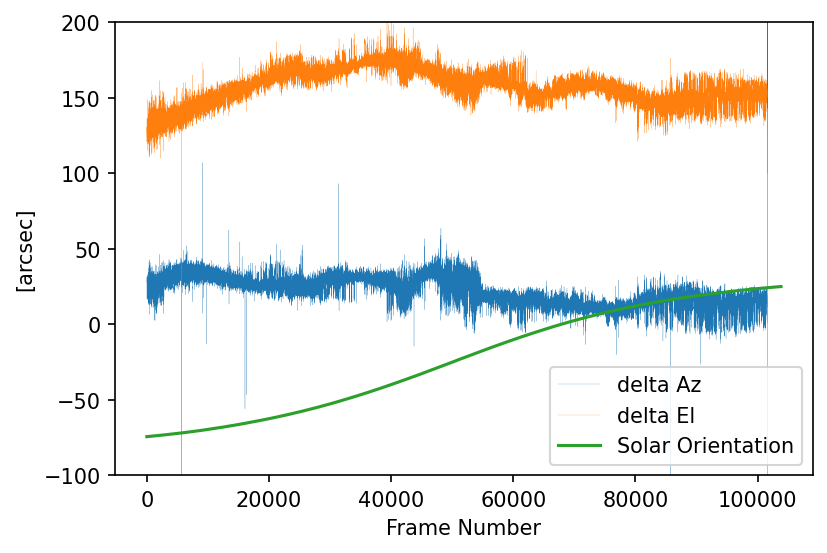

In [39]:
# Plot difference between Az and El pointing offsets between front and rear PYAS.
plt.plot(pyasf_offset_az_pyasrtime - pyasr['offset_az'], label="delta Az", linewidth=0.1) # Should be roughly consistent
plt.plot(pyasf_offset_el_pyasrtime - pyasr['offset_el'], label="delta El", linewidth=0.1) # Should be show an arc
plt.plot(sun_orientation_pyasf, label="Solar Orientation")
plt.legend()
plt.ylim(-100, 200)
plt.xlabel("Frame Number")
plt.ylabel('[arcsec]')

#### Az an El difference between PYAS-F and Telescope Pointing

Text(0, 0.5, '[arcsec]')

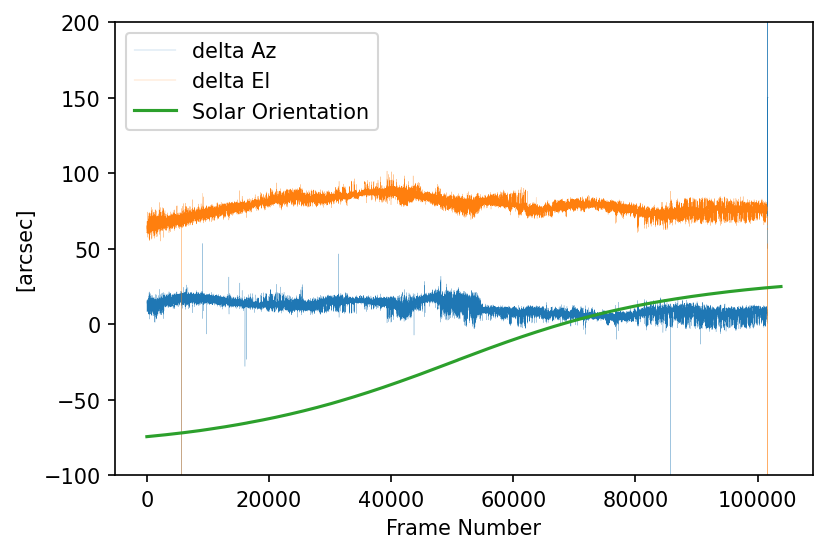

In [40]:
# Plot difference between Az and El pointing offsets between front and rear PYAS.
plt.plot((pyasf_offset_az_pyasrtime - pyasr['offset_az'])/2, label="delta Az", linewidth=0.1) # Should be roughly consistent
plt.plot((pyasf_offset_el_pyasrtime - pyasr['offset_el'])/2, label="delta El", linewidth=0.1) # Should be show an arc
plt.plot(sun_orientation_pyasf, label="Solar Orientation")
plt.legend()
plt.ylim(-100, 200)
plt.xlabel("Frame Number")
plt.ylabel('[arcsec]')

### Geometric Distance

#### Geometric Distance between Header-derived and GPS-derived PYAS-F Vector

In [34]:
# Calculate geometric distance between header-derived and GPS-derived PYAS-F.
dist_pyasf_header_gps = np.sqrt(
    (bad_Tx_pyasf.to_value(u.arcsec) - target_hpc_pyasf.Tx.to_value(u.arcsec))**2 + \
    (bad_Ty_pyasf.to_value(u.arcsec) - target_hpc_pyasf.Ty.to_value(u.arcsec))**2) * u.arcsec

(15.0, 30.0)

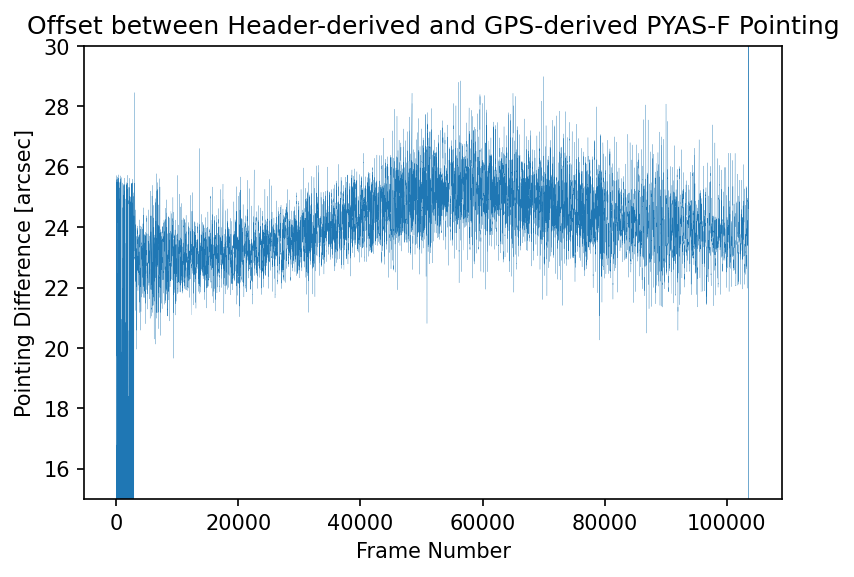

In [42]:
plt.plot(dist_pyasf_header_gps, linewidth=0.1)
plt.xlabel("Frame Number")
plt.ylabel("Pointing Difference [arcsec]")
plt.title("Offset between Header-derived and GPS-derived PYAS-F Pointing")
plt.ylim(15, 30)
#plt.savefig("HEROES_pointing_difference_header_gps_pyasf_timeseries.png")

#### Geometric Distance between Telescope Vector and PYAS-F (GPS-derived)

In [35]:
# Calculate geometric distance between PYAS-F and telescope pointing.
dist_pyasf_telescope = np.sqrt(
    (target_hpc.Tx.to_value(u.arcsec) - target_hpc_pyasf_pyasrtime.Tx.to_value(u.arcsec))**2 + \
    (target_hpc.Ty.to_value(u.arcsec) - target_hpc_pyasf_pyasrtime.Ty.to_value(u.arcsec))**2) * u.arcsec

(20.0, 120.0)

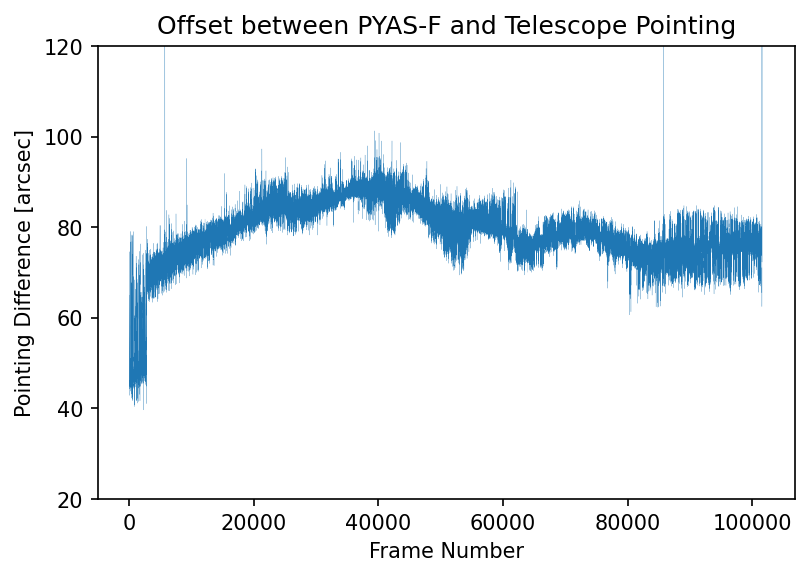

In [44]:
plt.plot(dist_pyasf_telescope, linewidth=0.1)
plt.xlabel("Frame Number")
plt.ylabel("Pointing Difference [arcsec]")
plt.title("Offset between PYAS-F and Telescope Pointing")
plt.ylim(20, 120)
#plt.savefig("HEROES_pointing_difference_telescope_pyasf_timeseries.png")

Text(0.5, 1.0, 'Offset between Approx and GPS-derived Pointing - PYAS-F')

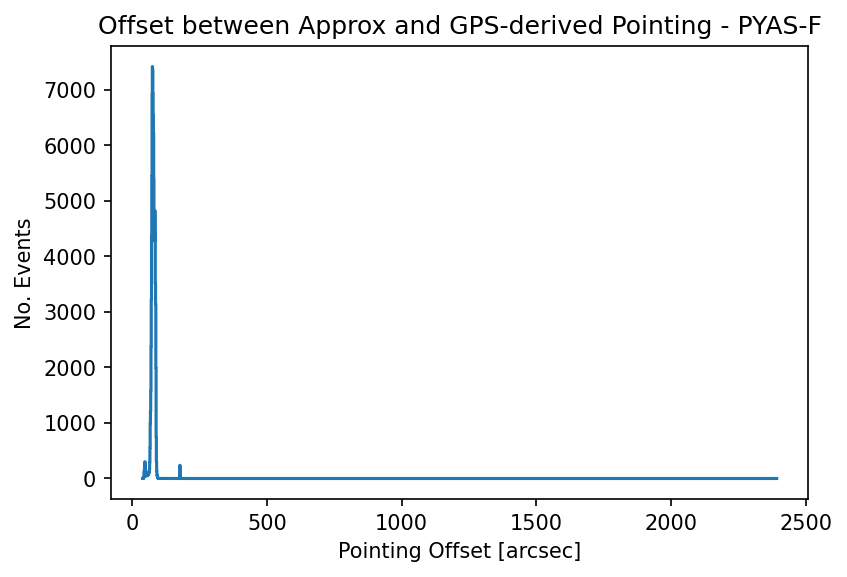

In [45]:
plot_hist(dist_pyasf_telescope)
plt.xlabel("Pointing Offset [{0}]".format(dist_pyasf_telescope.unit))
plt.title("Offset between Approx and GPS-derived Pointing - PYAS-F")
#plt.yscale("log")

#### Geometric Distance between Telescope/GPS and PYAS-F/Header Pointing

In [36]:
# Calculate geometric distance between PYAS-F and telescope pointing.
unit = u.arcsec
dist_pyasfheader_telescopegps = np.sqrt(
    (target_hpc.Tx.to_value(unit) - bad_Tx_pyasf_pyasrtime.to_value(unit))**2 + \
    (target_hpc.Ty.to_value(unit) - bad_Ty_pyasf_pyasrtime.to_value(unit))**2) * unit

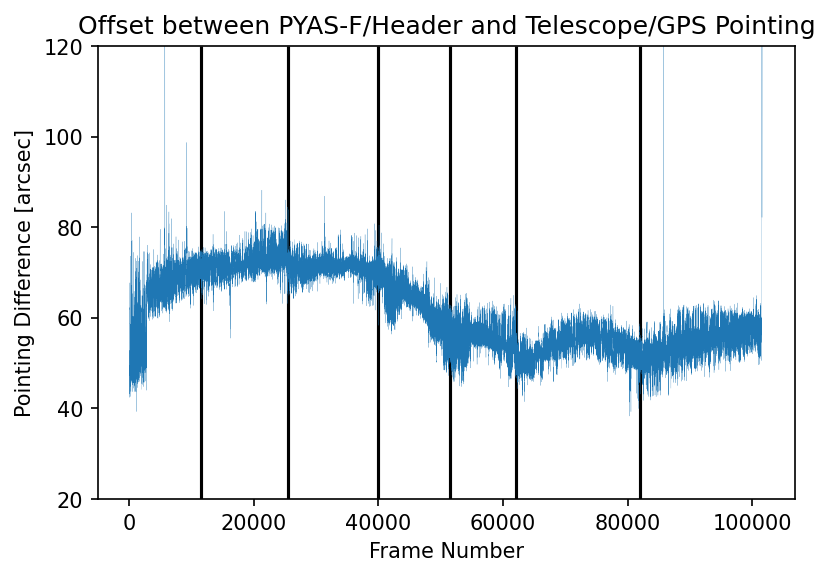

In [133]:
plt.plot(dist_pyasfheader_telescopegps, linewidth=0.1)
plt.xlabel("Frame Number")
plt.ylabel("Pointing Difference [arcsec]")
plt.title("Offset between PYAS-F/Header and Telescope/GPS Pointing")
plt.ylim(20, 120)
#plt.savefig("HEROES_pointing_difference_telescopegps_pyasfheader_timeseries.png")

(40.0, 90.0)

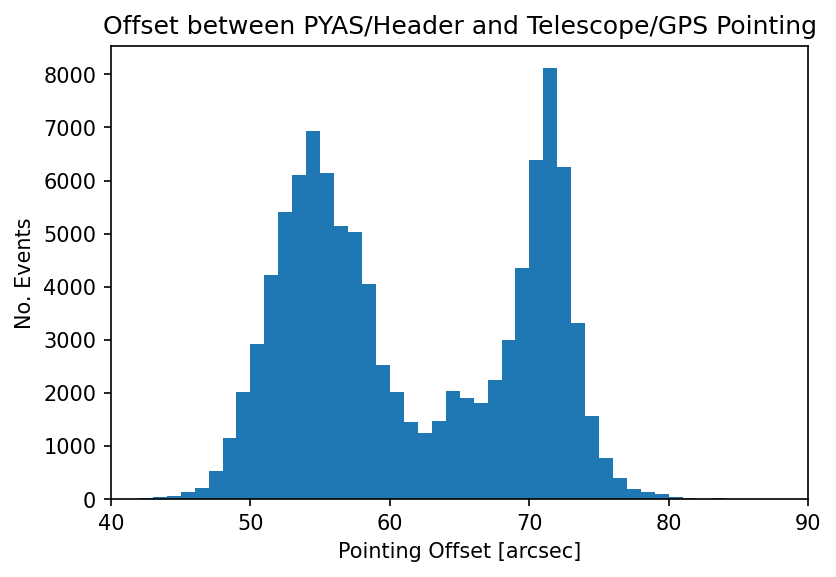

In [48]:
unit = u.arcsec
bin_size = 1
bin_min = np.floor(np.min(dist_pyasfheader_telescopegps.to_value(unit)))
bin_max = np.ceil(np.max(dist_pyasfheader_telescopegps.to_value(unit)))
n_bins = int((bin_max - bin_min) // bin_size)
mod_bins = (bin_max - bin_min) % bin_size
bins = np.linspace(bin_min, bin_max+mod_bins, n_bins+1)

plt.hist(dist_pyasfheader_telescopegps.to_value(unit), bins=bins)
plt.xlabel("Pointing Offset [{0}]".format(dist_pyasfheader_telescopegps.unit))
plt.ylabel("No. Events")
plt.title("Offset between PYAS/Header and Telescope/GPS Pointing")
plt.xlim(40, 90)
#plt.savefig("heroes_telescopegps_vs_pyasfheader_pointing_difference_hist.png")

### Plot Pointing on Map of Sun

#### Plot Pointing on Map of Sun Header-derived and GPS-derived PYAS-F Vector

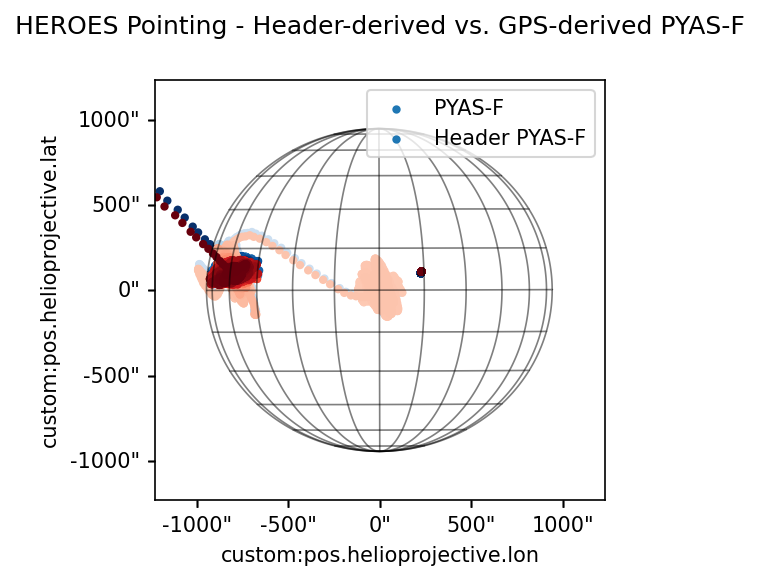

In [49]:
# Plot pointing of PYAS-F and -R
empty_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)
empty_map.data[:] = 0.

fig = plt.figure()
#left, bottom, width, and height
ax = fig.add_axes([0.15, 0.15, 0.5, 0.7], projection=empty_map.wcs)
ax.set_xlim(-0.5, empty_map.data.shape[1] - 0.5)
ax.set_ylim(-0.5, empty_map.data.shape[0] - 0.5)
empty_map.draw_grid(ax, color="black")
ax.scatter(target_hpc_pyasf.Tx.to_value(u.deg), target_hpc_pyasf.Ty.to_value(u.deg),
           transform=ax.get_transform('world'), marker='.', c=np.linspace(0.2, 1, n_pyasf), cmap="Blues",
           norm=mpl.colors.Normalize(0, 1), label="PYAS-F")
ax.scatter(bad_Tx_pyasf.to_value(u.deg), bad_Ty_pyasf.to_value(u.deg),
           transform=ax.get_transform('world'), marker='.', c=np.linspace(0.2, 1, n_pyasf), cmap="Reds",
           norm=mpl.colors.Normalize(0, 1), label="Header PYAS-F")
ax.set_title("HEROES Pointing - Header-derived vs. GPS-derived PYAS-F")
plt.legend()
#plt.savefig("heroes_header_vs_gps_pyasf_pointing_map.png")

#### Plot Pointing on Map of Sun Header-derived and Telescope Vector

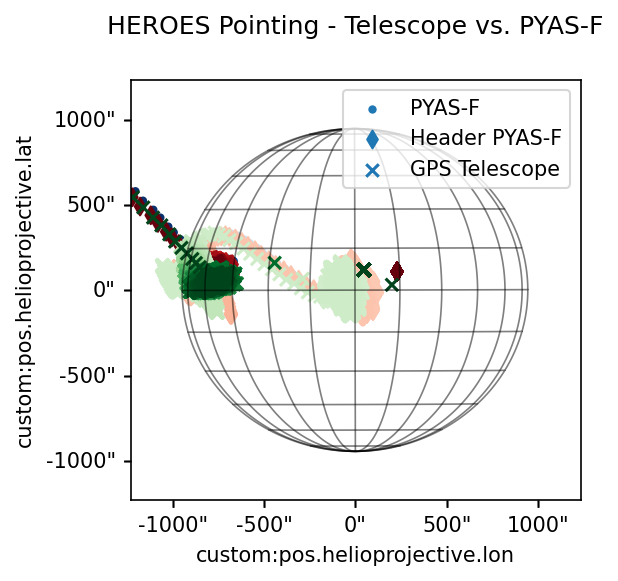

In [50]:
# Plot pointing of PYAS-F and -R
empty_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)
empty_map.data[:] = 0.

fig = plt.figure()
#left, bottom, width, and height
ax = fig.add_axes([0.15, 0.15, 0.5, 0.7], projection=empty_map.wcs)
ax.set_xlim(-0.5, empty_map.data.shape[1] - 0.5)
ax.set_ylim(-0.5, empty_map.data.shape[0] - 0.5)
empty_map.draw_grid(ax, color="black")
#ax.scatter(target_hpc_pyasr.Tx.to_value(u.deg), target_hpc_pyasr.Ty.to_value(u.deg),
#           transform=ax.get_transform('world'), marker='.', c=np.linspace(0, 1, n_pyasr), cmap="Reds")
ax.scatter(target_hpc_pyasf.Tx.to_value(u.deg), target_hpc_pyasf.Ty.to_value(u.deg),
           transform=ax.get_transform('world'), marker='.', c=np.linspace(0.2, 1, n_pyasf), cmap="Blues",
           norm=mpl.colors.Normalize(0, 1), label="PYAS-F")
ax.scatter(bad_Tx_pyasf.to_value(u.deg), bad_Ty_pyasf.to_value(u.deg),
           transform=ax.get_transform('world'), marker='d', c=np.linspace(0.2, 1, n_pyasf), cmap="Reds",
           norm=mpl.colors.Normalize(0, 1), label="Header PYAS-F")
ax.scatter(target_hpc.Tx.to_value(u.deg), target_hpc.Ty.to_value(u.deg),
           transform=ax.get_transform('world'), marker='x', c=np.linspace(0.2, 1, n_pyasr), cmap="Greens",
           norm=mpl.colors.Normalize(0, 1), label="GPS Telescope")
ax.set_title("HEROES Pointing - Telescope vs. PYAS-F")
plt.legend()
#plt.savefig("heroes_telescope_vs_pyasf_pointing_map.png")

### Pointing Difference Heat Map on the Sun

#### Pointing Difference Heat Map on the Sun between header-derived and GPS-derived PYAS-F

In [51]:
# Create 2D spatial grid and assign each pointing into a bin based on PYAS-F pointing.
w_good_pointing = np.where(target_hpc_pyasf.Tx > -1000*u.arcsec)[0]
spatial_unit = u.arcsec
x_pointing = target_hpc_pyasf.Tx[w_good_pointing].to_value(spatial_unit)
y_pointing = target_hpc_pyasf.Ty[w_good_pointing].to_value(spatial_unit)
diff_pointing_header_gps_pyasf = dist_pyasf_header_gps[w_good_pointing].to_value(spatial_unit)

x_step = 5
x_min = x_pointing.min()
x_max = x_pointing.max()
x_bins = np.arange(int(x_min), np.ceil(x_max), x_step)

y_step = 5
y_min = y_pointing.min()
y_max = y_pointing.max()
y_bins = np.arange(int(y_min), np.ceil(y_max), y_step)

# Determine which pointing go into which bins in the x and y directions.
x_digitized = np.digitize(x_pointing, x_bins)
y_digitized = np.digitize(y_pointing, y_bins)

# Determine max pointing difference for each pointings in each bin.
diff_pointing_map_header_gps_pyasf = np.empty((len(y_bins), len(x_bins))) * np.nan
for j in range(len(y_bins)):
    for i in range(len(x_bins)):
        w = np.logical_and(x_digitized == i, y_digitized == j)
        if w.any():
            diff_pointing_map_header_gps_pyasf[j, i] = diff_pointing_header_gps_pyasf[w].max()

Text(0.5, 1.0, 'Pointing Difference Header-derived vs. GPS-derived PYAS-F')

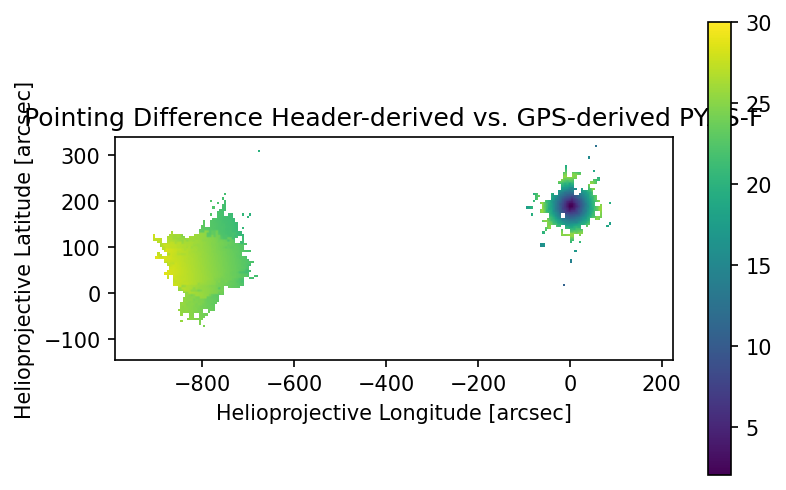

In [52]:
plt.imshow(diff_pointing_map_header_gps_pyasf, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
           cmap='viridis', vmax=30)
plt.colorbar()
plt.xlabel("Helioprojective Longitude [arcsec]")
plt.ylabel("Helioprojective Latitude [arcsec]")
plt.title("Pointing Difference Header-derived vs. GPS-derived PYAS-F")
#plt.savefig("heroes_header_vs_gps_pyasf_pointing_difference_map.png")

Text(0, 0.5, 'No. Events')

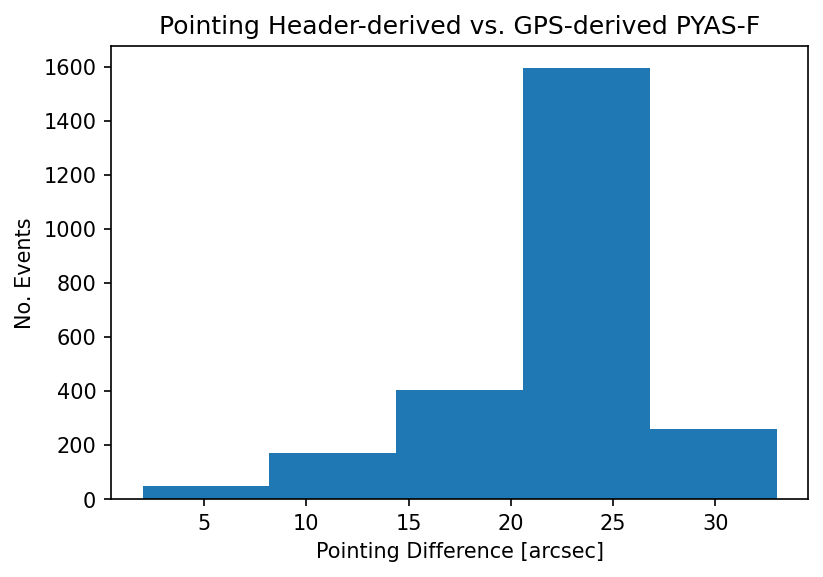

In [53]:
bin_size = 5

diff_pointing_flat_header_gps_pyasf = diff_pointing_map_header_gps_pyasf.flatten()
diff_pointing_flat_header_gps_pyasf = diff_pointing_flat_header_gps_pyasf[~np.isnan(diff_pointing_flat_header_gps_pyasf)]
bin_min = np.floor(np.min(diff_pointing_flat_header_gps_pyasf))
bin_max = np.ceil(np.max(diff_pointing_flat_header_gps_pyasf))
n_bins = int((bin_max - bin_min) // bin_size)
mod_bins = (bin_max - bin_min) % bin_size
bins = np.linspace(bin_min, bin_max+mod_bins, n_bins+1)
hist = plt.hist(diff_pointing_flat_header_gps_pyasf, bins=bins)
#plt.xlim(20, 120)
plt.title("Pointing Header-derived vs. GPS-derived PYAS-F")
plt.xlabel("Pointing Difference [arcsec]")
plt.ylabel("No. Events")

#### Pointing Difference Heat Map on the Sun between Telescope and PYAS-F

In [54]:
# Create 2D spatial grid and assign each pointing into a bin based on PYAS-F pointing.
w_good_pointing = np.where(target_hpc_pyasf_pyasrtime.Tx > -1000*u.arcsec)[0]
spatial_unit = u.arcsec
x_pointing = target_hpc_pyasf_pyasrtime.Tx[w_good_pointing].to_value(spatial_unit)
y_unit = u.arcsec
y_pointing = target_hpc_pyasf_pyasrtime.Ty[w_good_pointing].to_value(spatial_unit)
diff_pointing = dist_pyasf_telescope[w_good_pointing].to_value(spatial_unit)

x_step = 5
x_min = x_pointing.min()
x_max = x_pointing.max()
x_bins = np.arange(int(x_min), np.ceil(x_max), x_step)

y_step = 5
y_min = y_pointing.min()
y_max = y_pointing.max()
y_bins = np.arange(int(y_min), np.ceil(y_max), y_step)

# Determine which pointing go into which bins in the x and y directions.
x_digitized = np.digitize(x_pointing, x_bins)
y_digitized = np.digitize(y_pointing, y_bins)

# Determine max pointing difference for each pointings in each bin.
diff_pointing_map = np.empty((len(y_bins), len(x_bins))) * np.nan
for j in range(len(y_bins)):
    for i in range(len(x_bins)):
        w = np.logical_and(x_digitized == i, y_digitized == j)
        if w.any():
            diff_pointing_map[j, i] = diff_pointing[w].max()

Text(0.5, 1.0, 'Pointing Difference PYAS-F vs. Telescope')

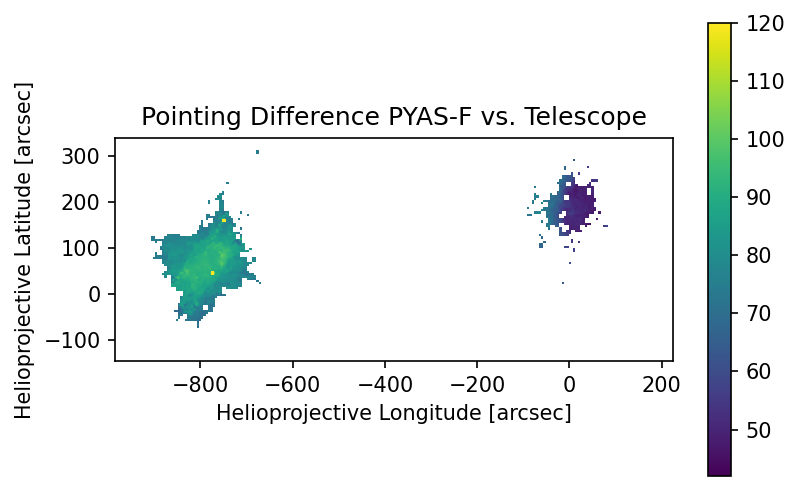

In [55]:
plt.imshow(diff_pointing_map, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], cmap='viridis', vmax=120)
plt.colorbar()
plt.xlabel("Helioprojective Longitude [arcsec]")
plt.ylabel("Helioprojective Latitude [arcsec]")
plt.title("Pointing Difference PYAS-F vs. Telescope")
#plt.savefig("heroes_telescope_vs_pyasf_pointing_difference_map.png")

Text(0, 0.5, 'No. Events')

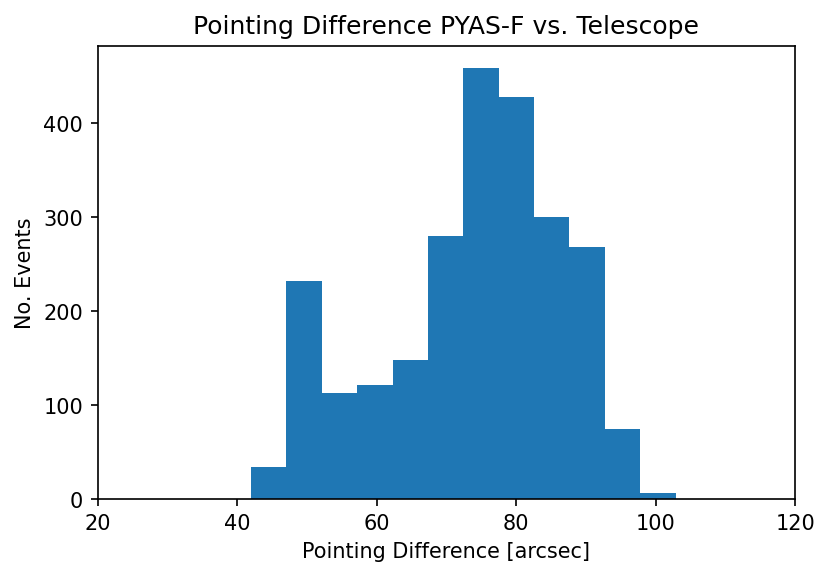

In [56]:
bin_size = 5

diff_pointing_flat = diff_pointing_map.flatten()
diff_pointing_flat = diff_pointing_flat[~np.isnan(diff_pointing_flat)]
bin_min = np.floor(np.min(diff_pointing_flat))
bin_max = np.ceil(np.max(diff_pointing_flat))
n_bins = int((bin_max - bin_min) // bin_size)
mod_bins = (bin_max - bin_min) % bin_size
bins = np.linspace(bin_min, bin_max+mod_bins, n_bins+1)
hist = plt.hist(diff_pointing_flat, bins=bins)
plt.xlim(20, 120)
plt.title("Pointing Difference PYAS-F vs. Telescope")
plt.xlabel("Pointing Difference [arcsec]")
plt.ylabel("No. Events")

#### Pointing Difference Heat Map on the Sun between PYAS-F header-derived & GPS-derived data.

In [57]:
# Create 2D spatial grid and assign each pointing into a bin based on PYAS-F pointing.
w_good_pointing = np.where(bad_Tx_pyasf_pyasrtime > -1000*u.arcsec)[0]
spatial_unit = u.arcsec
x_pointing = bad_Tx_pyasf_pyasrtime[w_good_pointing].to_value(spatial_unit)
y_pointing = bad_Ty_pyasf_pyasrtime[w_good_pointing].to_value(spatial_unit)
diff_pointing_pyasfheader_telescopegps = dist_pyasfheader_telescopegps[w_good_pointing].to_value(spatial_unit)

x_step = 5
x_min = x_pointing.min()
x_max = x_pointing.max()
x_bins = np.arange(int(x_min), np.ceil(x_max), x_step)

y_step = 5
y_min = y_pointing.min()
y_max = y_pointing.max()
y_bins = np.arange(int(y_min), np.ceil(y_max), y_step)

# Determine which pointing go into which bins in the x and y directions.
x_digitized = np.digitize(x_pointing, x_bins)
y_digitized = np.digitize(y_pointing, y_bins)

# Determine max pointing difference for each pointings in each bin.
diff_pointing_pyasfheader_telescopegps_map = np.empty((len(y_bins), len(x_bins))) * np.nan
for j in range(len(y_bins)):
    for i in range(len(x_bins)):
        w = np.logical_and(x_digitized == i, y_digitized == j)
        if w.any():
            diff_pointing_pyasfheader_telescopegps_map[j, i] = diff_pointing_pyasfheader_telescopegps[w].max()

Text(0.5, 1.0, 'Pointing Difference PYAS-F/Header vs. Telescope/GPS')

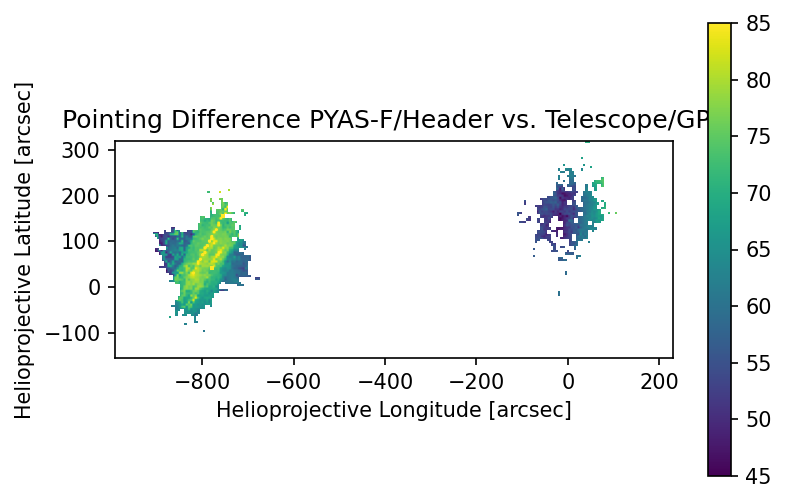

In [58]:
plt.imshow(diff_pointing_pyasfheader_telescopegps_map, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
           cmap='viridis', vmin=45, vmax=85)
plt.colorbar()
plt.xlabel("Helioprojective Longitude [arcsec]")
plt.ylabel("Helioprojective Latitude [arcsec]")
plt.title("Pointing Difference PYAS-F/Header vs. Telescope/GPS")
#plt.savefig("heroes_telescopegps_vs_pyasfheader_pointing_difference_2Dhist.png")

### Pointing Heat Map/Contour Comparisons

#### Comparison of Header-derived & GPS-derived PYAS-F Pointing

In [37]:
# Create 2D histogram of PYAS-F pointing for main pointing target.
spatial_unit = u.arcsec
w_good_pointing = np.logical_and(target_hpc_pyasf.Tx < -500*spatial_unit, target_hpc_pyasf.Tx > -1000*spatial_unit)

# Extract region of interest pointings for the header-derived pointing data.
x_pointing_pyasf_header = bad_Tx_pyasf[w_good_pointing].to_value(spatial_unit)
y_pointing_pyasf_header = bad_Ty_pyasf[w_good_pointing].to_value(spatial_unit)

# Extract region of interest pointings for the gpd-derived pointing data.
x_pointing_pyasf_gps = target_hpc_pyasf.Tx[w_good_pointing].to_value(spatial_unit)
y_pointing_pyasf_gps = target_hpc_pyasf.Ty[w_good_pointing].to_value(spatial_unit)

# Define x and y bins.
x_step = 5
x_min = min((x_pointing_pyasf_header.min(), x_pointing_pyasf_gps.min()))
x_max = max((x_pointing_pyasf_header.max(), x_pointing_pyasf_gps.max()))
x_bins = np.arange(int(x_min), np.ceil(x_max), x_step)
y_step = 5
y_min = min((y_pointing_pyasf_header.min(), y_pointing_pyasf_gps.min()))
y_max = max((y_pointing_pyasf_header.max(), y_pointing_pyasf_gps.max()))
y_bins = np.arange(int(y_min), np.ceil(y_max), y_step)

# Define 2-D hists for each pointing dataset.
pointing_hist2D_pyasf_header, x_edges, y_edges = np.histogram2d(y_pointing_pyasf_header, x_pointing_pyasf_header,
                                                                bins=[y_bins, x_bins])
pointing_hist2D_pyasf_gps, x_edges, y_edges = np.histogram2d(y_pointing_pyasf_gps, x_pointing_pyasf_gps,
                                                             bins=[y_bins, x_bins])

Text(0, 0.5, 'Helioprojective Latitude [arcsec]')

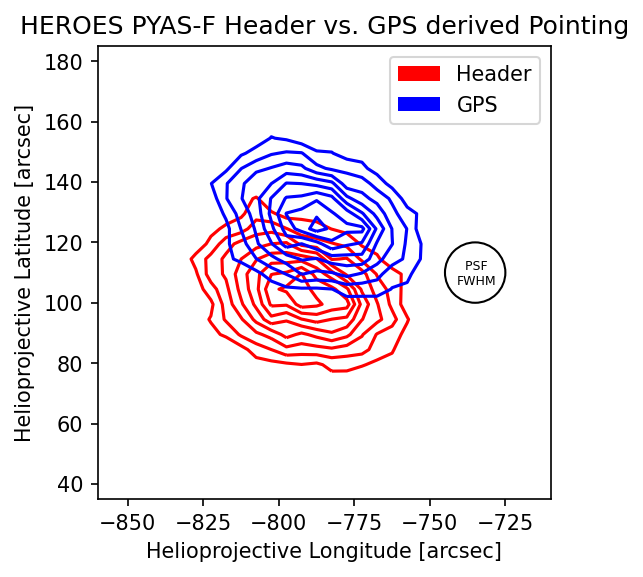

In [69]:
x = (x_bins[:-1] + x_bins[1:]) / 2
y = (y_bins[:-1] + y_bins[1:]) / 2
fractional_levels = np.arange(0.25, 1, 0.1)

fig, ax = plt.subplots()

contours_pyasf_header = ax.contour(x, y, pointing_hist2D_pyasf_header,
                                    levels=fractional_levels*pointing_hist2D_pyasf_header.max(),
                                    colors=["red"])
contours_pyasf_gps = ax.contour(x, y, pointing_hist2D_pyasf_gps,
                                 levels=fractional_levels*pointing_hist2D_pyasf_gps.max(),
                                 colors=["blue"])

circle_center = (-735, 110)
psf_fwhm = 20 # arcsec
p = Circle(circle_center, psf_fwhm/2, fill=False)
ax.add_artist(p)
plt.annotate("  PSF\nFWHM", (circle_center[0]-6, circle_center[1]-4), fontsize=6)

ax.set_aspect("equal", "box")
ax.set_xlim(-860, -710)
ax.set_ylim(35, 185)
ax.set_title("HEROES PYAS-F Header vs. GPS derived Pointing")

# Manually create legend
proxy = [plt.Rectangle((0,0),1,1,fc = pc.colors[0]) for pc in [contours_pyasf_header, contours_pyasf_gps]]
plt.legend(proxy, ["Header", "GPS"])
ax.set_xlabel("Helioprojective Longitude [arcsec]")
ax.set_ylabel("Helioprojective Latitude [arcsec]")
plt.savefig("HEROES_pyasf_header_vs_gps_pointing_contours.png")

#### Comparison of Header-derived PYAS-F and GPS-derived Telescope Pointing

Perform this comparisons for different time periods to try to isolate the effect of movement of the rear of the rear part of the telescope.

In [70]:
# Indices of different time periods.
periods = [slice(11500, 25500), slice(25500, 40000), slice(40000, 51500),
           slice(51500, 62000), slice(62000, 82000), slice(82000, len(target_hpc_pyasf))]

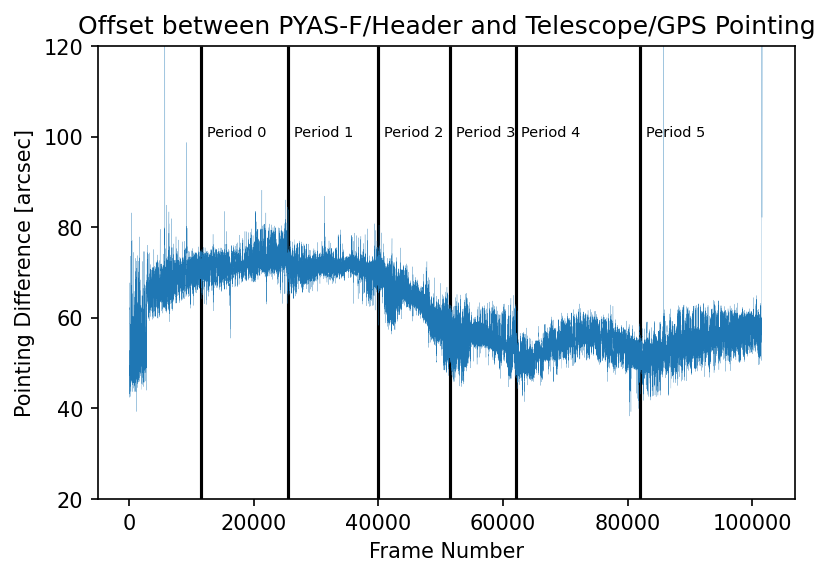

In [71]:
# Plot the time periods we will use.
plt.plot(dist_pyasfheader_telescopegps, linewidth=0.1)
plt.xlabel("Frame Number")
plt.ylabel("Pointing Difference [arcsec]")
plt.title("Offset between PYAS-F/Header and Telescope/GPS Pointing")
plt.ylim(20, 120)
plt.vlines([period.start for period in periods], ymin=20, ymax=120)
for i, period in enumerate(periods):
    plt.annotate(f"Period {i}", (period.start+900, 100), xycoords='data', fontsize=7)
#plt.savefig("HEROES_pointing_telescopegps_pyasfheader_comparison_periods.png")

In [72]:
# Create 2D histogram of PYAS-F pointing for main pointing target.
spatial_unit = u.arcsec

# Extract region of interest pointings for the header-derived pointing data.
x_pointing_pyasf_header_list = [bad_Tx_pyasf[w].to_value(spatial_unit) for w in periods]
y_pointing_pyasf_header_list = [bad_Ty_pyasf[w].to_value(spatial_unit) for w in periods]

# Extract region of interest pointings for the gpd-derived pointing data.
x_pointing_telescope_list = [target_hpc.Tx[w].to_value(spatial_unit) for w in periods]
y_pointing_telescope_list = [target_hpc.Ty[w].to_value(spatial_unit) for w in periods]

# Define x bins.
x_step = 5
x_min = min([x.min() for x in x_pointing_pyasf_header_list + x_pointing_telescope_list])
x_max = max([x.max() for x in x_pointing_pyasf_header_list + x_pointing_telescope_list])
x_bins = np.arange(int(x_min), np.ceil(x_max), x_step)

# Define y bins.
y_step = 5
y_min = min([y.min() for y in y_pointing_pyasf_header_list + y_pointing_telescope_list])
y_max = max([y.max() for y in y_pointing_pyasf_header_list + y_pointing_telescope_list])
y_bins = np.arange(int(y_min), np.ceil(y_max), y_step)

# Define 2-D hists for each pointing dataset.
pointing_hist2D_pyasf_header = [
    np.histogram2d(y, x, bins=[y_bins, x_bins])[0]
    for x, y in zip(x_pointing_pyasf_header_list, y_pointing_pyasf_header_list)]

pointing_hist2D_telescope = [
    np.histogram2d(y, x, bins=[y_bins, x_bins])[0]
    for x, y in zip(x_pointing_telescope_list, y_pointing_telescope_list)]

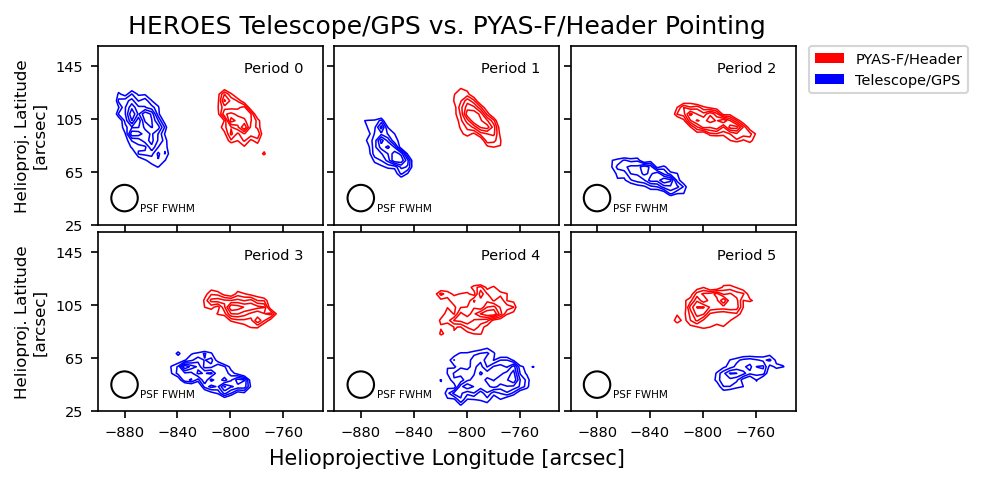

In [241]:
x = (x_bins[:-1] + x_bins[1:]) / 2
y = (y_bins[:-1] + y_bins[1:]) / 2
fractional_levels = np.arange(0.5, 1, 0.1)

xlim = (-900, -730)
ylim = (25, 160)
tick_spacing = 40
xticks = np.arange(-880, xlim[1], tick_spacing)
yticks = np.arange(ylim[0], ylim[1], tick_spacing)

linewidth = 0.75

annotation_xy = (0.65, 0.85)
annotation_coords = "axes fraction"

# Manually create legend
proxy = [plt.Rectangle((0,0),1,1,fc = pc.colors[0]) for pc in [contours_pyasf_header, contours_pyasf_gps]]
legend_labels = ["PYAS-F/Header", "Telescope/GPS"]

# Define cicle for PSF FWHM.
circle_center = (-880, 45)
psf_fwhm = 20 # arcsec
psf_radius = psf_fwhm/2

fig, axes = plt.subplots(2, 3, sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.05, hspace=-0.3)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        k = i * axes.shape[1] + j
        axes[i, j].set_aspect("equal")
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)
        plt.xticks(xticks)
        plt.yticks(yticks)
        axes[i, j].tick_params(axis="both", labelsize=7)
        #axes[i, j].tick_params(axis="x", rotation=45)
        contours_pyasf = axes[i, j].contour(x, y, pointing_hist2D_pyasf_header[k],
                                            levels=fractional_levels * pointing_hist2D_pyasf_header[k].max(),
                                            colors=["red"], linewidths=linewidth)
        contours_telescope = axes[i, j].contour(x, y, pointing_hist2D_telescope[k],
                                                levels=fractional_levels * pointing_hist2D_telescope[k].max(),
                                                colors=["blue"], linewidths=linewidth)
        # Annotate period label
        axes[i, j].annotate(f"Period {k}", annotation_xy, xycoords=annotation_coords, fontsize=7)
        # Plot PSF.
        p = Circle(circle_center, psf_radius, fill=False)
        axes[i, j].add_artist(p)
        axes[i, j].annotate("PSF FWHM", (circle_center[0]+psf_radius+2, circle_center[1]-10), fontsize=5)
        
#contours_pyasf = axes[1, 2].contour(x[467:509], y, pointing_hist2D_pyasf_header[-1][:, 467:509],
#                                    levels=fractional_levels * pointing_hist2D_pyasf_header[-1].max(),
#                                    colors=["red"], linewidths=linewidth)
#contours_telescope = axes[i, j].contour(x, y, pointing_hist2D_telescope[k],
#                                        levels=fractional_levels * pointing_hist2D_telescope[k].max(),
#                                        colors=["blue"], linewidths=linewidth)
        

axes[0, 1].set_title("HEROES Telescope/GPS vs. PYAS-F/Header Pointing")
axes[0, 0].set_ylabel("Helioproj. Latitude\n[arcsec]", fontsize=8)
axes[1, 0].set_ylabel("Helioproj. Latitude\n[arcsec]", fontsize=8)
axes[1, 1].set_xlabel("Helioprojective Longitude [arcsec]")
# Manually create legend
proxy = [plt.Rectangle((0,0),1,1,fc = pc.colors[0]) for pc in [contours_pyasf, contours_telescope]]
axes[0, 2].legend(proxy, ["PYAS-F/Header", "Telescope/GPS"], bbox_to_anchor=(1.8, 1.04), fontsize=7)
plt.savefig("HEROES_telescopegps_vs_pyasfheader_pointing_contours.png", bbox_inches=Bbox(np.array([[0.15, 0.4],[6.6,3.5]])))